# Model Notebook

In [1]:
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
# Auto Correlation
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# AR Autoregressive
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest
from pmdarima.model_selection import train_test_split

from help_functions import *

warnings.filterwarnings('ignore')

In [2]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 
                                  'State', 'Metro', 'Borough'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def melt_data_mean(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 
                                  'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})


def melt_data_roi(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 
                                  'State', 'Metro', 'CountyName', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted


def plot_trend(data, title):
    data.plot.line(color = 'green')
    plt.title(title)
    plt.ylabel('Price ($ in Millions)')
    plt.grid()
    plt.show()
    
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [3]:
df = pd.read_csv('zillow_data.csv')
df

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

In [4]:
# Filter City column to just New York
nyc = df[df['City'] == 'New York']
nyc

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
6         61807       10467  New York    NY  New York      Bronx         7   
10        62037       11226  New York    NY  New York      Kings        11   
12        62087       11375  New York    NY  New York     Queens        13   
13        62045       11235  New York    NY  New York      Kings        14   
20        61625       10011  New York    NY  New York   New York        21   
...         ...         ...       ...   ...       ...        ...       ...   
8008      62122       11436  New York    NY  New York     Queens      8009   
8303      62078       11366  New York    NY  New York     Queens      8304   
8387      61783       10307  New York    NY  New York   Richmond      8388   
9911      62075       11363  New York    NY  New York     Queens      9912   
11037     61804       10464  New York    NY  New York      Bronx     11038   

        1996-04   1996-05   1996-06  ...   2017-07   2017-08   2017-09  \
6      152900.0  152700.0  152600.0  ...    394400    400000    407300   
10     162000.0  162300.0  162600.0  ...    860200    851000    853900   
12     252400.0  251800.0  251400.0  ...   1022600   1033700   1048600   
13     190500.0  191000.0  191500.0  ...    767300    777300    788800   
20          NaN       NaN       NaN  ...  12137600  12112600  12036600   
...         ...       ...       ...  ...       ...       ...       ...   
8008   119000.0  119400.0  119900.0  ...    383800    382200    381000   
8303   231800.0  232000.0  232300.0  ...    830000    839100    847800   
8387   186700.0  186800.0  186900.0  ...    522000    525600    527900   
9911   295000.0  296200.0  297700.0  ...   1032000   1043700   1049800   
11037  195900.0  195600.0  195100.0  ...    513100    518200    526100   

        2017-10   2017-11   2017-12   2018-01   2018-02   2018-03   2018-04  
6        411600    413200    414300    413900    411400    413200    417900  
10       870000    885100    887800    890500    901700    930700    963200  
12      1066400   1081200   1088800   1092700   1089500   1084000   1084600  
13       793900    796000    799700    806600    810600    813400    816200  
20     12050100  12016300  11946500  11978100  11849300  11563000  11478300  
...         ...       ...       ...       ...       ...       ...       ...  
8008     382500    385600    387600    388700    390600    395100    400300  
8303     854900    859600    861700    865600    871900    882700    893600  
8387     533800    543300    550800    559300    566900    571600    575900  
9911    1047900   1041200   1035400   1040700   1048600   1052100   1051300  
11037    532000    533100    533100    534400    533300    533000    536200  

[114 rows x 272 columns]

In [5]:
# Rename RegionName and County columns to Zip code and Borough
nyc = nyc.rename({'RegionName':'Zipcode'}, axis = 'columns')
nyc = nyc.rename({'CountyName':'Borough'}, axis = 'columns')

In [6]:
nyc['Borough'].replace({'Kings': 'Brooklyn', 'Richmond': 'Staten Island', 'New York': 'Manhattan'}, inplace = True)

In [7]:
nyc

RegionID  Zipcode      City State     Metro        Borough  SizeRank  \
6         61807    10467  New York    NY  New York          Bronx         7   
10        62037    11226  New York    NY  New York       Brooklyn        11   
12        62087    11375  New York    NY  New York         Queens        13   
13        62045    11235  New York    NY  New York       Brooklyn        14   
20        61625    10011  New York    NY  New York      Manhattan        21   
...         ...      ...       ...   ...       ...            ...       ...   
8008      62122    11436  New York    NY  New York         Queens      8009   
8303      62078    11366  New York    NY  New York         Queens      8304   
8387      61783    10307  New York    NY  New York  Staten Island      8388   
9911      62075    11363  New York    NY  New York         Queens      9912   
11037     61804    10464  New York    NY  New York          Bronx     11038   

        1996-04   1996-05   1996-06  ...   2017-07   2017-08   2017-09  \
6      152900.0  152700.0  152600.0  ...    394400    400000    407300   
10     162000.0  162300.0  162600.0  ...    860200    851000    853900   
12     252400.0  251800.0  251400.0  ...   1022600   1033700   1048600   
13     190500.0  191000.0  191500.0  ...    767300    777300    788800   
20          NaN       NaN       NaN  ...  12137600  12112600  12036600   
...         ...       ...       ...  ...       ...       ...       ...   
8008   119000.0  119400.0  119900.0  ...    383800    382200    381000   
8303   231800.0  232000.0  232300.0  ...    830000    839100    847800   
8387   186700.0  186800.0  186900.0  ...    522000    525600    527900   
9911   295000.0  296200.0  297700.0  ...   1032000   1043700   1049800   
11037  195900.0  195600.0  195100.0  ...    513100    518200    526100   

        2017-10   2017-11   2017-12   2018-01   2018-02   2018-03   2018-04  
6        411600    413200    414300    413900    411400    413200    417900  
10       870000    885100    887800    890500    901700    930700    963200  
12      1066400   1081200   1088800   1092700   1089500   1084000   1084600  
13       793900    796000    799700    806600    810600    813400    816200  
20     12050100  12016300  11946500  11978100  11849300  11563000  11478300  
...         ...       ...       ...       ...       ...       ...       ...  
8008     382500    385600    387600    388700    390600    395100    400300  
8303     854900    859600    861700    865600    871900    882700    893600  
8387     533800    543300    550800    559300    566900    571600    575900  
9911    1047900   1041200   1035400   1040700   1048600   1052100   1051300  
11037    532000    533100    533100    534400    533300    533000    536200  

[114 rows x 272 columns]

In [8]:
zip_lst = list(nyc['Zipcode'].values)
len(zip_lst)

114

There are 114 zip codes provided for NYC

In [9]:
nyc['Zipcode'].unique

<bound method Series.unique of 6        10467
10       11226
12       11375
13       11235
20       10011
         ...  
8008     11436
8303     11366
8387     10307
9911     11363
11037    10464
Name: Zipcode, Length: 114, dtype: int64>

In [10]:
# Melt the data
nyc_melt = melt_data(nyc)
nyc_melt

Zipcode  RegionID  SizeRank      City State     Metro        Borough  \
0        10467     61807         7  New York    NY  New York          Bronx   
1        11226     62037        11  New York    NY  New York       Brooklyn   
2        11375     62087        13  New York    NY  New York         Queens   
3        11235     62045        14  New York    NY  New York       Brooklyn   
5        10128     61703        22  New York    NY  New York      Manhattan   
...        ...       ...       ...       ...   ...       ...            ...   
30205    11436     62122      8009  New York    NY  New York         Queens   
30206    11366     62078      8304  New York    NY  New York         Queens   
30207    10307     61783      8388  New York    NY  New York  Staten Island   
30208    11363     62075      9912  New York    NY  New York         Queens   
30209    10464     61804     11038  New York    NY  New York          Bronx   

            time      value  
0     1996-04-01   152900.0  
1     1996-04-01   162000.0  
2     1996-04-01   252400.0  
3     1996-04-01   190500.0  
5     1996-04-01  3676700.0  
...          ...        ...  
30205 2018-04-01   400300.0  
30206 2018-04-01   893600.0  
30207 2018-04-01   575900.0  
30208 2018-04-01  1051300.0  
30209 2018-04-01   536200.0  

[29058 rows x 9 columns]

In [11]:
nyc_melt[nyc_melt['Zipcode'] == 10456]

Zipcode  RegionID  SizeRank      City State     Metro Borough  \
24289    10456     61796        37  New York    NY  New York   Bronx   
24403    10456     61796        37  New York    NY  New York   Bronx   
24517    10456     61796        37  New York    NY  New York   Bronx   
24631    10456     61796        37  New York    NY  New York   Bronx   
24745    10456     61796        37  New York    NY  New York   Bronx   
24859    10456     61796        37  New York    NY  New York   Bronx   
24973    10456     61796        37  New York    NY  New York   Bronx   
25087    10456     61796        37  New York    NY  New York   Bronx   
25201    10456     61796        37  New York    NY  New York   Bronx   
25315    10456     61796        37  New York    NY  New York   Bronx   
25429    10456     61796        37  New York    NY  New York   Bronx   
25543    10456     61796        37  New York    NY  New York   Bronx   
25657    10456     61796        37  New York    NY  New York   Bronx   
25771    10456     61796        37  New York    NY  New York   Bronx   
25885    10456     61796        37  New York    NY  New York   Bronx   
25999    10456     61796        37  New York    NY  New York   Bronx   
26113    10456     61796        37  New York    NY  New York   Bronx   
26227    10456     61796        37  New York    NY  New York   Bronx   
26341    10456     61796        37  New York    NY  New York   Bronx   
26455    10456     61796        37  New York    NY  New York   Bronx   
26569    10456     61796        37  New York    NY  New York   Bronx   
26683    10456     61796        37  New York    NY  New York   Bronx   
26797    10456     61796        37  New York    NY  New York   Bronx   
26911    10456     61796        37  New York    NY  New York   Bronx   
27025    10456     61796        37  New York    NY  New York   Bronx   
27139    10456     61796        37  New York    NY  New York   Bronx   
27253    10456     61796        37  New York    NY  New York   Bronx   
27367    10456     61796        37  New York    NY  New York   Bronx   
27481    10456     61796        37  New York    NY  New York   Bronx   
27595    10456     61796        37  New York    NY  New York   Bronx   
27709    10456     61796        37  New York    NY  New York   Bronx   
27823    10456     61796        37  New York    NY  New York   Bronx   
27937    10456     61796        37  New York    NY  New York   Bronx   
28051    10456     61796        37  New York    NY  New York   Bronx   
28165    10456     61796        37  New York    NY  New York   Bronx   
28279    10456     61796        37  New York    NY  New York   Bronx   
28393    10456     61796        37  New York    NY  New York   Bronx   
28507    10456     61796        37  New York    NY  New York   Bronx   
28621    10456     61796        37  New York    NY  New York   Bronx   
28735    10456     61796        37  New York    NY  New York   Bronx   
28849    10456     61796        37  New York    NY  New York   Bronx   
28963    10456     61796        37  New York    NY  New York   Bronx   
29077    10456     61796        37  New York    NY  New York   Bronx   
29191    10456     61796        37  New York    NY  New York   Bronx   
29305    10456     61796        37  New York    NY  New York   Bronx   
29419    10456     61796        37  New York    NY  New York   Bronx   
29533    10456     61796        37  New York    NY  New York   Bronx   
29647    10456     61796        37  New York    NY  New York   Bronx   
29761    10456     61796        37  New York    NY  New York   Bronx   
29875    10456     61796        37  New York    NY  New York   Bronx   
29989    10456     61796        37  New York    NY  New York   Bronx   
30103    10456     61796        37  New York    NY  New York   Bronx   

            time     value  
24289 2014-01-01  274300.0  
24403 2014-02-01  274000.0  
24517 2014-03-01  276700.0  
24631 2014-04-01  280100.0  
24745 2014-05-01  278600.0  
24859 2014-06-01

In [12]:
zip_lst = list(nyc_melt['Zipcode'].values)
zip_lst

[10467,
 11226,
 11375,
 11235,
 10128,
 10462,
 10463,
 11230,
 11209,
 11212,
 11214,
 11221,
 11229,
 11377,
 11234,
 11355,
 10314,
 11215,
 11211,
 11385,
 11373,
 11233,
 11236,
 11372,
 11218,
 11223,
 11208,
 11204,
 11219,
 11368,
 11203,
 11220,
 11216,
 11354,
 10466,
 11374,
 10473,
 11210,
 11434,
 11224,
 10306,
 11691,
 10469,
 10312,
 10461,
 11106,
 11432,
 11222,
 11435,
 11365,
 11103,
 11367,
 11102,
 10304,
 10301,
 11357,
 10305,
 11105,
 10465,
 11364,
 11358,
 11104,
 11228,
 11379,
 11413,
 11420,
 11414,
 10309,
 11361,
 11412,
 10471,
 11378,
 11421,
 11419,
 11433,
 11360,
 10308,
 11415,
 11418,
 11423,
 11369,
 10310,
 10303,
 11422,
 11694,
 11417,
 11427,
 11692,
 11370,
 11356,
 11429,
 11362,
 11411,
 10470,
 11426,
 10302,
 11428,
 11004,
 11416,
 11436,
 11366,
 10307,
 11363,
 10464,
 10467,
 11226,
 11375,
 11235,
 10128,
 10462,
 10463,
 11230,
 11209,
 11212,
 11214,
 11221,
 11229,
 11377,
 11234,
 11355,
 10314,
 11215,
 11211,
 11385,
 11373,


In [13]:
nyc_melt.set_index('time', inplace = True)

In [14]:
zip_dict = {}

for zipcode in zip_lst:
    x = nyc_melt.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    zip_dict[zipcode] = x

In [15]:
ts_df = pd.DataFrame(zip_dict)
ts_df

10467     11226      11375     11235      10128     10462  \
time                                                                       
1996-04-01  152900.0  162000.0   252400.0  190500.0  3676700.0  154300.0   
1996-05-01  152700.0  162300.0   251800.0  191000.0  3704200.0  154300.0   
1996-06-01  152600.0  162600.0   251400.0  191500.0  3729600.0  154400.0   
1996-07-01  152400.0  163000.0   251200.0  192000.0  3754600.0  154400.0   
1996-08-01  152300.0  163400.0   251100.0  192500.0  3781800.0  154500.0   
...              ...       ...        ...       ...        ...       ...   
2017-12-01  414300.0  887800.0  1088800.0  799700.0  7342700.0  443900.0   
2018-01-01  413900.0  890500.0  1092700.0  806600.0  7353300.0  446000.0   
2018-02-01  411400.0  901700.0  1089500.0  810600.0  7350300.0  446400.0   
2018-03-01  413200.0  930700.0  1084000.0  813400.0  7363000.0  447200.0   
2018-04-01  417900.0  963200.0  1084600.0  816200.0  7386600.0  450200.0   

               10463      11230      11209     11212  ...     10459  \
time                                                  ...             
1996-04-01  180100.0   230100.0   255700.0  125000.0  ...       NaN   
1996-05-01  181000.0   230800.0   256600.0  125000.0  ...       NaN   
1996-06-01  181900.0   231500.0   257300.0  125000.0  ...       NaN   
1996-07-01  182600.0   232100.0   258100.0  125000.0  ...       NaN   
1996-08-01  183200.0   232800.0   258900.0  125100.0  ...       NaN   
...              ...        ...        ...       ...  ...       ...   
2017-12-01  726900.0  1102400.0  1018900.0  414900.0  ...  370100.0   
2018-01-01  744500.0  1120200.0  1023500.0  422300.0  ...  383000.0   
2018-02-01  757000.0  1141600.0  1029200.0  426300.0  ...  393400.0   
2018-03-01  769400.0  1170000.0  1023000.0  427100.0  ...  403900.0   
2018-04-01  778700.0  1195400.0  1015800.0  428400.0  ...  410400.0   

                11238       10021      10014      11205      11217      11231  \
time                                                                            
1996-04-01        NaN         NaN        NaN        NaN        NaN        NaN   
1996-05-01        NaN         NaN        NaN        NaN        NaN        NaN   
1996-06-01        NaN         NaN        NaN        NaN        NaN        NaN   
1996-07-01        NaN         NaN        NaN        NaN        NaN        NaN   
1996-08-01        NaN         NaN        NaN        NaN        NaN        NaN   
...               ...         ...        ...        ...        ...        ...   
2017-12-01  2768900.0  18307100.0  9492800.0  2251000.0  3404100.0  2961600.0   
2018-01-01  2810700.0  18365900.0  9524900.0  2251600.0  3413800.0  2965300.0   
2018-02-01  2848100.0  18530400.0  9373400.0  2245300.0  3482900.0  2974000.0   
2018-03-01  2869600.0  18337700.0  9119600.0  2243700.0  3588100.0  3004000.0   
2018-04-01  2885300.0  17894900.0  8959300.0  2248400.0  3656000.0  3044500.0   

                 10011     11101     10456  
time                                        
1996-04-01         NaN       NaN       NaN  
1996-05-01         NaN       NaN       NaN  
1996-06-01         NaN       NaN       NaN  
1996-07-01         NaN       NaN       NaN  
1996-08-01         NaN       NaN       NaN  
...                ...       ...       ...  
2017-12-01  11946500.0  742900.0  368500.0  
2018-01-01  11978100.0  767300.0  374100.0  
2018-02-01  11849300.0  769700.0  379800.0  
2018-03-01  11563000.0  767200.0  388100.0  
2018-04-01  11478300.0  782500.0  394400.0  

[265 rows x 114 columns]

In [16]:
ts_final = ts_df[ts_df.index.year > 2009]
ts_final

10467     11226      11375     11235      10128     10462  \
time                                                                       
2010-01-01  328100.0  531900.0   679200.0  507200.0  5983800.0  340900.0   
2010-02-01  327000.0  535900.0   680700.0  509500.0  6127100.0  339400.0   
2010-03-01  326000.0  525500.0   684400.0  508000.0  6202900.0  338400.0   
2010-04-01  326300.0  509900.0   688000.0  502700.0  5969400.0  337200.0   
2010-05-01  327300.0  502700.0   691300.0  501000.0  5825600.0  337400.0   
...              ...       ...        ...       ...        ...       ...   
2017-12-01  414300.0  887800.0  1088800.0  799700.0  7342700.0  443900.0   
2018-01-01  413900.0  890500.0  1092700.0  806600.0  7353300.0  446000.0   
2018-02-01  411400.0  901700.0  1089500.0  810600.0  7350300.0  446400.0   
2018-03-01  413200.0  930700.0  1084000.0  813400.0  7363000.0  447200.0   
2018-04-01  417900.0  963200.0  1084600.0  816200.0  7386600.0  450200.0   

               10463      11230      11209     11212  ...     10459  \
time                                                  ...             
2010-01-01  581100.0   725000.0   724200.0  292200.0  ...  282300.0   
2010-02-01  583200.0   724800.0   726600.0  292400.0  ...  280900.0   
2010-03-01  577800.0   719900.0   715700.0  291700.0  ...  280500.0   
2010-04-01  559600.0   712600.0   693200.0  290700.0  ...  281700.0   
2010-05-01  543700.0   709800.0   679100.0  290800.0  ...  280400.0   
...              ...        ...        ...       ...  ...       ...   
2017-12-01  726900.0  1102400.0  1018900.0  414900.0  ...  370100.0   
2018-01-01  744500.0  1120200.0  1023500.0  422300.0  ...  383000.0   
2018-02-01  757000.0  1141600.0  1029200.0  426300.0  ...  393400.0   
2018-03-01  769400.0  1170000.0  1023000.0  427100.0  ...  403900.0   
2018-04-01  778700.0  1195400.0  1015800.0  428400.0  ...  410400.0   

                11238       10021      10014      11205      11217      11231  \
time                                                                            
2010-01-01  1196100.0  11762000.0  6011100.0  1383000.0  1544500.0  1295800.0   
2010-02-01  1193400.0  11763400.0  6077600.0  1396200.0  1548800.0  1301900.0   
2010-03-01  1183700.0  11863500.0  6091100.0  1354800.0  1547100.0  1289300.0   
2010-04-01  1177800.0  12306900.0  5991100.0  1299200.0  1534700.0  1291600.0   
2010-05-01  1168400.0  12780700.0  6018600.0  1287300.0  1531000.0  1317400.0   
...               ...         ...        ...        ...        ...        ...   
2017-12-01  2768900.0  18307100.0  9492800.0  2251000.0  3404100.0  2961600.0   
2018-01-01  2810700.0  18365900.0  9524900.0  2251600.0  3413800.0  2965300.0   
2018-02-01  2848100.0  18530400.0  9373400.0  2245300.0  3482900.0  2974000.0   
2018-03-01  2869600.0  18337700.0  9119600.0  2243700.0  3588100.0  3004000.0   
2018-04-01  2885300.0  17894900.0  8959300.0  2248400.0  3656000.0  3044500.0   

                 10011     11101     10456  
time                                        
2010-01-01   6785500.0       NaN       NaN  
2010-02-01   6811100.0       NaN       NaN  
2010-03-01   6722700.0       NaN       NaN  
2010-04-01   6578200.0       NaN       NaN  
2010-05-01   6555400.0       NaN       NaN  
...                ...       ...       ...  
2017-12-01  11946500.0  742900.0  368500.0  
2018-01-01  11978100.0  767300.0  374100.0  
2018-02-01  11849300.0  769700.0  379800.0  
2018-03-01  11563000.0  767200.0  388100.0  
2018-04-01  11478300.0  782500.0  394400.0  

[100 rows x 114 columns]

In [17]:
ts_final.isna().sum().sum()

72

There are 12 missing values in our data. Below we will look which data is missing

In [18]:
# Zip Code 10456 located in the Bronx is missing values 
ts_final[ts_final[10456].isna()]

10467     11226     11375     11235      10128     10462  \
time                                                                      
2010-01-01  328100.0  531900.0  679200.0  507200.0  5983800.0  340900.0   
2010-02-01  327000.0  535900.0  680700.0  509500.0  6127100.0  339400.0   
2010-03-01  326000.0  525500.0  684400.0  508000.0  6202900.0  338400.0   
2010-04-01  326300.0  509900.0  688000.0  502700.0  5969400.0  337200.0   
2010-05-01  327300.0  502700.0  691300.0  501000.0  5825600.0  337400.0   
2010-06-01  330100.0  504900.0  695800.0  507600.0  5883200.0  340100.0   
2010-07-01  334100.0  499100.0  703500.0  512800.0  5925500.0  342800.0   
2010-08-01  335000.0  491300.0  700800.0  511100.0  5880800.0  344900.0   
2010-09-01  333200.0  479400.0  690600.0  506600.0  5769600.0  345200.0   
2010-10-01  331700.0  467800.0  685300.0  506700.0  5686400.0  344600.0   
2010-11-01  321900.0  459300.0  683300.0  509400.0  5724800.0  336300.0   
2010-12-01  310500.0  457200.0  680800.0  514900.0  5899400.0  327200.0   
2011-01-01  310900.0  452100.0  679400.0  519600.0  5987600.0  327900.0   
2011-02-01  320000.0  451600.0  681600.0  523800.0  5953600.0  336400.0   
2011-03-01  324600.0  464300.0  681800.0  529000.0  5958900.0  340700.0   
2011-04-01  324500.0  478200.0  683000.0  535900.0  6059600.0  341700.0   
2011-05-01  320600.0  486100.0  684900.0  541000.0  6124500.0  340000.0   
2011-06-01  315900.0  495700.0  682500.0  544600.0  6145300.0  336800.0   
2011-07-01  312700.0  509100.0  673600.0  545500.0  6137300.0  334300.0   
2011-08-01  311600.0  525600.0  671500.0  545000.0  6136100.0  332900.0   
2011-09-01  311100.0  542000.0  681100.0  544900.0  6137200.0  332100.0   
2011-10-01  310800.0  541900.0  688900.0  545100.0  6120700.0  332400.0   
2011-11-01  311800.0  536000.0  689500.0  544700.0  6099300.0  333400.0   
2011-12-01  310600.0  539300.0  687900.0  543300.0  6138100.0  331900.0   
2012-01-01  306400.0  545300.0  687000.0  542400.0  6271000.0  329000.0   
2012-02-01  301300.0  547200.0  683500.0  544400.0  6227500.0  326400.0   
2012-03-01  298300.0  545700.0  681400.0  548900.0  5931700.0  324500.0   
2012-04-01  295200.0  538600.0  682600.0  549600.0  5578000.0  322100.0   
2012-05-01  294700.0  530000.0  687700.0  546600.0  5401900.0  320900.0   
2012-06-01  297300.0  528500.0  693800.0  545200.0  5373300.0  321500.0   
2012-07-01  299100.0  530500.0  698300.0  547900.0  5432800.0  321400.0   
2012-08-01  298100.0  527700.0  701100.0  548400.0  5412400.0  321000.0   
2012-09-01  296800.0  523400.0  703700.0  548100.0  5404800.0  320700.0   
2012-10-01  296200.0  530200.0  704800.0  552600.0  5448300.0  319300.0   
2012-11-01  298200.0  540900.0  705100.0  558600.0  5499200.0  320300.0   
2012-12-01  300900.0  542600.0  708600.0  559400.0  5455900.0  323800.0   
2013-01-01  302300.0  539600.0  713200.0  556500.0  5378000.0  325500.0   
2013-02-01  303400.0  533600.0  717000.0  550700.0  5411800.0  325700.0   
2013-03-01  306600.0  527300.0  719700.0  544000.0  5480100.0  329000.0   
2013-04-01  311900.0  526000.0  721900.0  540800.0  5529100.0  334100.0   
2013-05-01  318100.0  530300.0  722000.0  541600.0  5560600.0  339300.0   
2013-06-01  319300.0  535200.0  723000.0  543700.0  5604000.0  342000.0   
2013-07-01  319500.0  542700.0  727000.0  544700.0  5643000.0  343400.0   
2013-08-01  323300.0  547300.0  732700.0  544300.0  5703700.0  345900.0   
2013-09-01  327100.0  551600.0  736800.0  545200.0  5627300.0  348300.0   
2013-10-01  328200.0  558900.0  740300.0  547300.0  5585000.0  349200.0   
2013-11-01  329300.0  566200.0  745200.0  550600.0  5628700.0  350700.0   
2013-12-01  329600.0  572600.0  749800.0  554600.0  5680900.0  352600.0   

               10463     11230     11209     11212  ...     10459      11238  \
time                                                ...                        
2010-01-01  581100.0  725000.0  724200.0  292200.0  ...  282300.0  1196100.0   
2010-02-01  583200.0  72

In [19]:
# back fill for all the missing data in zip code #10456
ts_final.bfill(inplace = True)

In [20]:
ts_final

10467     11226      11375     11235      10128     10462  \
time                                                                       
2010-01-01  328100.0  531900.0   679200.0  507200.0  5983800.0  340900.0   
2010-02-01  327000.0  535900.0   680700.0  509500.0  6127100.0  339400.0   
2010-03-01  326000.0  525500.0   684400.0  508000.0  6202900.0  338400.0   
2010-04-01  326300.0  509900.0   688000.0  502700.0  5969400.0  337200.0   
2010-05-01  327300.0  502700.0   691300.0  501000.0  5825600.0  337400.0   
...              ...       ...        ...       ...        ...       ...   
2017-12-01  414300.0  887800.0  1088800.0  799700.0  7342700.0  443900.0   
2018-01-01  413900.0  890500.0  1092700.0  806600.0  7353300.0  446000.0   
2018-02-01  411400.0  901700.0  1089500.0  810600.0  7350300.0  446400.0   
2018-03-01  413200.0  930700.0  1084000.0  813400.0  7363000.0  447200.0   
2018-04-01  417900.0  963200.0  1084600.0  816200.0  7386600.0  450200.0   

               10463      11230      11209     11212  ...     10459  \
time                                                  ...             
2010-01-01  581100.0   725000.0   724200.0  292200.0  ...  282300.0   
2010-02-01  583200.0   724800.0   726600.0  292400.0  ...  280900.0   
2010-03-01  577800.0   719900.0   715700.0  291700.0  ...  280500.0   
2010-04-01  559600.0   712600.0   693200.0  290700.0  ...  281700.0   
2010-05-01  543700.0   709800.0   679100.0  290800.0  ...  280400.0   
...              ...        ...        ...       ...  ...       ...   
2017-12-01  726900.0  1102400.0  1018900.0  414900.0  ...  370100.0   
2018-01-01  744500.0  1120200.0  1023500.0  422300.0  ...  383000.0   
2018-02-01  757000.0  1141600.0  1029200.0  426300.0  ...  393400.0   
2018-03-01  769400.0  1170000.0  1023000.0  427100.0  ...  403900.0   
2018-04-01  778700.0  1195400.0  1015800.0  428400.0  ...  410400.0   

                11238       10021      10014      11205      11217      11231  \
time                                                                            
2010-01-01  1196100.0  11762000.0  6011100.0  1383000.0  1544500.0  1295800.0   
2010-02-01  1193400.0  11763400.0  6077600.0  1396200.0  1548800.0  1301900.0   
2010-03-01  1183700.0  11863500.0  6091100.0  1354800.0  1547100.0  1289300.0   
2010-04-01  1177800.0  12306900.0  5991100.0  1299200.0  1534700.0  1291600.0   
2010-05-01  1168400.0  12780700.0  6018600.0  1287300.0  1531000.0  1317400.0   
...               ...         ...        ...        ...        ...        ...   
2017-12-01  2768900.0  18307100.0  9492800.0  2251000.0  3404100.0  2961600.0   
2018-01-01  2810700.0  18365900.0  9524900.0  2251600.0  3413800.0  2965300.0   
2018-02-01  2848100.0  18530400.0  9373400.0  2245300.0  3482900.0  2974000.0   
2018-03-01  2869600.0  18337700.0  9119600.0  2243700.0  3588100.0  3004000.0   
2018-04-01  2885300.0  17894900.0  8959300.0  2248400.0  3656000.0  3044500.0   

                 10011     11101     10456  
time                                        
2010-01-01   6785500.0  444300.0  274300.0  
2010-02-01   6811100.0  444300.0  274300.0  
2010-03-01   6722700.0  444300.0  274300.0  
2010-04-01   6578200.0  444300.0  274300.0  
2010-05-01   6555400.0  444300.0  274300.0  
...                ...       ...       ...  
2017-12-01  11946500.0  742900.0  368500.0  
2018-01-01  11978100.0  767300.0  374100.0  
2018-02-01  11849300.0  769700.0  379800.0  
2018-03-01  11563000.0  767200.0  388100.0  
2018-04-01  11478300.0  782500.0  394400.0  

[100 rows x 114 columns]

## Modeling Testing

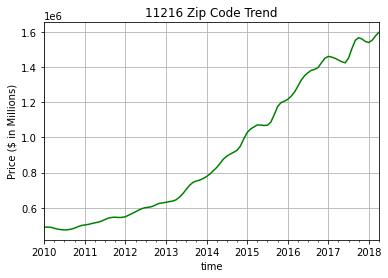

In [21]:
# look for trend
plot_trend(ts_final[11216], '11216 Zip Code Trend')

Here we are looking at the overall movement for zip code 11216.

## Stationarity Check & Removing Trends

Checking for stationary in our data. Since we have a trend in our data, we need to remove it in order to pass our data into our models. Removing stationarity will help remove all the noisy components in our data. The way we check for stationarity is using the Dickey-Fuller Test. If the p-value is less than .05 then it passes the stationarity check.

To choose which way we will be removing trends is by:

- Taking the log transformation
- Subtracting the rolling mean
- Differencing (subtracting the previous value to the current value)

We will compare all p-values to see which is the most efficient way of removing trends

In [22]:
# dickey fuller test 1
test1 = adfuller(ts_final[11216])
pd.DataFrame(test1[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

Results
Test Statistic                0.129346
p-value                       0.968008
#Lags Used                    9.000000
Number of Observations Used  90.000000

In [23]:
# difference from lag
difference = adfuller(ts_final[11216].diff().dropna())
pd.DataFrame(difference[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

Results
Test Statistic               -2.196588
p-value                       0.207486
#Lags Used                    8.000000
Number of Observations Used  90.000000

In [24]:
# log transformation
log_transform = adfuller(np.log(ts_final[11216]))
pd.DataFrame(log_transform[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

Results
Test Statistic               -0.977856
p-value                       0.761255
#Lags Used                    9.000000
Number of Observations Used  90.000000

In [25]:
# difference from rolling mean
roll_mean = ts_final[11216].rolling(window=12).mean()
mean_diff = ts_final[11216] - roll_mean
mean_diff.dropna(inplace=True)
results = adfuller(mean_diff)
pd.DataFrame(results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

Results
Test Statistic               -1.449179
p-value                       0.558485
#Lags Used                   10.000000
Number of Observations Used  78.000000

In [26]:
final_results = test1[0:4], difference[0:4], log_transform[0:4], results[0:4]

In [27]:
pd.DataFrame(final_results, columns = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic   p-value  #Lags Used  Number of Observations Used
0        0.129346  0.968008           9                           90
1       -2.196588  0.207486           8                           90
2       -0.977856  0.761255           9                           90
3       -1.449179  0.558485          10                           78

Based on our results, differencing has the lowest p-value. But our data is not stationary.

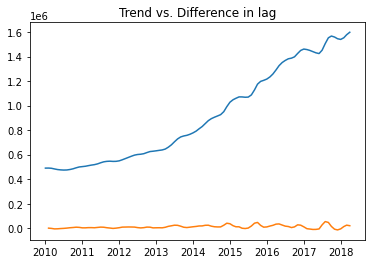

In [28]:
plt.title('Trend vs. Difference in lag')
plt.plot(ts_final[11216])
plt.plot(ts_final[11216].diff().dropna())
plt.show()

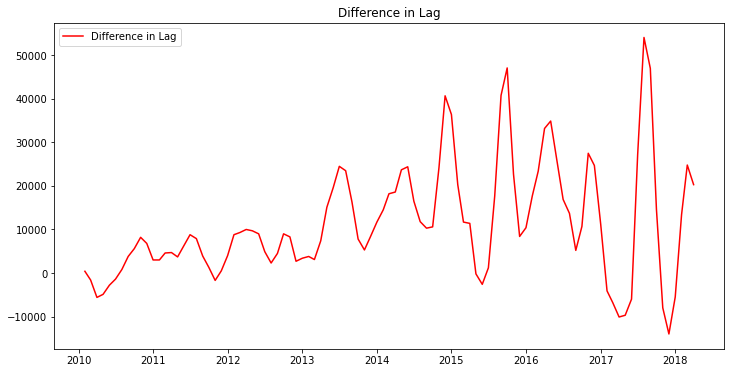

Results of Dickey-Fuller Test: 

                               Results
Test Statistic               -2.196588
p-value                       0.207486
#Lags Used                    8.000000
Number of Observations Used  90.000000


In [29]:
stationarity_check(ts_final[11216])

Observing for seasonality which will look for the consistent yearly pattern within the zip code 11216

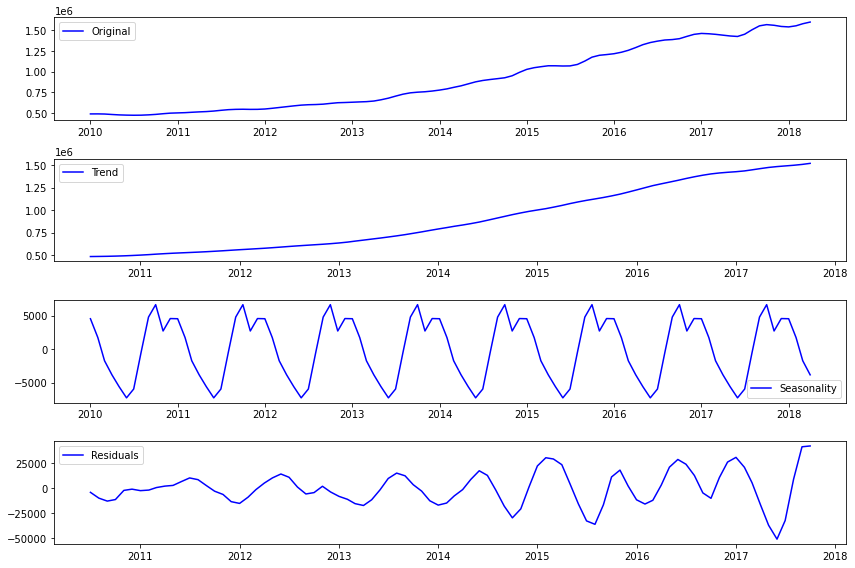

In [30]:
# looking at seasonality
decomposition = seasonal_decompose(ts_final[11216])

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts_final[11216], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()


## ACF & PACF

We are looking at the correlation between the data and the shifted data. This is used for our forecasting.

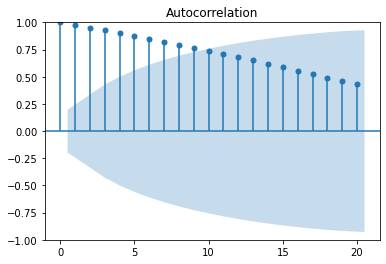

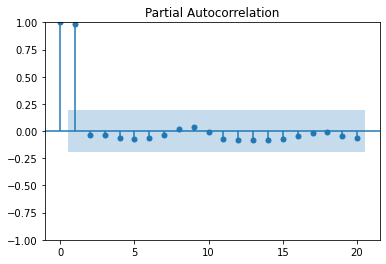

In [31]:
plot_acf(ts_final[11216][:-1], alpha=.05)
plt.show()

plot_pacf(ts_final[11216][:-1], alpha = .05)
plt.show()

**Note:**

ACF & PACF has two significant lag

# Testing Zip Code 11216

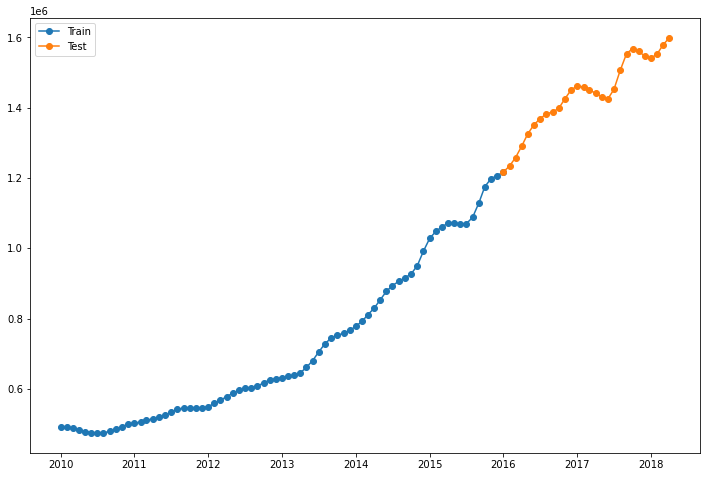

In [32]:
# test-train-split by hand
# train years 2013 - 2017
# test years 2017-2018

# Train - Test - Split
train = ts_final[11216][:'2016-01-01']
test = ts_final[11216]['2016-01-01':]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend();

In [33]:
print(min(train.index))
print(min(test.index))

2010-01-01 00:00:00
2016-01-01 00:00:00


## Model Test 1 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -733.380
Date:                Mon, 14 Mar 2022   AIC                           1476.760
Time:                        12:07:04   BIC                           1488.073
Sample:                    01-01-2010   HQIC                          1481.259
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4461      0.440      3.284      0.001       0.583       2.309
ar.L2         -0.5232      0.389     -1.346      0.178      -1.285       0.239
ma.L1         -1.5565      0.456     -3.414      0.001      -2.450      -0.663
ma.L2          0.5565      0.448      1.243      0.214      -0.321       1.434
sigma2      2.068e+07   3.41e-08   6.07e+14      0.000    2.07e+07    2.07e+07
===================================================================================
Ljung-Box (L1) (Q):                  14.33   Jarque-Bera (JB):                35.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.21   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.36e+30. Standard errors may be unstable.
"""

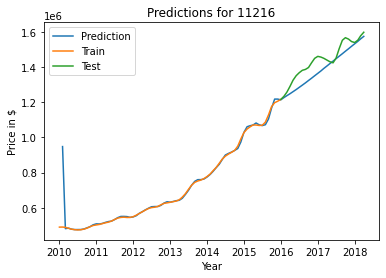

In [34]:
# order = (p, d, q)
# p - autoregressive
# d - differences
# q - moving average

ar1 = ARIMA(train, order=(2,2,2)).fit()
model_validation(ar1, ts_final, 11216)

## Model Test 2

In [35]:
# provided by study group
# Iterating through p, d, q values.
# getting the optimal arima iterations
p = q = (0,1,2,3)
diff = 0

combo, value = (None, None)
for ar in p:
    for ma in q:
        try:
            model = ARIMA(train, order=(ar, diff, ma)).fit()
            print('Combo:', (ar, diff, ma),'AIC:', model.aic)

            if value is None or model.aic < value:
                combo, value = ((ar, diff, ma), model.aic)
                print(f'\tBest Parameters Updated')
        except ValueError:
            pass
            
print(f'\n{"*"*20}\nOptimal ARIMA order: {combo}')

Combo: (0, 0, 0) AIC: 2252.191397273479
	Best Parameters Updated
Combo: (0, 0, 1) AIC: 1961.9818725418081
	Best Parameters Updated
Combo: (0, 0, 2) AIC: 1951.033582049747
	Best Parameters Updated
Combo: (0, 0, 3) AIC: 1947.8026493646116
	Best Parameters Updated
Combo: (1, 0, 0) AIC: 1619.8866305756244
	Best Parameters Updated
Combo: (1, 0, 1) AIC: 1538.4402487179234
	Best Parameters Updated
Combo: (1, 0, 2) AIC: 1478.9632198513
	Best Parameters Updated
Combo: (1, 0, 3) AIC: 1467.0841543943995
	Best Parameters Updated
Combo: (2, 0, 0) AIC: 1507.5720626970785
Combo: (2, 0, 1) AIC: 1472.5782352560325
Combo: (2, 0, 2) AIC: 1461.1502882251762
	Best Parameters Updated
Combo: (2, 0, 3) AIC: 1477.246208643279
Combo: (3, 0, 0) AIC: 1577.3813497998242
Combo: (3, 0, 1) AIC: 1489.7260649487732
Combo: (3, 0, 2) AIC: 1456.8668800551823
	Best Parameters Updated
Combo: (3, 0, 3) AIC: 1447.890235125815
	Best Parameters Updated

********************
Optimal ARIMA order: (3, 0, 3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -715.945
Date:                Mon, 14 Mar 2022   AIC                           1447.890
Time:                        12:07:06   BIC                           1466.214
Sample:                    01-01-2010   HQIC                          1455.193
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.201e+05   1.59e-08   4.53e+13      0.000     7.2e+05     7.2e+05
ar.L1          2.0566      0.144     14.286      0.000       1.774       2.339
ar.L2         -1.1236      0.256     -4.385      0.000      -1.626      -0.621
ar.L3          0.0667      0.114      0.586      0.558      -0.156       0.290
ma.L1          0.7949      0.241      3.295      0.001       0.322       1.268
ma.L2         -0.5586      0.263     -2.126      0.034      -1.074      -0.044
ma.L3         -0.9126      0.140     -6.518      0.000      -1.187      -0.638
sigma2      1.584e+07   1.71e-08   9.29e+14      0.000    1.58e+07    1.58e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.69
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              14.33   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.55e+32. Standard errors may be unstable.
"""

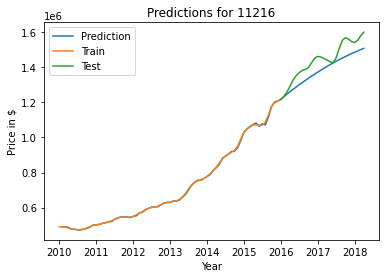

In [36]:
arima_iteration = ARIMA(train, order=(3,0,3)).fit()
model_validation(arima_iteration, ts_final, 11216)

## Model Test 3 Auto Arima Chosen Model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1587.365, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1737.683, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1591.992, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1542.826, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1561.154, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1557.133, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1543.581, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.347 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -769.413
Date:                Mon, 14 Mar 2022   AIC                           1542.826
Time:                        12:07:07   BIC                           1547.380
Sample:                             0   HQIC                          1544.639
                                 - 73                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.009e+04   1729.745      5.833      0.000    6700.039    1.35e+04
sigma2      1.121e+08   1.79e+07      6.246      0.000    7.69e+07    1.47e+08
===================================================================================
Ljung-Box (L1) (Q):                  47.08   Jarque-Bera (JB):                38.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             1.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

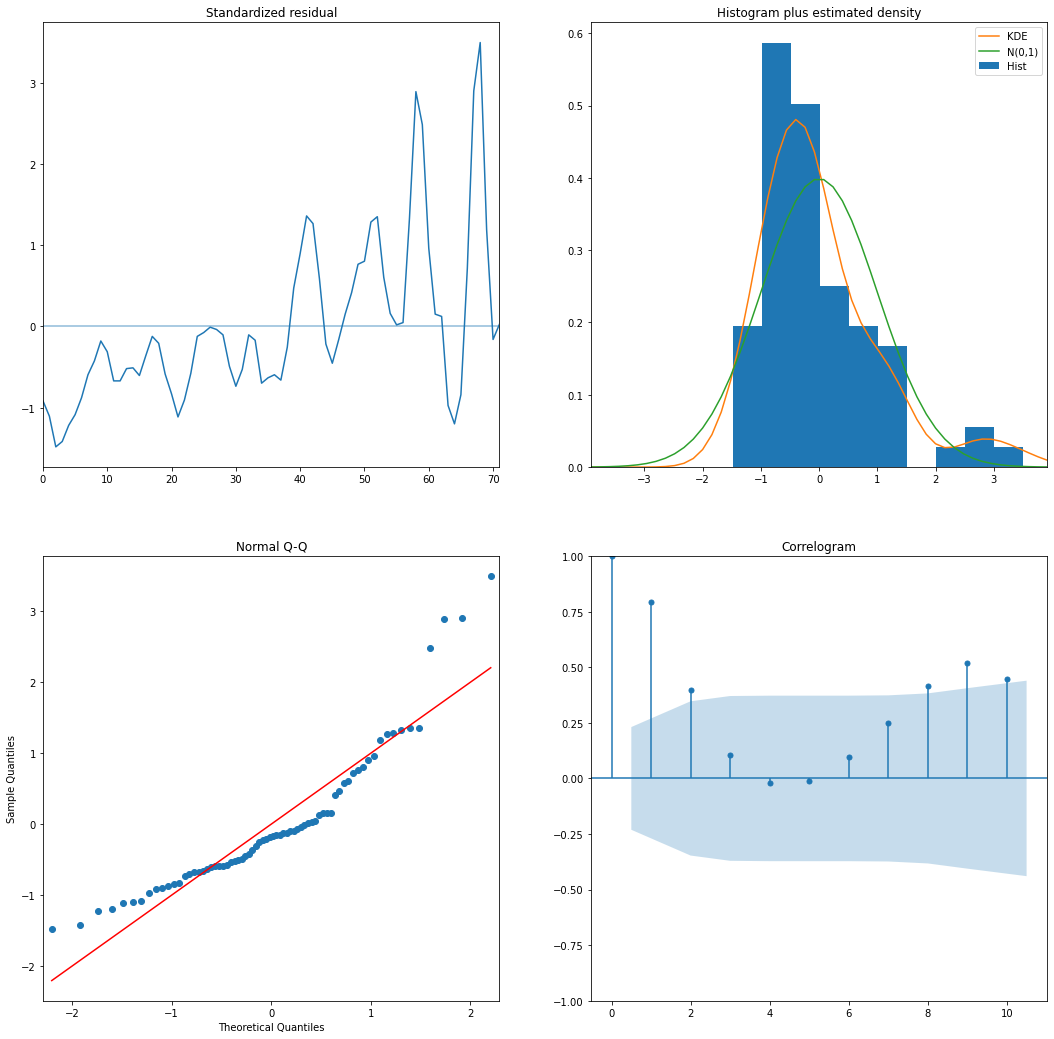

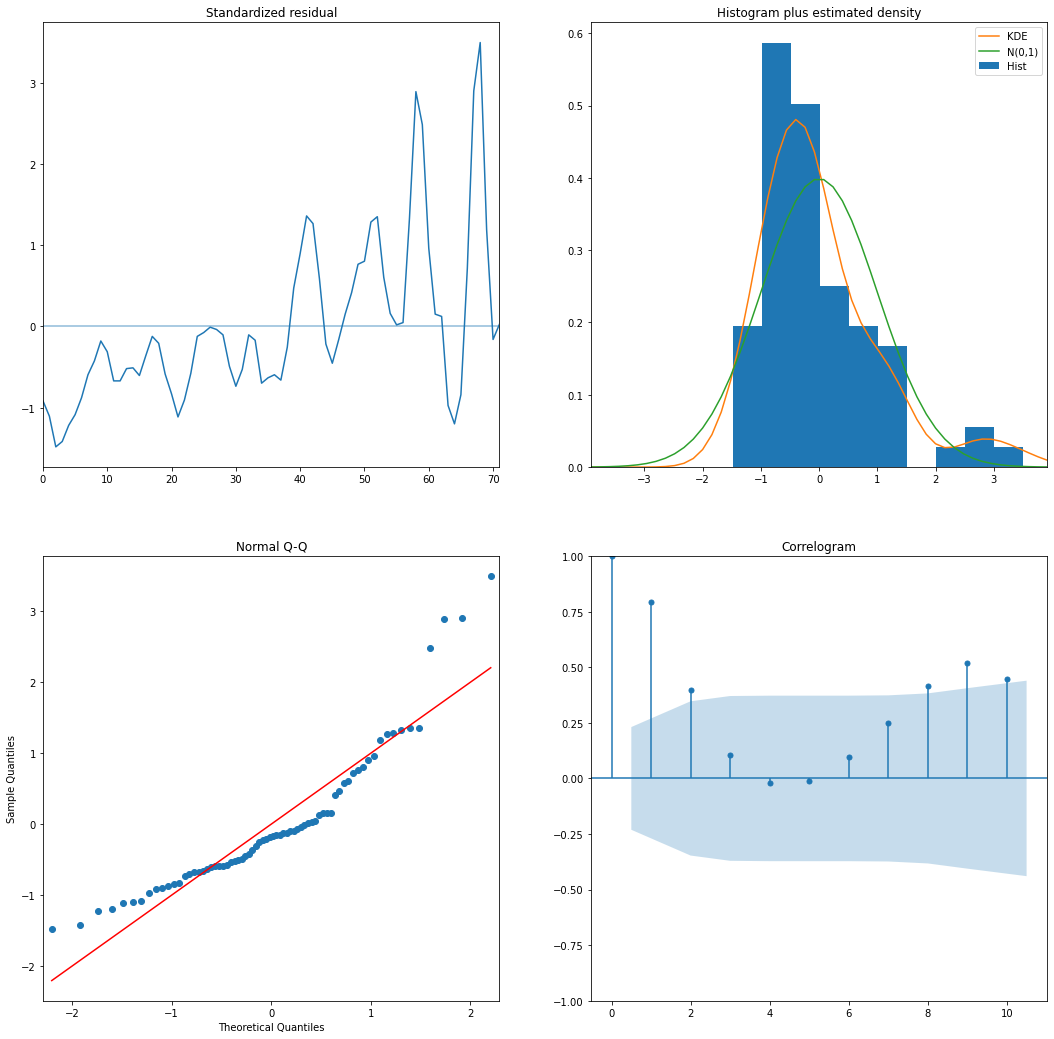

In [37]:
auto = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     max_d=2,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False,
                     enforce_stationarity=False, 
                     enforce_invertibility=False)

display(auto.summary())
display(auto.plot_diagnostics(figsize=(18,18)))

In [38]:
auto.order

(0, 1, 0)

In [39]:
auto.seasonal_order

(0, 0, 0, 0)

## Testing Our Auto Arima Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1105.892
Date:                Mon, 14 Mar 2022   AIC                           2213.783
Time:                        12:07:07   BIC                           2216.379
Sample:                    01-01-2010   HQIC                          2214.833
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.923e+08   3.36e+07      8.706      0.000    2.26e+08    3.58e+08
===================================================================================
Ljung-Box (L1) (Q):                  56.02   Jarque-Bera (JB):                17.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.21   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

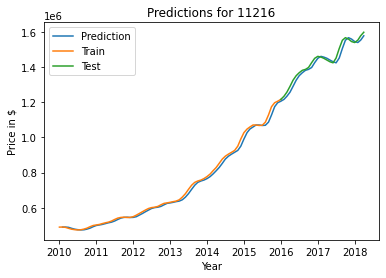

In [40]:
auto_sarimax = SARIMAX(
    ts_final[11216],
    order=auto.order, seasonal_order = auto.seasonal_order).fit()
model_validation(auto_sarimax, ts_final, 11216)

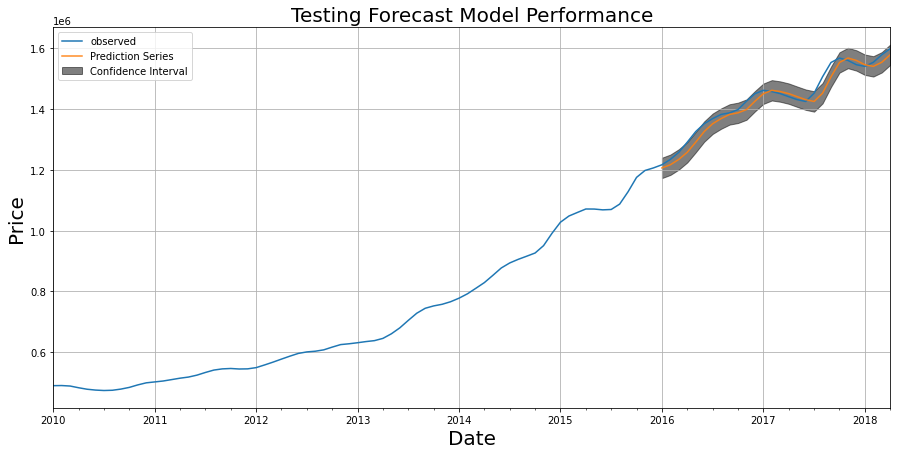

In [41]:
prediction_test(auto_sarimax, ts_final, 11216)

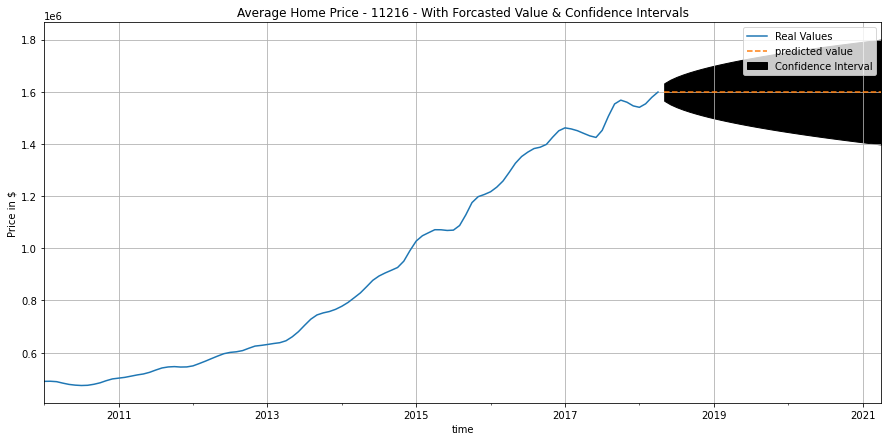

In [42]:
forecast_test(auto_sarimax, ts_final, 11216, 36)

## Model Test 4

In [43]:
# Setting up parameter combinations.
# code from study group
p = d = q = (0, 2)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

# Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            train, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 2155.799897756573
SARIMA Combos: ((0, 0, 0), (0, 2, 0, 12)) AIC: 1195.4089097646597
SARIMA Combos: ((0, 0, 0), (0, 2, 2, 12)) AIC: 588.461713644316
SARIMA Combos: ((0, 0, 0), (2, 2, 2, 12)) AIC: 576.1727138910064
SARIMA Combos: ((0, 0, 2), (0, 2, 2, 12)) AIC: 529.9006128121522
SARIMA Combos: ((0, 2, 0), (0, 2, 2, 12)) AIC: 499.25607377037784
SARIMA Combos: ((0, 2, 0), (2, 2, 2, 12)) AIC: 492.3506373536708
SARIMA Combos: ((0, 2, 2), (0, 2, 2, 12)) AIC: 448.0646131825706
SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 435.3264048427279

********************
Optimal SARIMA order: ((2, 2, 2), (0, 2, 2, 12))


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -673.963
Date:                Mon, 14 Mar 2022   AIC                           1357.926
Time:                        12:07:35   BIC                           1369.023
Sample:                    01-01-2010   HQIC                          1362.323
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7843      0.112      7.016      0.000       0.565       1.003
ar.L2         -0.6566      0.060    -10.911      0.000      -0.775      -0.539
ma.L1         -0.0534      0.153     -0.349      0.727      -0.353       0.246
ma.L2         -0.0022      0.061     -0.036      0.972      -0.121       0.117
sigma2      2.052e+07   5.63e-09   3.65e+15      0.000    2.05e+07    2.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.52
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              13.37   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

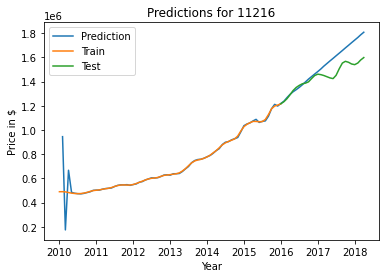

In [44]:
sarimax1 = SARIMAX(
    train,
    order=(2,2,2),
    seasonality_order=(0,2,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False, 
    trace=True).fit()
model_validation(sarimax1, ts_final, 11216)

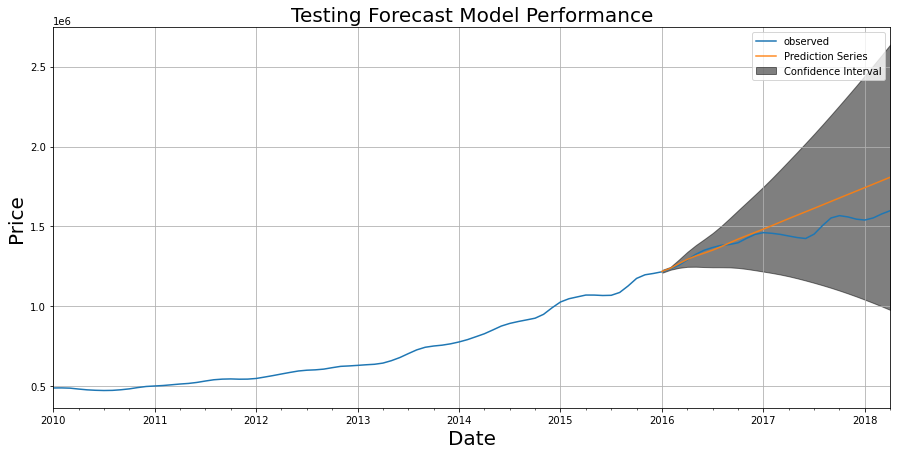

In [45]:
prediction_test(sarimax1, ts_final, 11216)

# Forecasting the Future

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                  100
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1026.555
Date:                Mon, 14 Mar 2022   AIC                           2063.111
Time:                        12:07:36   BIC                           2076.036
Sample:                    01-01-2010   HQIC                          2068.339
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4778      0.199      7.418      0.000       1.087       1.868
ar.L2         -0.5877      0.150     -3.920      0.000      -0.881      -0.294
ma.L1         -2.5029      0.214    -11.706      0.000      -2.922      -2.084
ma.L2          1.5023      0.483      3.111      0.002       0.556       2.449
sigma2      3.218e+07   1.95e-08   1.65e+15      0.000    3.22e+07    3.22e+07
===================================================================================
Ljung-Box (L1) (Q):                  25.44   Jarque-Bera (JB):                25.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.58   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.56e+30. Standard errors may be unstable.
"""

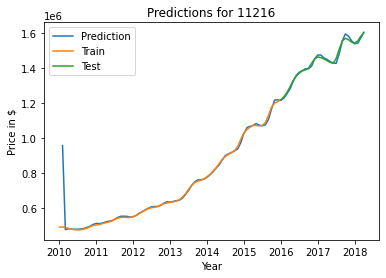

In [46]:
sarimax_11216 = SARIMAX(
    ts_final[11216],
    order=(2,2,2),
    seasonality_order=(0,2,2,12),
    enforce_stationarity=True,
    enforce_invertibility=False, 
    trace=True).fit()
model_validation(sarimax_11216, ts_final, 11216)

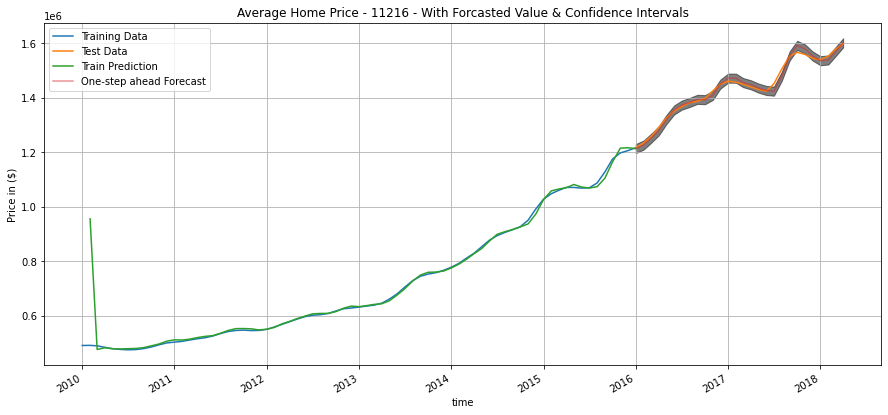

In [47]:
forecast_future(sarimax_11216, ts_final[11216], '11216')

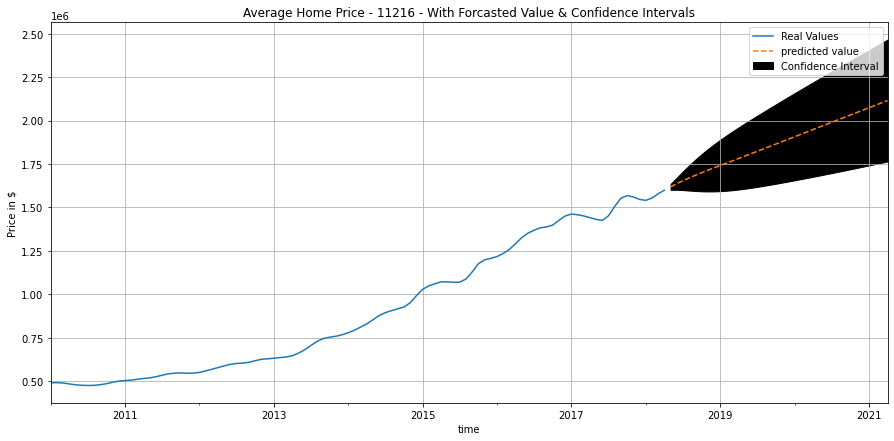

In [48]:
forecast_test(sarimax_11216, ts_final, 11216, 36)

In [49]:
# Getting metric results for our model
def metric_report(test, predict):
    print("Explained Variance:\n\t", metrics.explained_variance_score(test, predict))
    print("MAE:\n\t", metrics.mean_absolute_error(test, predict))
    print("RMSE:\n\t", metrics.mean_squared_error(test, predict, squared=False))
    print("r^2:\n\t", metrics.r2_score(test, predict))

In [50]:
pred = auto_sarimax.predict(start=pd.to_datetime('2016-01-01'), 
          end=pd.to_datetime('2018-04-01'), dynamic = False)

In [51]:
metric_report(test, pred)

Explained Variance:
	 0.9726760945846664
MAE:
	 18600.0
RMSE:
	 22310.51961999733
r^2:
	 0.9548686982692628


# All Zip Codes

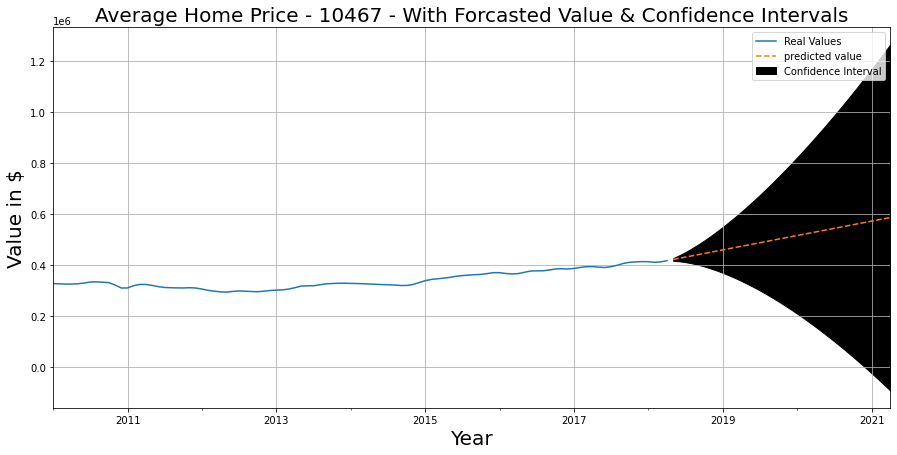

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10467   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -906.061
Date:                Mon, 14 Mar 2022   AIC                           1814.122
Time:                        12:07:37   BIC                           1816.696
Sample:                    01-01-2010   HQIC                          1815.163
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.398e+06   6.35e+05     11.644      0.000    6.15e+06    8.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.61   Jarque-Bera (JB):                49.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.67
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9729080656985487
MAE:
	 2350.0
RMSE:
	 2644.2660337308835
r^2:
	 0.9729031226726071


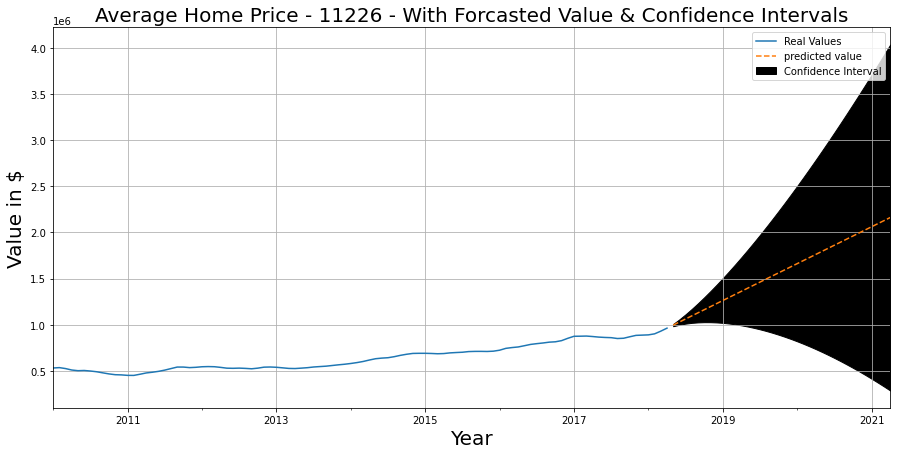

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11226   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -984.787
Date:                Mon, 14 Mar 2022   AIC                           1973.574
Time:                        12:07:38   BIC                           1978.724
Sample:                    01-01-2010   HQIC                          1975.657
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1803      0.106      1.702      0.089      -0.027       0.388
sigma2      3.853e+07   4.25e-10   9.07e+16      0.000    3.85e+07    3.85e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 5.14
Prob(Q):                              0.46   Prob(JB):                         0.08
Heteroskedasticity (H):               1.65   Skew:                            -0.28
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.978407831597195
MAE:
	 6586.304307945991
RMSE:
	 8405.351257080389
r^2:
	 0.9781833798575194


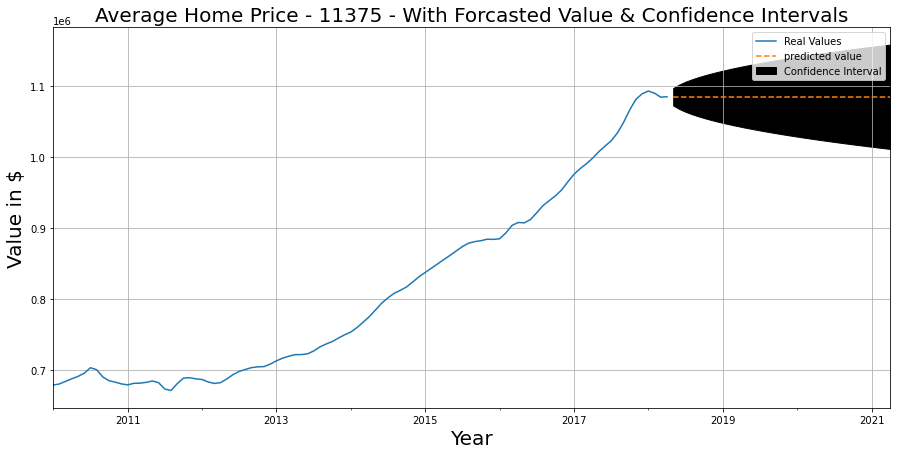

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11375   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -996.426
Date:                Mon, 14 Mar 2022   AIC                           1994.853
Time:                        12:07:38   BIC                           1997.438
Sample:                    01-01-2010   HQIC                          1995.898
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.894e+07   6.08e+06      6.402      0.000     2.7e+07    5.09e+07
===================================================================================
Ljung-Box (L1) (Q):                  57.84   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               3.45   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9943616470072243
MAE:
	 7821.428571428572
RMSE:
	 8827.635179205292
r^2:
	 0.9834820221471763


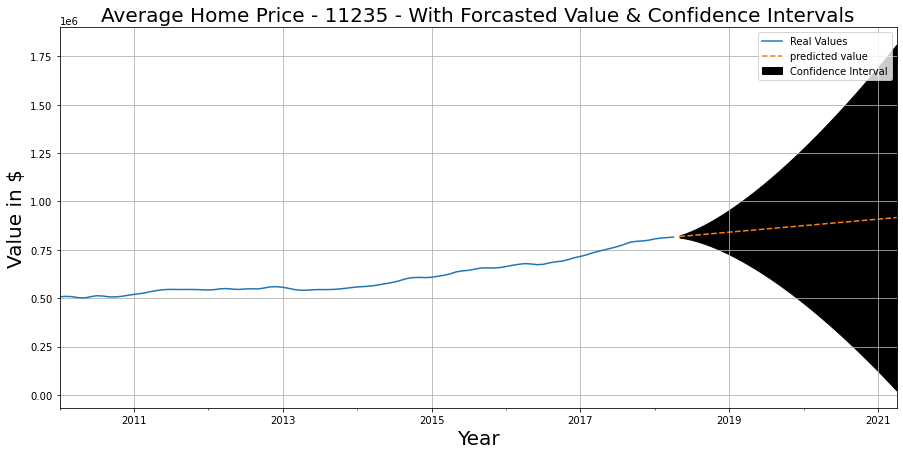

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11235   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -908.195
Date:                Mon, 14 Mar 2022   AIC                           1820.390
Time:                        12:07:39   BIC                           1825.539
Sample:                    01-01-2010   HQIC                          1822.472
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2229      0.099      2.254      0.024       0.029       0.417
sigma2      7.943e+06   1.17e+06      6.800      0.000    5.65e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.65   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.20   Prob(JB):                         0.95
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9968843963905965
MAE:
	 2310.0541367948586
RMSE:
	 2941.072410457742
r^2:
	 0.9968843775414664


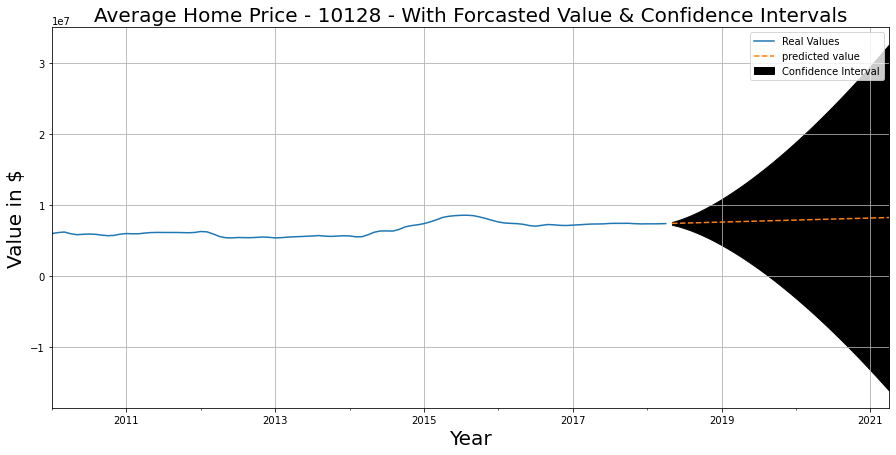

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10128   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1253.069
Date:                Mon, 14 Mar 2022   AIC                           2508.137
Time:                        12:07:40   BIC                           2510.712
Sample:                    01-01-2010   HQIC                          2509.178
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.482e+09    1.1e+09      8.600      0.000    7.32e+09    1.16e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.69   Jarque-Bera (JB):                 3.42
Prob(Q):                              0.02   Prob(JB):                         0.18
Heteroskedasticity (H):               0.36   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.7358299973561002
MAE:
	 47189.28571428572
RMSE:
	 66812.62979407412
r^2:
	 0.7300344668432611


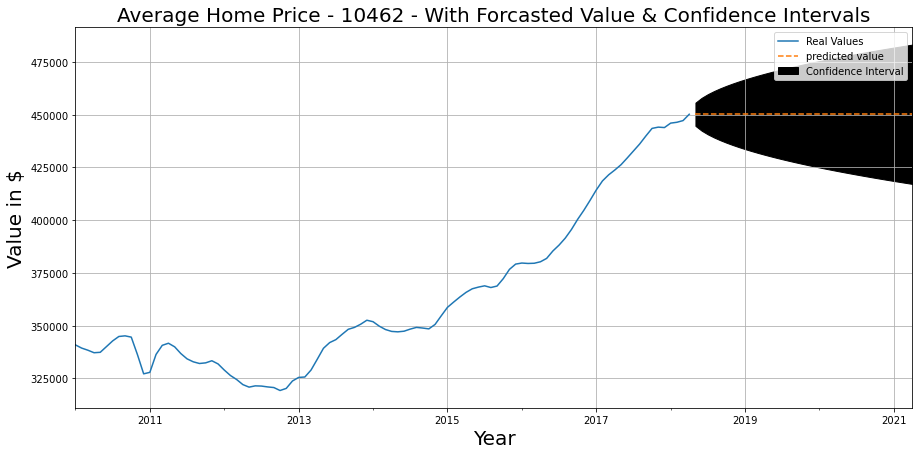

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10462   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -918.057
Date:                Mon, 14 Mar 2022   AIC                           1838.114
Time:                        12:07:40   BIC                           1840.699
Sample:                    01-01-2010   HQIC                          1839.160
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.885e+06    9.2e+05      8.570      0.000    6.08e+06    9.69e+06
===================================================================================
Ljung-Box (L1) (Q):                  47.32   Jarque-Bera (JB):                41.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.81
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9959284737819479
MAE:
	 2564.285714285714
RMSE:
	 2995.4727745144246
r^2:
	 0.9856338668836873


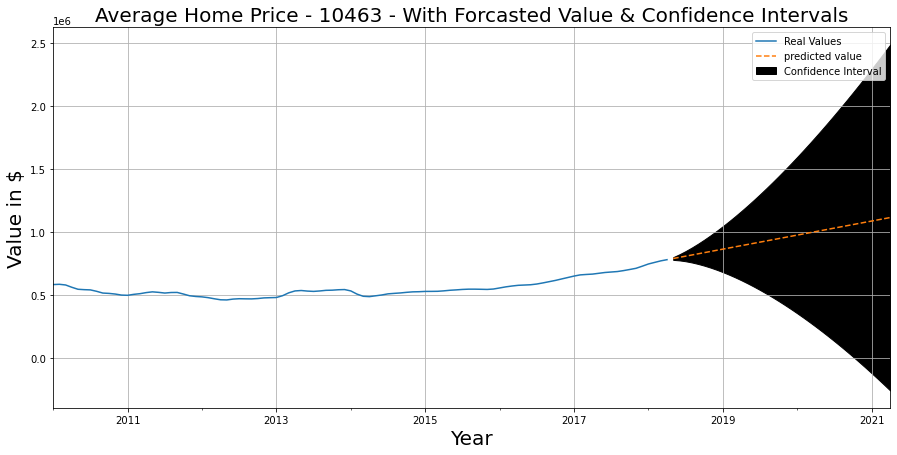

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10463   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -973.741
Date:                Mon, 14 Mar 2022   AIC                           1949.481
Time:                        12:07:41   BIC                           1952.056
Sample:                    01-01-2010   HQIC                          1950.522
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.032e+07   3.68e+06      8.234      0.000    2.31e+07    3.75e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.36   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.02   Prob(JB):                         0.32
Heteroskedasticity (H):               0.19   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.998030415258252
MAE:
	 2096.4285714285716
RMSE:
	 2900.9234982772546
r^2:
	 0.9980192440014531


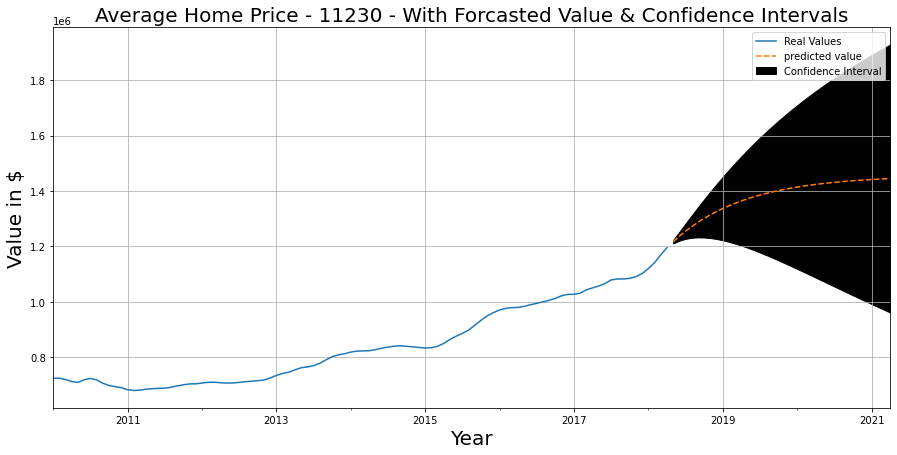

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               11230   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -809.547
Date:                             Mon, 14 Mar 2022   AIC                           1627.094
Time:                                     12:07:45   BIC                           1636.912
Sample:                                 01-01-2010   HQIC                          1631.045
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9167      0.060     15.214      0.000       0.799       1.035
ma.L1          0.4202      0.156      2.695      0.007       0.115       0.726
ar.S.L12       0.0022      0.037      0.058      0.954      -0.071       0.075
sigma2      1.047e+07   6.46e-09   1.62e+15      0.000    1.05e+07    1.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 8.93
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               3.71   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.66e+31. Standard errors may be unstable.
"""

Explained Variance:
	 0.9956101807106125
MAE:
	 3208.572657120722
RMSE:
	 4008.3339543853544
r^2:
	 0.9954272231060851


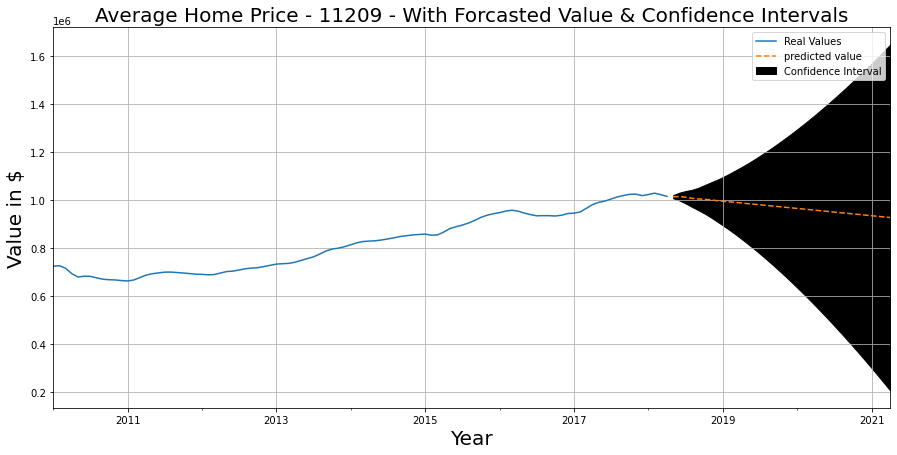

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11209   No. Observations:                  100
Model:               SARIMAX(3, 2, 3)   Log Likelihood                -889.257
Date:                Mon, 14 Mar 2022   AIC                           1792.514
Time:                        12:07:50   BIC                           1810.317
Sample:                    01-01-2010   HQIC                          1799.705
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6202      0.184     -3.365      0.001      -0.981      -0.259
ar.L2         -0.4927      0.279     -1.764      0.078      -1.040       0.055
ar.L3         -0.4692      0.197     -2.377      0.017      -0.856      -0.082
ma.L1          1.1460      0.283      4.052      0.000       0.592       1.700
ma.L2          0.1666      0.391      0.426      0.670      -0.599       0.932
ma.L3          0.1556      0.247      0.629      0.529      -0.329       0.640
sigma2      8.838e+06   2.95e-08      3e+14      0.000    8.84e+06    8.84e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.02
Prob(Q):                              0.88   Prob(JB):                         0.05
Heteroskedasticity (H):               3.16   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+31. Standard errors may be unstable.
"""

Explained Variance:
	 0.986445746381727
MAE:
	 3345.4912728816353
RMSE:
	 4166.37270284966
r^2:
	 0.986302429371633


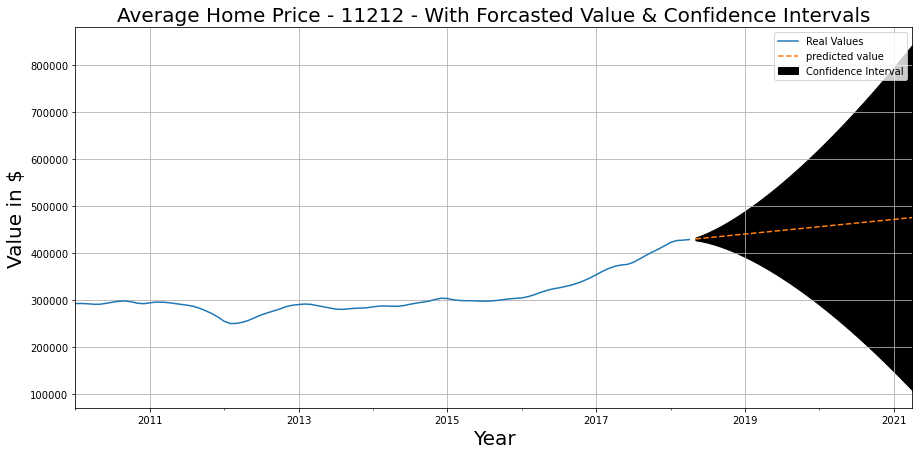

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11212   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -845.404
Date:                Mon, 14 Mar 2022   AIC                           1692.808
Time:                        12:07:50   BIC                           1695.383
Sample:                    01-01-2010   HQIC                          1693.849
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.175e+06    2.5e+05      8.708      0.000    1.69e+06    2.66e+06
===================================================================================
Ljung-Box (L1) (Q):                  23.09   Jarque-Bera (JB):                 8.47
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.65   Skew:                             0.47
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9986127935106432
MAE:
	 1185.7142857142858
RMSE:
	 1484.2025275740311
r^2:
	 0.9986127613807882


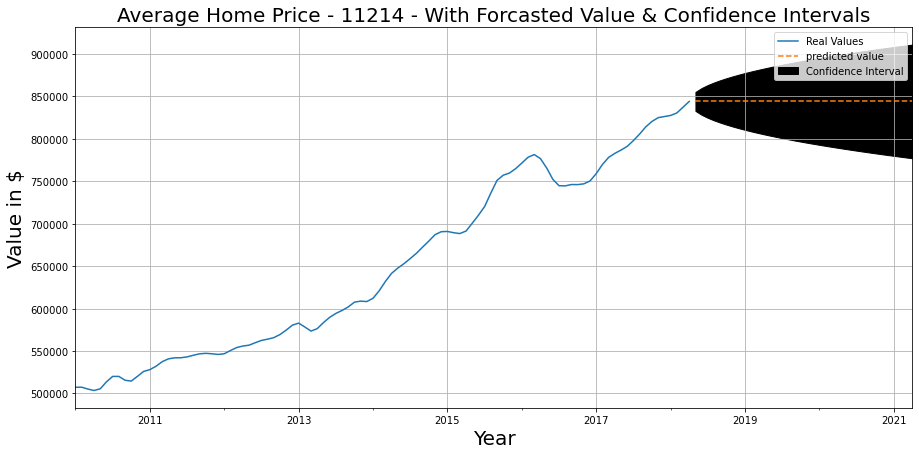

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11214   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -987.513
Date:                Mon, 14 Mar 2022   AIC                           1977.027
Time:                        12:07:51   BIC                           1979.612
Sample:                    01-01-2010   HQIC                          1978.072
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.244e+07   4.78e+06      6.786      0.000    2.31e+07    4.18e+07
===================================================================================
Ljung-Box (L1) (Q):                  56.89   Jarque-Bera (JB):                21.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.59   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.966489147780743
MAE:
	 5471.428571428572
RMSE:
	 6421.615284112157
r^2:
	 0.9584222462444123


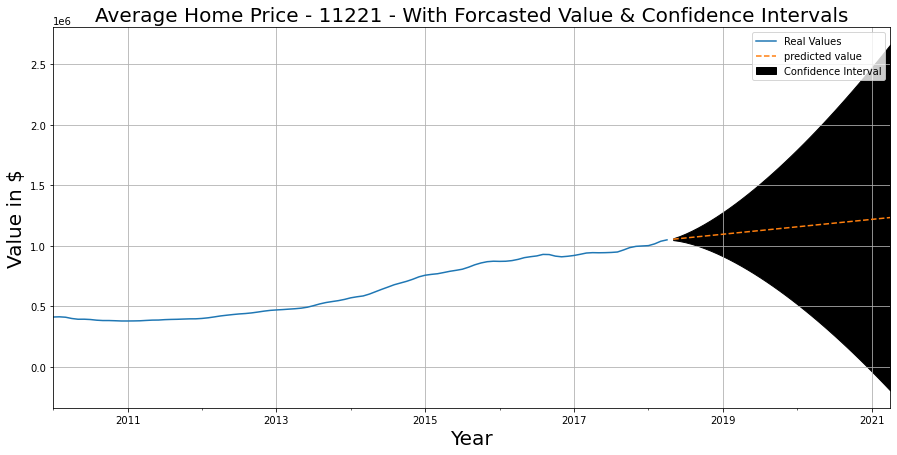

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11221   No. Observations:                  100
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -926.583
Date:                Mon, 14 Mar 2022   AIC                           1859.166
Time:                        12:07:52   BIC                           1866.828
Sample:                    01-01-2010   HQIC                          1862.262
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5000      0.084      5.918      0.000       0.334       0.666
ma.L2          0.0370      0.050      0.743      0.458      -0.061       0.135
sigma2      1.437e+07   3.48e-09   4.12e+15      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                39.96
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):              10.47   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.54e+30. Standard errors may be unstable.
"""

Explained Variance:
	 0.9818784384169627
MAE:
	 4834.070685161448
RMSE:
	 6340.539950329582
r^2:
	 0.9818745304325709


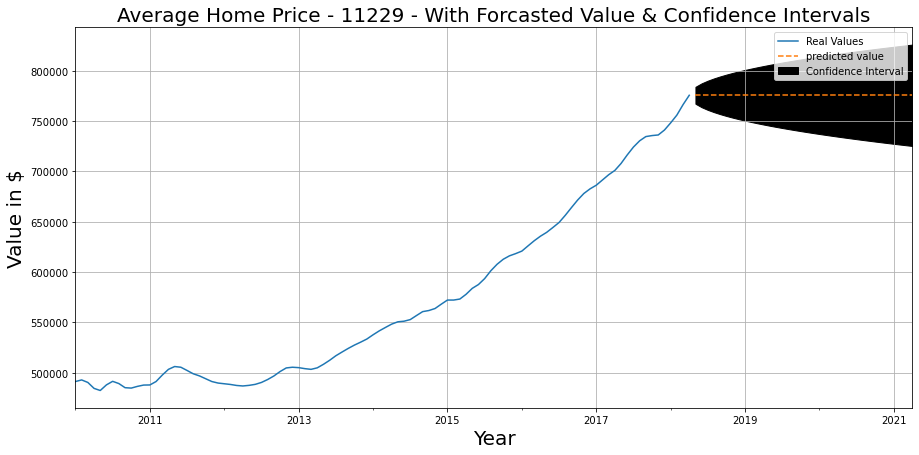

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11229   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -959.451
Date:                Mon, 14 Mar 2022   AIC                           1920.901
Time:                        12:07:53   BIC                           1923.486
Sample:                    01-01-2010   HQIC                          1921.947
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.832e+07   3.33e+06      5.510      0.000    1.18e+07    2.48e+07
===================================================================================
Ljung-Box (L1) (Q):                  60.86   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):               3.73   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9975290180241242
MAE:
	 5614.285714285715
RMSE:
	 6045.718674046477
r^2:
	 0.982046322829818


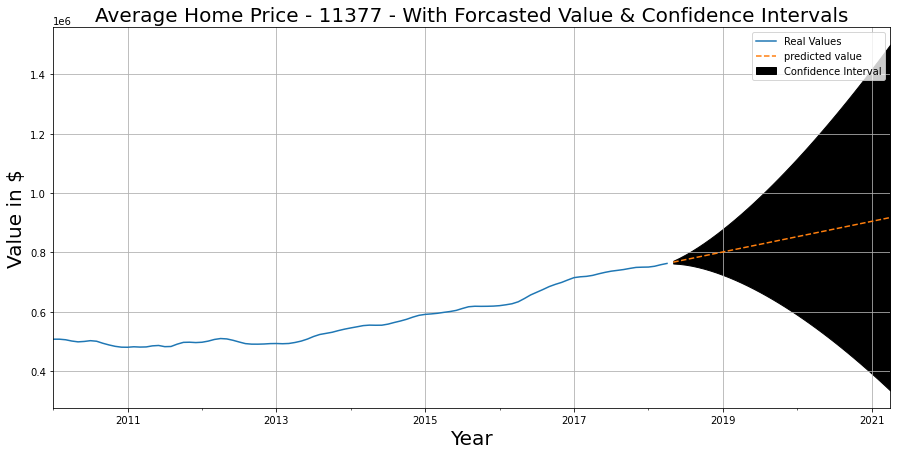

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11377   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -891.029
Date:                Mon, 14 Mar 2022   AIC                           1784.058
Time:                        12:07:53   BIC                           1786.633
Sample:                    01-01-2010   HQIC                          1785.099
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.466e+06   7.37e+05      7.417      0.000    4.02e+06    6.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.10   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.00   Prob(JB):                         0.80
Heteroskedasticity (H):               0.41   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.998064204017846
MAE:
	 1560.7142857142858
RMSE:
	 1973.8468604659859
r^2:
	 0.9980554889476199


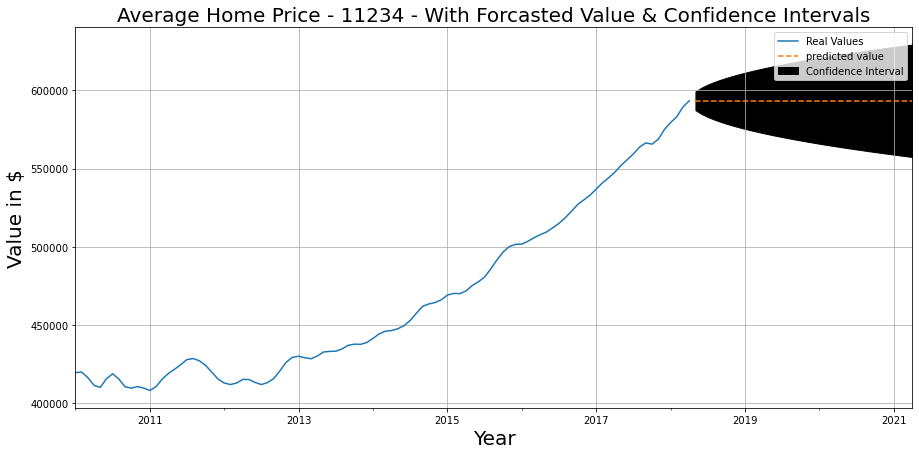

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11234   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -926.423
Date:                Mon, 14 Mar 2022   AIC                           1854.846
Time:                        12:07:54   BIC                           1857.431
Sample:                    01-01-2010   HQIC                          1855.891
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.328e+06   1.91e+06      4.886      0.000    5.59e+06    1.31e+07
===================================================================================
Ljung-Box (L1) (Q):                  47.75   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.44   Skew:                            -0.72
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9972142219464005
MAE:
	 3332.1428571428573
RMSE:
	 3588.622895445311
r^2:
	 0.9833336312854548


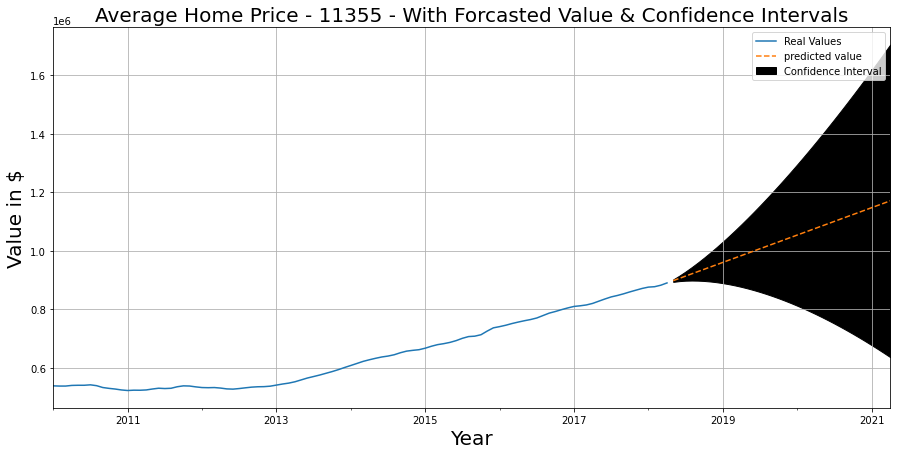

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11355   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -881.655
Date:                Mon, 14 Mar 2022   AIC                           1765.310
Time:                        12:07:55   BIC                           1767.885
Sample:                    01-01-2010   HQIC                          1766.351
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.591e+06   5.08e+05      9.039      0.000     3.6e+06    5.59e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.28   Prob(JB):                         0.02
Heteroskedasticity (H):               1.41   Skew:                            -0.05
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9977499553020599
MAE:
	 1560.7142857142858
RMSE:
	 2155.30905970748
r^2:
	 0.9977432071570888


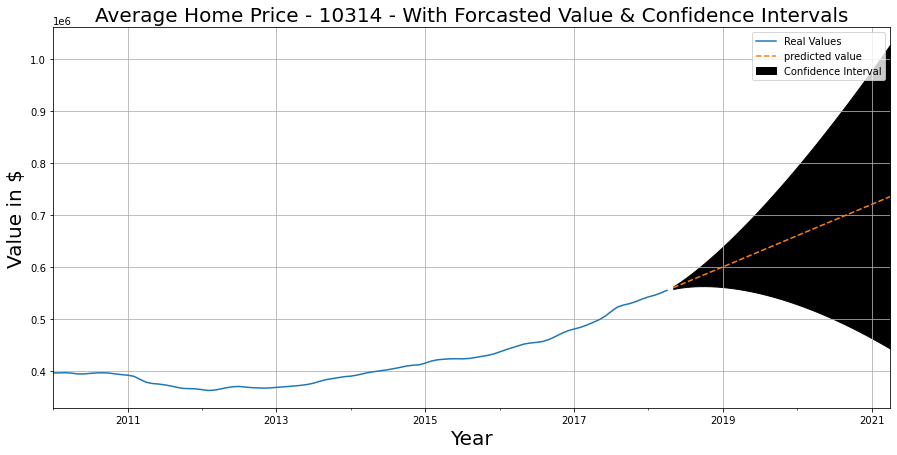

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10314   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -822.939
Date:                Mon, 14 Mar 2022   AIC                           1647.879
Time:                        12:07:55   BIC                           1650.453
Sample:                    01-01-2010   HQIC                          1648.920
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.368e+06   1.36e+05     10.097      0.000     1.1e+06    1.63e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.95   Jarque-Bera (JB):                24.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.46
Prob(H) (two-sided):                  0.90   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9985943714233857
MAE:
	 1096.4285714285713
RMSE:
	 1397.829950826842
r^2:
	 0.9985895005836904


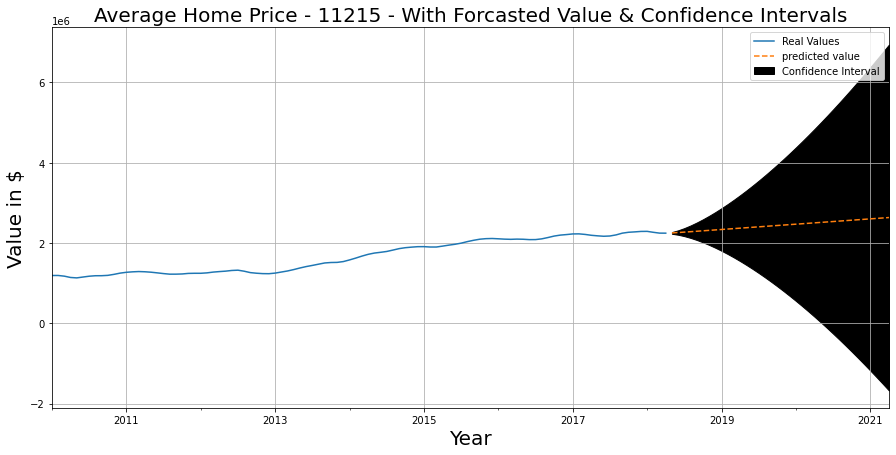

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11215   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1039.735
Date:                Mon, 14 Mar 2022   AIC                           2083.470
Time:                        12:07:56   BIC                           2088.620
Sample:                    01-01-2010   HQIC                          2085.553
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3825      0.093      4.116      0.000       0.200       0.565
sigma2      1.196e+08   5.65e-11   2.12e+18      0.000     1.2e+08     1.2e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.02   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.08   Prob(JB):                         0.99
Heteroskedasticity (H):               0.89   Skew:                             0.03
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Explained Variance:
	 0.9700232308100897
MAE:
	 9906.445687069583
RMSE:
	 11751.925038092084
r^2:
	 0.9700053122891373


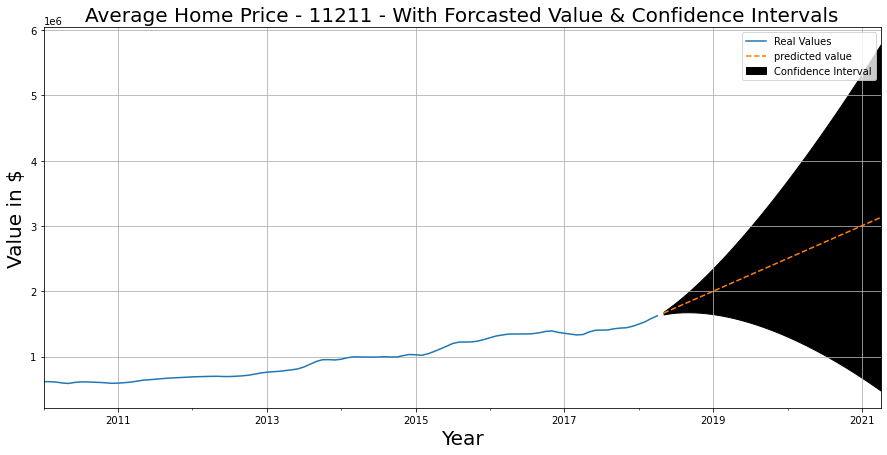

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11211   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1038.286
Date:                Mon, 14 Mar 2022   AIC                           2078.573
Time:                        12:07:56   BIC                           2081.147
Sample:                    01-01-2010   HQIC                          2079.614
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.127e+08   1.26e+07      8.931      0.000     8.8e+07    1.37e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.46   Jarque-Bera (JB):                 4.91
Prob(Q):                              0.02   Prob(JB):                         0.09
Heteroskedasticity (H):               4.57   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9722914950610397
MAE:
	 10028.57142857143
RMSE:
	 13125.248296971104
r^2:
	 0.9722278001847645


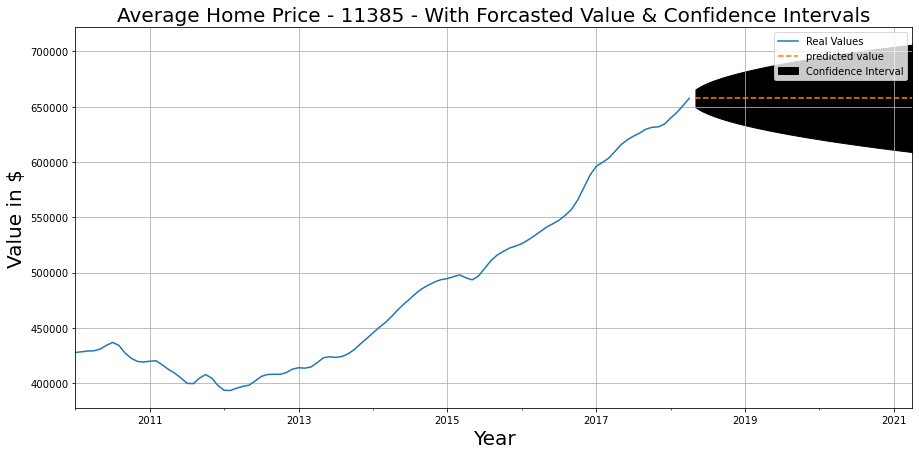

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11385   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -956.081
Date:                Mon, 14 Mar 2022   AIC                           1914.163
Time:                        12:07:57   BIC                           1916.748
Sample:                    01-01-2010   HQIC                          1915.208
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.709e+07   2.74e+06      6.229      0.000    1.17e+07    2.25e+07
===================================================================================
Ljung-Box (L1) (Q):                  65.48   Jarque-Bera (JB):                 3.72
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               2.63   Skew:                            -0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9963186441595009
MAE:
	 4771.428571428572
RMSE:
	 5398.478621664758
r^2:
	 0.9831759181128502


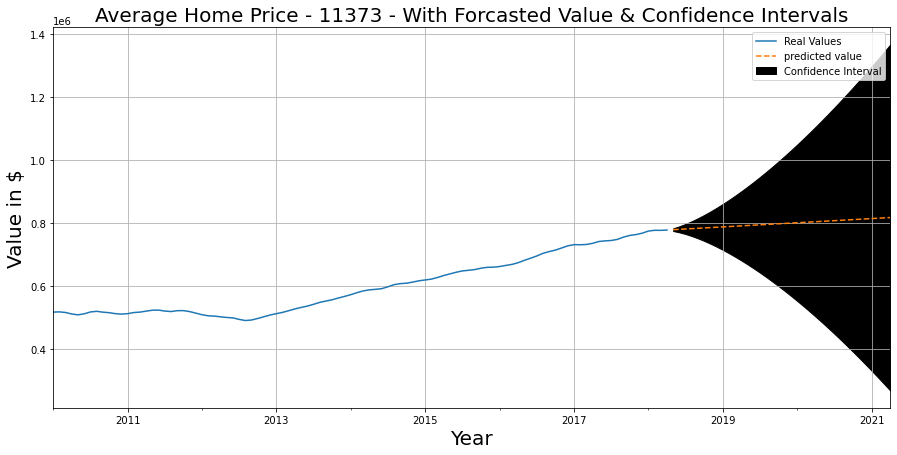

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11373   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -884.904
Date:                Mon, 14 Mar 2022   AIC                           1771.807
Time:                        12:07:58   BIC                           1774.382
Sample:                    01-01-2010   HQIC                          1772.848
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.844e+06   7.56e+05      6.404      0.000    3.36e+06    6.33e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.92   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.09   Prob(JB):                         0.77
Heteroskedasticity (H):               0.68   Skew:                             0.01
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9958157448128159
MAE:
	 2021.4285714285713
RMSE:
	 2316.863643561516
r^2:
	 0.9958153868476188


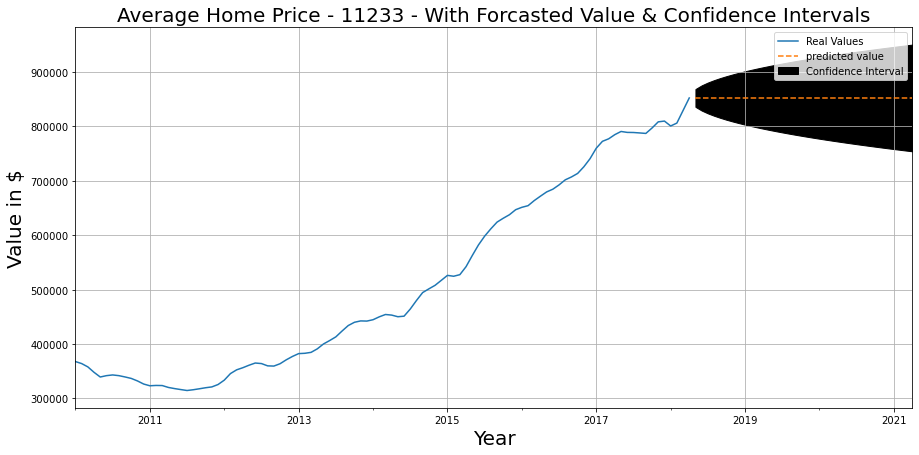

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11233   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1024.818
Date:                Mon, 14 Mar 2022   AIC                           2051.635
Time:                        12:07:59   BIC                           2054.220
Sample:                    01-01-2010   HQIC                          2052.681
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.961e+07   9.13e+06      7.623      0.000    5.17e+07    8.75e+07
===================================================================================
Ljung-Box (L1) (Q):                  48.72   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               4.56   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9848627937316519
MAE:
	 8235.714285714286
RMSE:
	 10199.12461229604
r^2:
	 0.9686392703980558


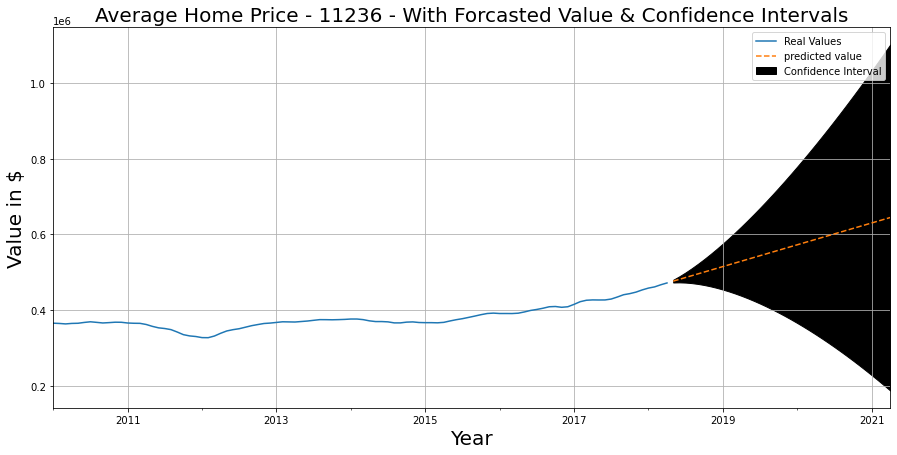

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11236   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -866.418
Date:                Mon, 14 Mar 2022   AIC                           1734.836
Time:                        12:07:59   BIC                           1737.410
Sample:                    01-01-2010   HQIC                          1735.877
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.354e+06   5.27e+05      6.369      0.000    2.32e+06    4.39e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.47   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.03   Prob(JB):                         0.53
Heteroskedasticity (H):               1.02   Skew:                             0.22
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9922147880258168
MAE:
	 1800.0
RMSE:
	 2149.086184537844
r^2:
	 0.9921836171295214


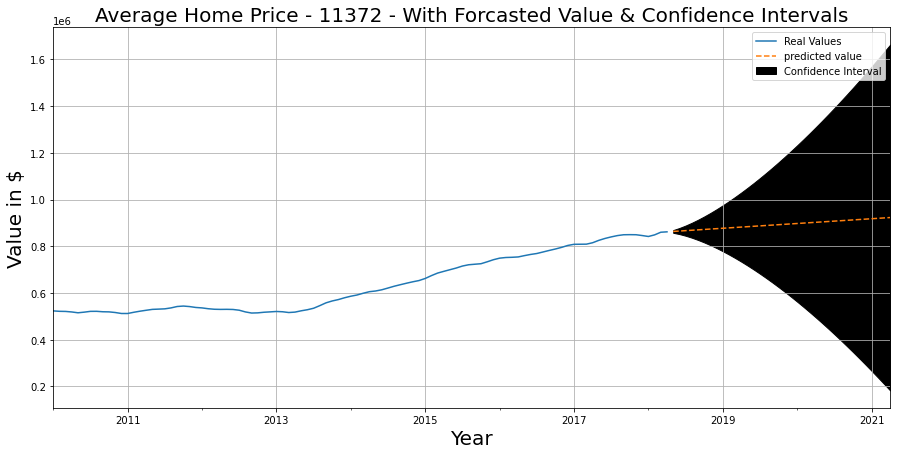

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11372   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -914.620
Date:                Mon, 14 Mar 2022   AIC                           1831.240
Time:                        12:07:59   BIC                           1833.815
Sample:                    01-01-2010   HQIC                          1832.281
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.809e+06   9.49e+05      9.283      0.000    6.95e+06    1.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.94   Jarque-Bera (JB):                10.99
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.48
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9898807571229655
MAE:
	 2721.4285714285716
RMSE:
	 3762.597886719076
r^2:
	 0.9898332723346772


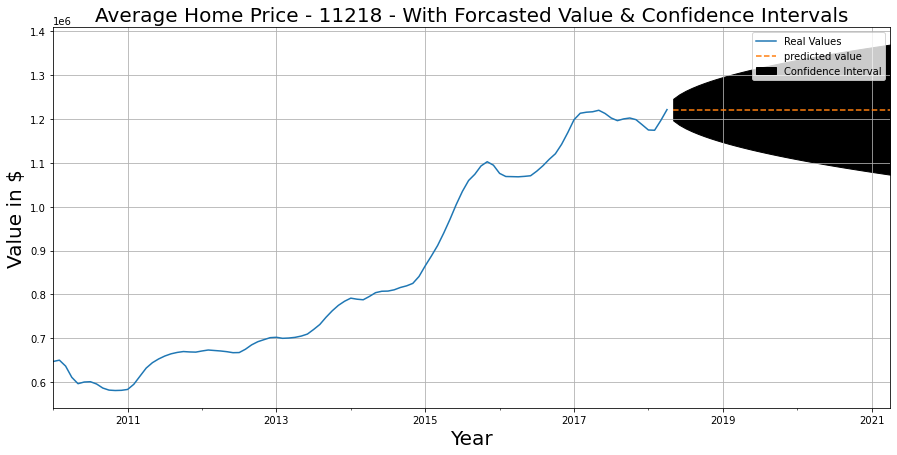

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11218   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1065.243
Date:                Mon, 14 Mar 2022   AIC                           2132.487
Time:                        12:08:00   BIC                           2135.072
Sample:                    01-01-2010   HQIC                          2133.532
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.586e+08   2.04e+07      7.767      0.000    1.19e+08    1.99e+08
===================================================================================
Ljung-Box (L1) (Q):                  66.37   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               2.42   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9538000648587368
MAE:
	 10089.285714285714
RMSE:
	 13253.66526124539
r^2:
	 0.9477260110545294


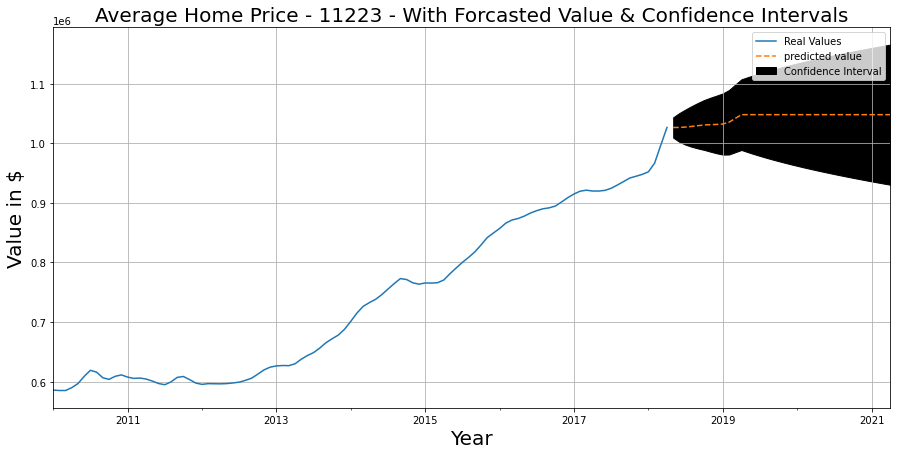

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11223   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -891.121
Date:                              Mon, 14 Mar 2022   AIC                           1786.241
Time:                                      12:08:01   BIC                           1791.150
Sample:                                  01-01-2010   HQIC                          1788.217
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2114      0.254      0.833      0.405      -0.286       0.709
sigma2      7.622e+07   1.84e-09   4.14e+16      0.000    7.62e+07    7.62e+07
===================================================================================
Ljung-Box (L1) (Q):                  45.33   Jarque-Bera (JB):               126.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.26   Skew:                             1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9608290164719117
MAE:
	 5561.283148946149
RMSE:
	 9299.732966814436
r^2:
	 0.9408898380209035


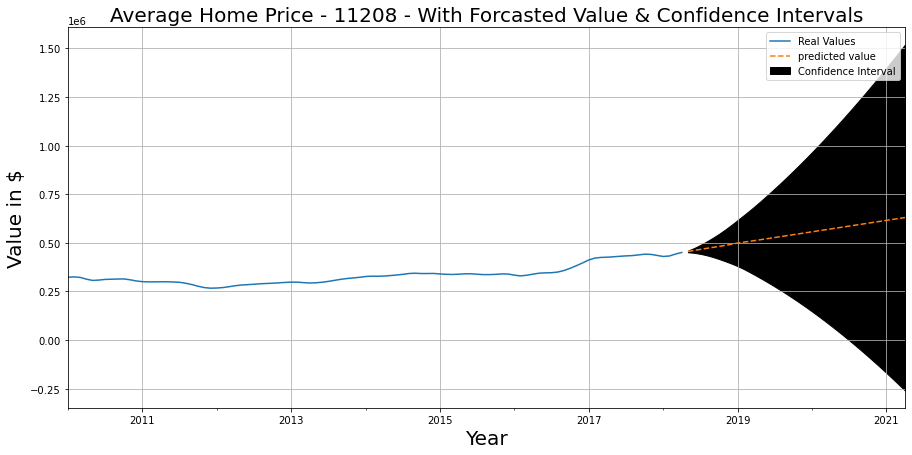

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11208   No. Observations:                  100
Model:             SARIMAX(0, 2, 1)x(0, 0, 1, 12)   Log Likelihood                -754.535
Date:                            Mon, 14 Mar 2022   AIC                           1515.070
Time:                                    12:08:02   BIC                           1522.363
Sample:                                01-01-2010   HQIC                          1518.002
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7969      0.080      9.999      0.000       0.641       0.953
ma.S.L12      -0.1051      0.090     -1.164      0.244      -0.282       0.072
sigma2      4.567e+06   7.73e+05      5.907      0.000    3.05e+06    6.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 3.85
Prob(Q):                              0.38   Prob(JB):                         0.15
Heteroskedasticity (H):               3.67   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9963304367946938
MAE:
	 2031.4613179089959
RMSE:
	 2570.13981571253
r^2:
	 0.9963164460012714


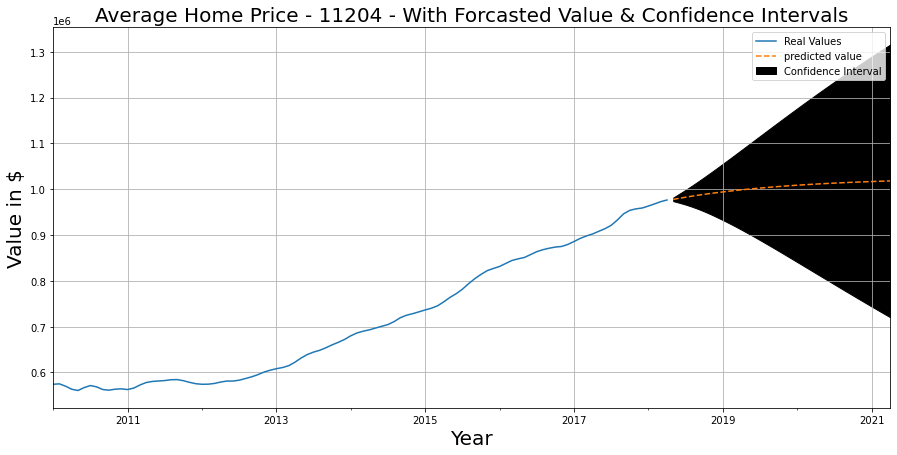

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               11204   No. Observations:                  100
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 12)   Log Likelihood                -760.512
Date:                             Mon, 14 Mar 2022   AIC                           1531.024
Time:                                     12:08:07   BIC                           1543.296
Sample:                                 01-01-2010   HQIC                          1535.963
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9514      0.053     18.110      0.000       0.848       1.054
ma.L1          0.7037      0.196      3.596      0.000       0.320       1.087
ma.L2         -0.5077      0.171     -2.973      0.003      -0.842      -0.173
ar.S.L12       0.0116      0.012      0.959      0.338      -0.012       0.035
sigma2      2.911e+06   4.31e-09   6.76e+14      0.000    2.91e+06    2.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.95   Prob(JB):                         0.71
Heteroskedasticity (H):               2.10   Skew:                            -0.12
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+31. Standard errors may be unstable.
"""

Explained Variance:
	 0.9981214813072732
MAE:
	 1611.2438646161338
RMSE:
	 1961.4128099049008
r^2:
	 0.9981075701179375


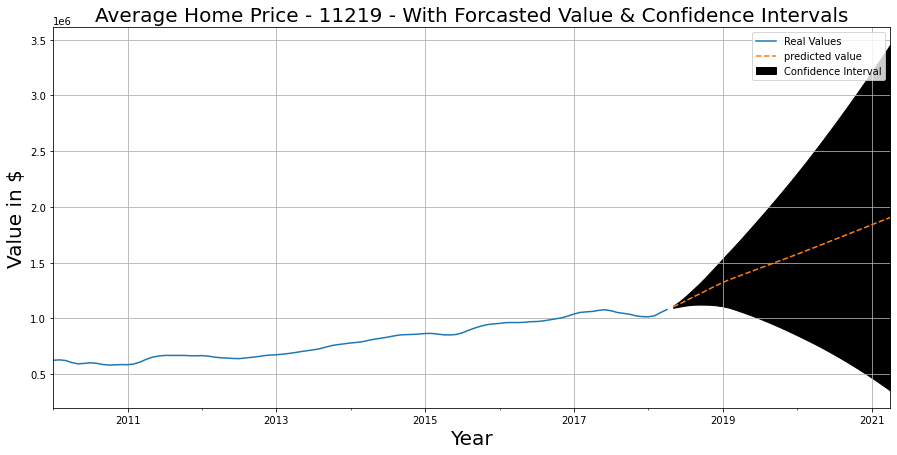

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11219   No. Observations:                  100
Model:             SARIMAX(1, 2, 0)x(1, 0, 0, 12)   Log Likelihood                -839.720
Date:                            Mon, 14 Mar 2022   AIC                           1685.440
Time:                                    12:08:08   BIC                           1692.768
Sample:                                01-01-2010   HQIC                          1688.388
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3230      0.082      3.929      0.000       0.162       0.484
ar.S.L12      -0.1859      0.100     -1.861      0.063      -0.382       0.010
sigma2       2.23e+07   9.97e-10   2.24e+16      0.000    2.23e+07    2.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                 3.36
Prob(Q):                              0.32   Prob(JB):                         0.19
Heteroskedasticity (H):               4.51   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9741262437192301
MAE:
	 5092.006046629865
RMSE:
	 6505.028563801037
r^2:
	 0.9739572266725401


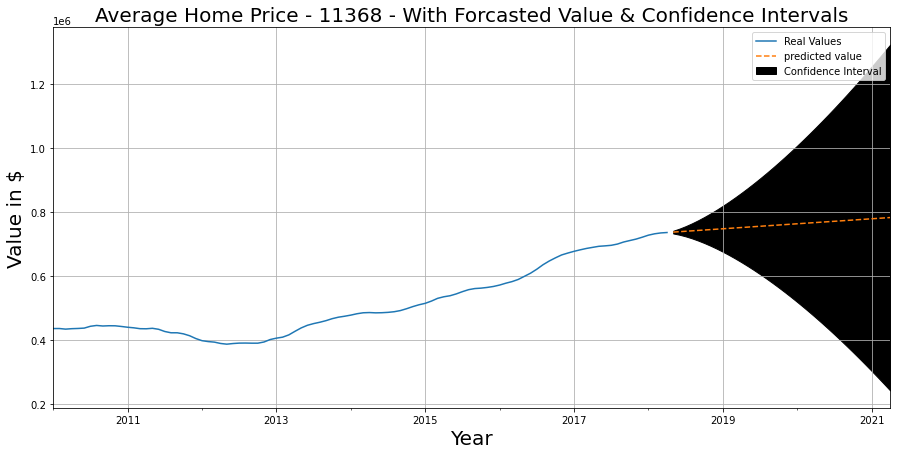

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11368   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -883.739
Date:                Mon, 14 Mar 2022   AIC                           1769.479
Time:                        12:08:09   BIC                           1772.053
Sample:                    01-01-2010   HQIC                          1770.520
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.692e+06   8.32e+05      5.639      0.000    3.06e+06    6.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.74   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.10   Prob(JB):                         0.29
Heteroskedasticity (H):               0.39   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9989478081857351
MAE:
	 1396.4285714285713
RMSE:
	 1649.1339718600357
r^2:
	 0.9989463801013589


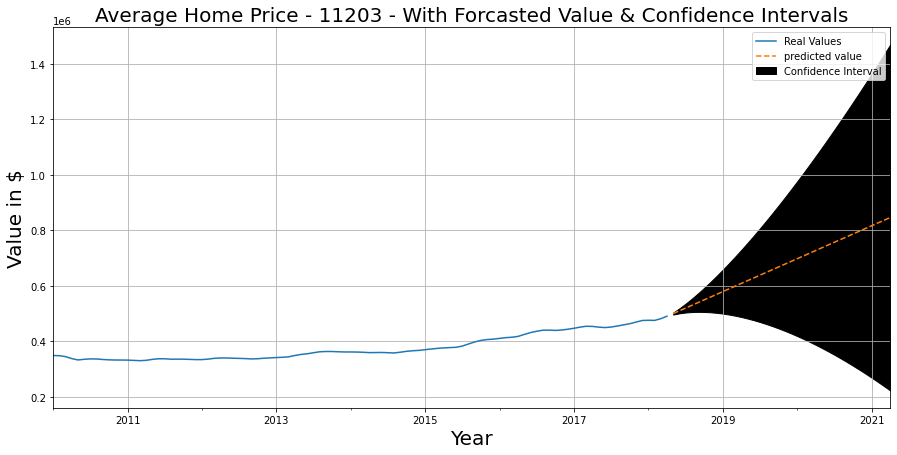

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11203   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -867.604
Date:                Mon, 14 Mar 2022   AIC                           1739.208
Time:                        12:08:09   BIC                           1744.357
Sample:                    01-01-2010   HQIC                          1741.290
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2693      0.092      2.922      0.003       0.089       0.450
sigma2       3.44e+06   3.23e+05     10.653      0.000    2.81e+06    4.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):                37.87
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.88
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9875688061356296
MAE:
	 1701.90207910429
RMSE:
	 2319.4742711493113
r^2:
	 0.9874415237192712


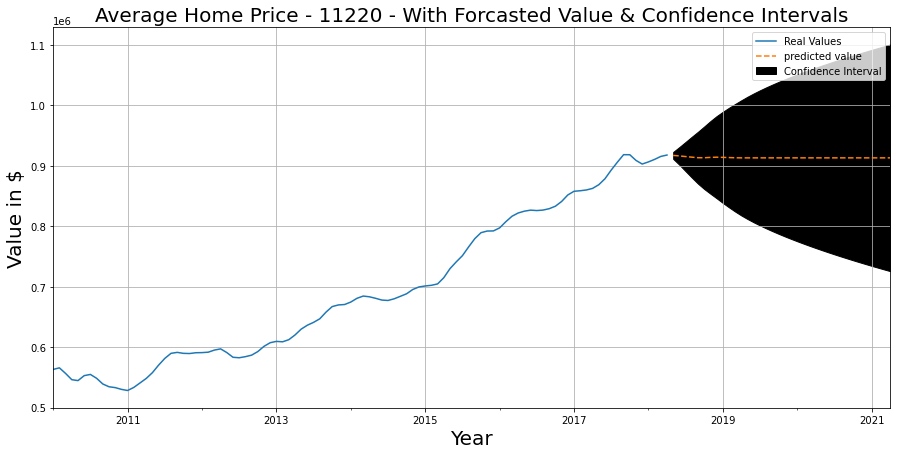

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11220   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -801.230
Date:                            Mon, 14 Mar 2022   AIC                           1610.459
Time:                                    12:08:13   BIC                           1620.230
Sample:                                01-01-2010   HQIC                          1614.389
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7351      0.083      8.903      0.000       0.573       0.897
ma.L1          0.6199      0.110      5.627      0.000       0.404       0.836
ma.S.L12      -0.0684      0.071     -0.960      0.337      -0.208       0.071
sigma2      8.603e+06   1.14e+06      7.547      0.000    6.37e+06    1.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                19.05
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.68
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9923380305063212
MAE:
	 2701.9500771132466
RMSE:
	 3486.665001501872
r^2:
	 0.9919339201846877


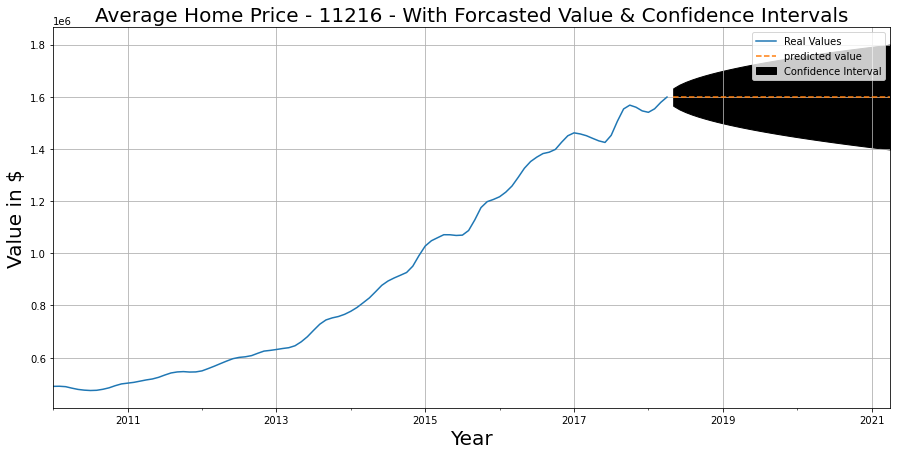

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1095.226
Date:                Mon, 14 Mar 2022   AIC                           2192.452
Time:                        12:08:14   BIC                           2195.037
Sample:                    01-01-2010   HQIC                          2193.497
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.923e+08   3.36e+07      8.692      0.000    2.26e+08    3.58e+08
===================================================================================
Ljung-Box (L1) (Q):                  55.01   Jarque-Bera (JB):                16.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.18   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9726760945846664
MAE:
	 18600.0
RMSE:
	 22310.51961999733
r^2:
	 0.9548686982692628


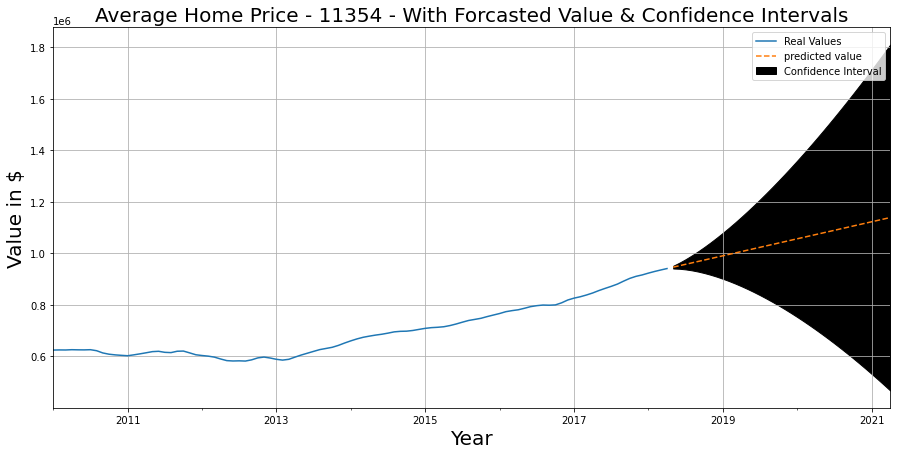

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11354   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -904.967
Date:                Mon, 14 Mar 2022   AIC                           1811.934
Time:                        12:08:14   BIC                           1814.509
Sample:                    01-01-2010   HQIC                          1812.975
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.238e+06      9e+05      8.043      0.000    5.47e+06       9e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.17   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.01   Prob(JB):                         0.56
Heteroskedasticity (H):               0.41   Skew:                            -0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9982898071833297
MAE:
	 1810.7142857142858
RMSE:
	 2282.77713072727
r^2:
	 0.9982897025262593


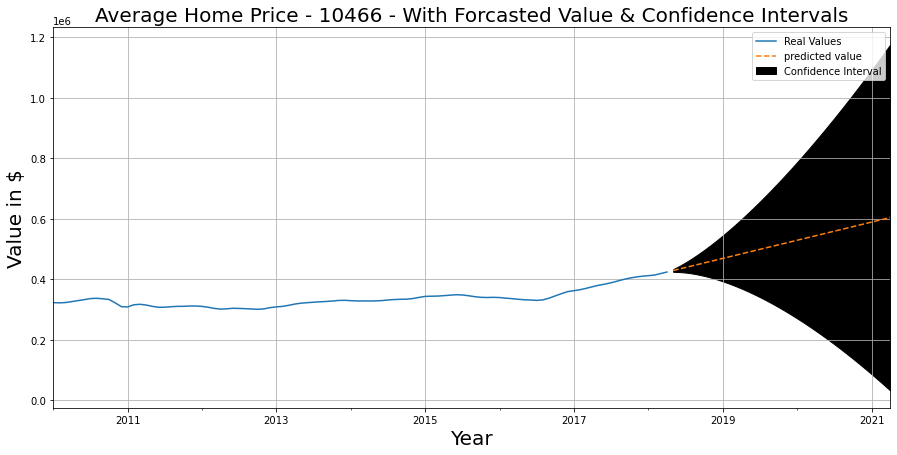

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10466   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -889.063
Date:                Mon, 14 Mar 2022   AIC                           1780.127
Time:                        12:08:15   BIC                           1782.701
Sample:                    01-01-2010   HQIC                          1781.168
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.247e+06   3.23e+05     16.251      0.000    4.61e+06    5.88e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.68   Jarque-Bera (JB):               301.07
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9977766518584732
MAE:
	 1089.2857142857142
RMSE:
	 1494.6332564975835
r^2:
	 0.9977506444068567


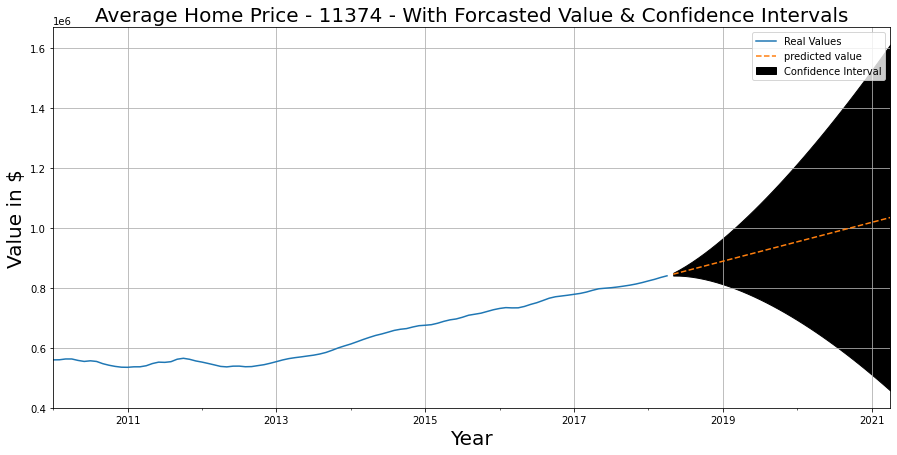

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11374   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -889.967
Date:                Mon, 14 Mar 2022   AIC                           1781.934
Time:                        12:08:15   BIC                           1784.509
Sample:                    01-01-2010   HQIC                          1782.976
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.347e+06      7e+05      7.635      0.000    3.97e+06    6.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.96   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.16   Prob(JB):                         0.43
Heteroskedasticity (H):               0.27   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9973157751718938
MAE:
	 1275.0
RMSE:
	 1695.6878081938146
r^2:
	 0.997315668002474


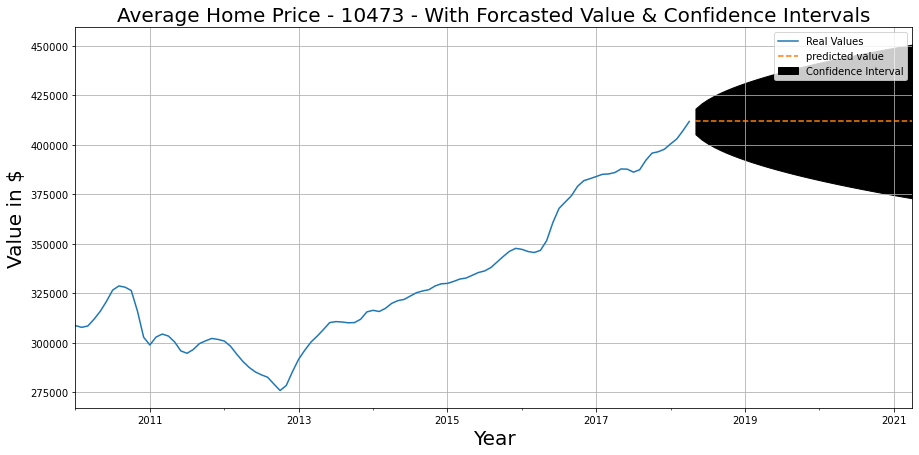

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10473   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -934.053
Date:                Mon, 14 Mar 2022   AIC                           1870.106
Time:                        12:08:16   BIC                           1872.691
Sample:                    01-01-2010   HQIC                          1871.151
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.091e+07   1.04e+06     10.461      0.000    8.86e+06    1.29e+07
===================================================================================
Ljung-Box (L1) (Q):                  52.30   Jarque-Bera (JB):               104.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.19
Prob(H) (two-sided):                  0.19   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9831913567644815
MAE:
	 2553.5714285714284
RMSE:
	 3350.6395977911016
r^2:
	 0.9684750412785055


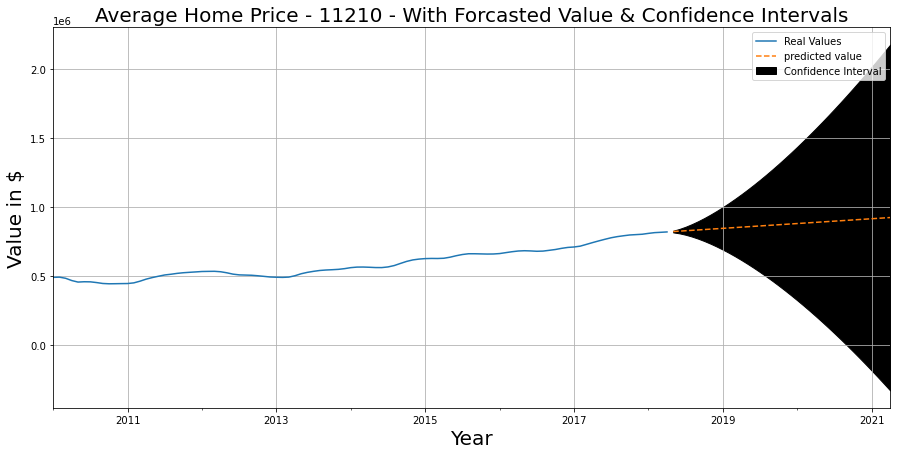

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11210   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -918.409
Date:                Mon, 14 Mar 2022   AIC                           1840.819
Time:                        12:08:16   BIC                           1845.968
Sample:                    01-01-2010   HQIC                          1842.901
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3915      0.059      6.681      0.000       0.277       0.506
sigma2      9.805e+06   1.14e+06      8.591      0.000    7.57e+06     1.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.82   Jarque-Bera (JB):                10.00
Prob(Q):                              0.09   Prob(JB):                         0.01
Heteroskedasticity (H):               0.40   Skew:                             0.61
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9978531901354102
MAE:
	 2151.805267061431
RMSE:
	 2498.616946170896
r^2:
	 0.9978528881557612


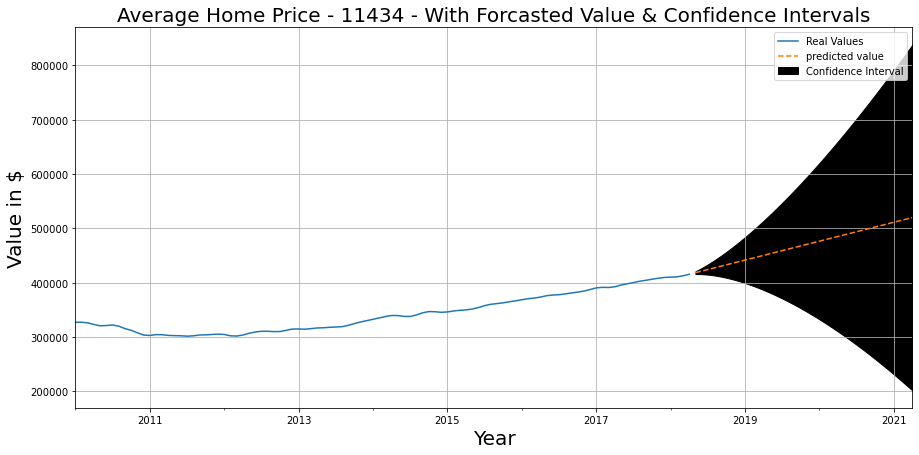

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11434   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -831.370
Date:                Mon, 14 Mar 2022   AIC                           1664.740
Time:                        12:08:17   BIC                           1667.315
Sample:                    01-01-2010   HQIC                          1665.781
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.629e+06    2.3e+05      7.092      0.000    1.18e+06    2.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.54   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.02   Prob(JB):                         0.87
Heteroskedasticity (H):               0.29   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9960253978993183
MAE:
	 689.2857142857143
RMSE:
	 901.7839462500348
r^2:
	 0.9960148342974027


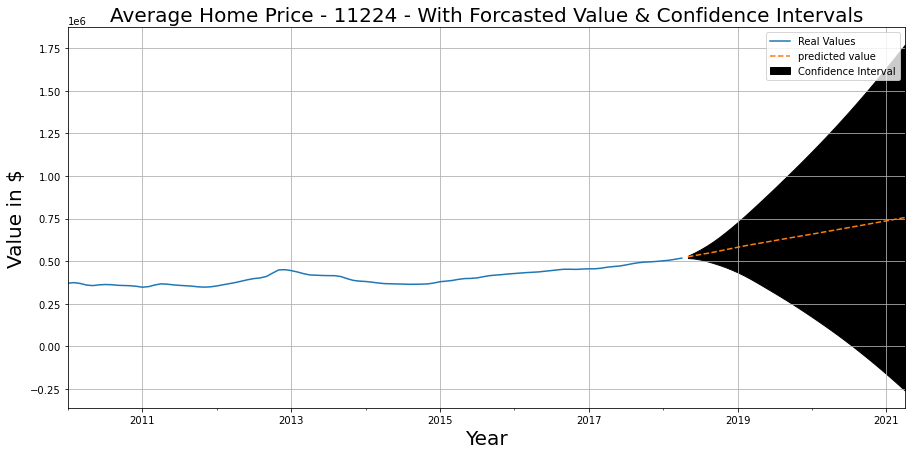

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11224   No. Observations:                  100
Model:             SARIMAX(1, 2, 0)x(1, 0, 0, 12)   Log Likelihood                -805.613
Date:                            Mon, 14 Mar 2022   AIC                           1617.227
Time:                                    12:08:18   BIC                           1624.555
Sample:                                01-01-2010   HQIC                          1620.174
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2701      0.145      1.866      0.062      -0.014       0.554
ar.S.L12      -0.2550      0.136     -1.869      0.062      -0.522       0.012
sigma2      1.179e+07   1.12e+06     10.521      0.000    9.59e+06     1.4e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.43   Jarque-Bera (JB):               237.94
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9947468829946242
MAE:
	 1447.8466098640472
RMSE:
	 1915.458198992446
r^2:
	 0.994742033701122


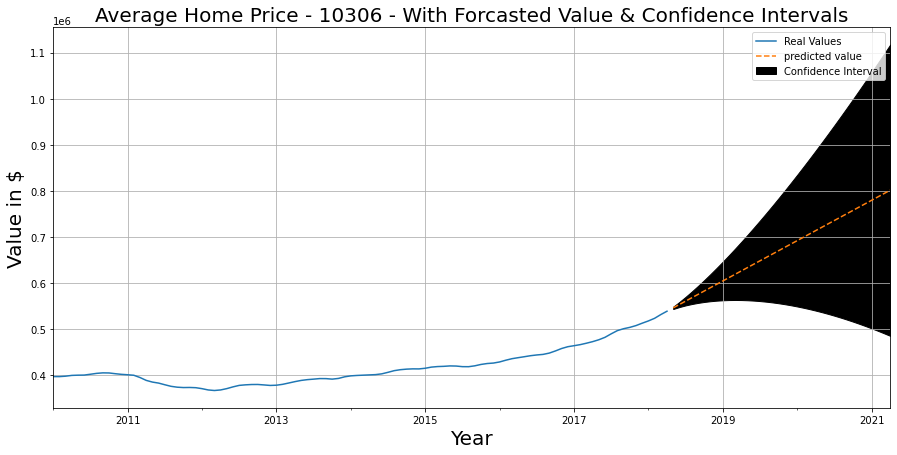

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10306   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -830.721
Date:                Mon, 14 Mar 2022   AIC                           1663.443
Time:                        12:08:18   BIC                           1666.018
Sample:                    01-01-2010   HQIC                          1664.484
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.607e+06   2.52e+05      6.382      0.000    1.11e+06     2.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.92   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.00   Prob(JB):                         0.80
Heteroskedasticity (H):               0.84   Skew:                            -0.06
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9984951799957319
MAE:
	 1053.5714285714287
RMSE:
	 1271.8097341976904
r^2:
	 0.9984465599636834


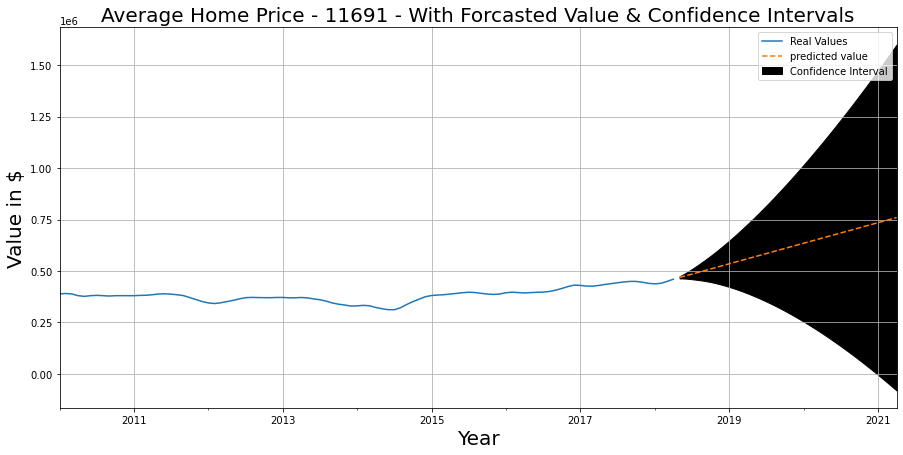

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11691   No. Observations:                  100
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -876.848
Date:                Mon, 14 Mar 2022   AIC                           1763.696
Time:                        12:08:21   BIC                           1776.465
Sample:                    01-01-2010   HQIC                          1768.856
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3773      0.307      1.229      0.219      -0.225       0.979
ar.L2         -0.3327      0.142     -2.343      0.019      -0.611      -0.054
ma.L1          0.2602      0.296      0.879      0.379      -0.320       0.840
ma.L2          0.0270      0.103      0.263      0.793      -0.175       0.229
sigma2      6.212e+06   5.04e-08   1.23e+14      0.000    6.21e+06    6.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 2.60
Prob(Q):                              0.39   Prob(JB):                         0.27
Heteroskedasticity (H):               0.99   Skew:                             0.31
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.9e+29. Standard errors may be unstable.
"""

Explained Variance:
	 0.9888977780030652
MAE:
	 1780.296840018073
RMSE:
	 2215.957987600438
r^2:
	 0.9888519821484905


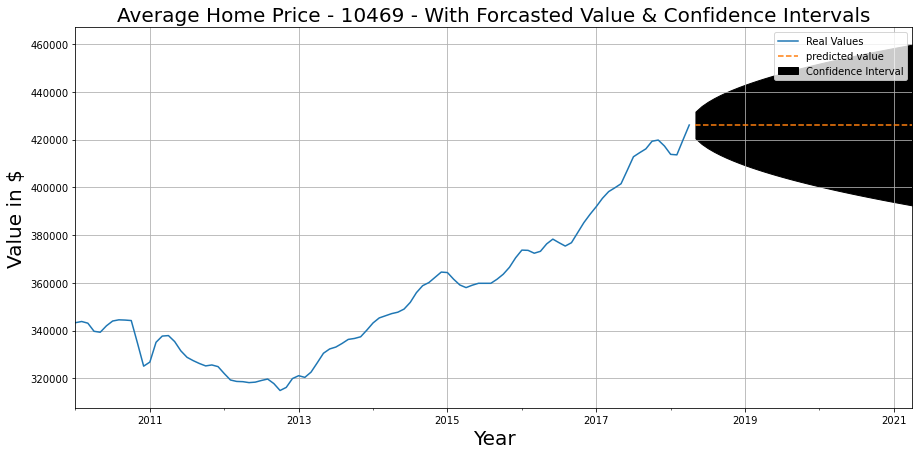

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10469   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -920.132
Date:                Mon, 14 Mar 2022   AIC                           1842.264
Time:                        12:08:22   BIC                           1844.849
Sample:                    01-01-2010   HQIC                          1843.310
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.205e+06   8.71e+05      9.418      0.000     6.5e+06    9.91e+06
===================================================================================
Ljung-Box (L1) (Q):                  33.22   Jarque-Bera (JB):                40.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.78
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9803068833164776
MAE:
	 2728.5714285714284
RMSE:
	 3228.666243866918
r^2:
	 0.9683259428466011


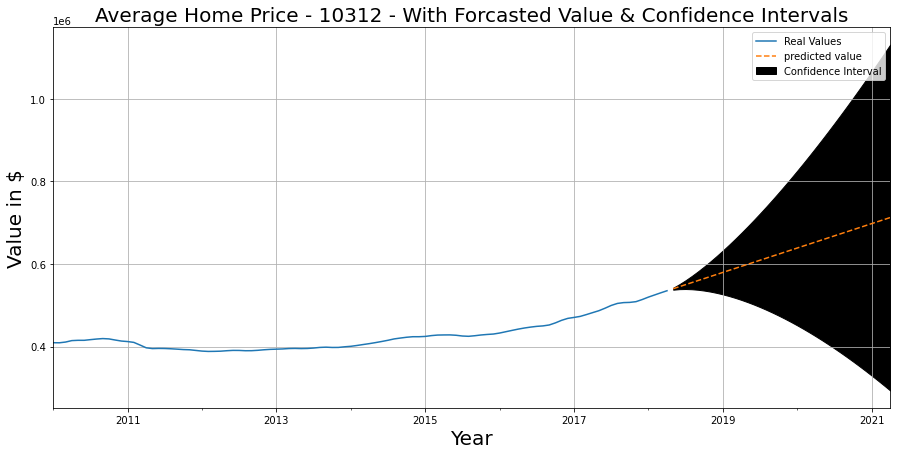

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10312   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -827.616
Date:                Mon, 14 Mar 2022   AIC                           1659.233
Time:                        12:08:22   BIC                           1664.382
Sample:                    01-01-2010   HQIC                          1661.315
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2799      0.106      2.638      0.008       0.072       0.488
sigma2      1.508e+06   1.39e+05     10.811      0.000    1.23e+06    1.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):                32.94
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.18
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9982322663928952
MAE:
	 992.1479835953734
RMSE:
	 1309.7392630448758
r^2:
	 0.9982210779037989


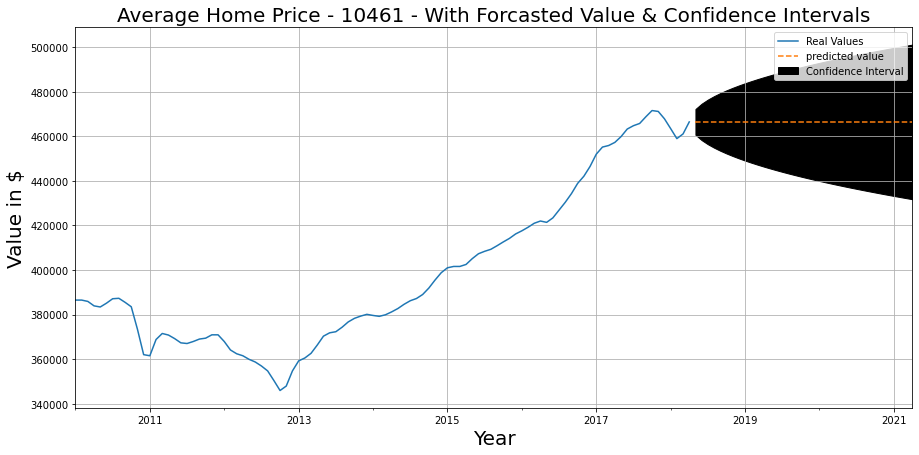

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10461   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -923.119
Date:                Mon, 14 Mar 2022   AIC                           1848.238
Time:                        12:08:23   BIC                           1850.823
Sample:                    01-01-2010   HQIC                          1849.284
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.718e+06   8.51e+05     10.239      0.000    7.05e+06    1.04e+07
===================================================================================
Ljung-Box (L1) (Q):                  41.95   Jarque-Bera (JB):                91.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -1.30
Prob(H) (two-sided):                  0.30   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9812251510758713
MAE:
	 2739.285714285714
RMSE:
	 3100.518389836494
r^2:
	 0.9717373962379353


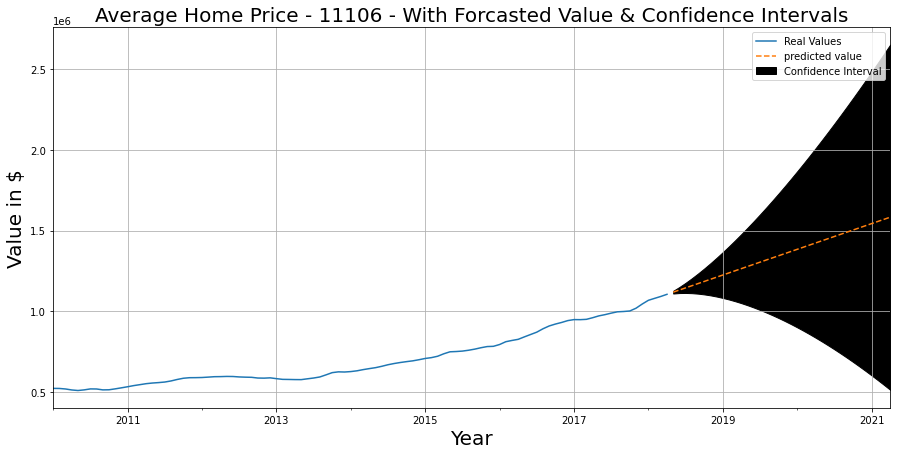

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11106   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -950.331
Date:                Mon, 14 Mar 2022   AIC                           1902.662
Time:                        12:08:23   BIC                           1905.237
Sample:                    01-01-2010   HQIC                          1903.703
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.845e+07   2.19e+06      8.427      0.000    1.42e+07    2.27e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.93   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.17   Prob(JB):                         0.29
Heteroskedasticity (H):               3.42   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9952697030528764
MAE:
	 4664.285714285715
RMSE:
	 5955.309755647836
r^2:
	 0.9952458958742536


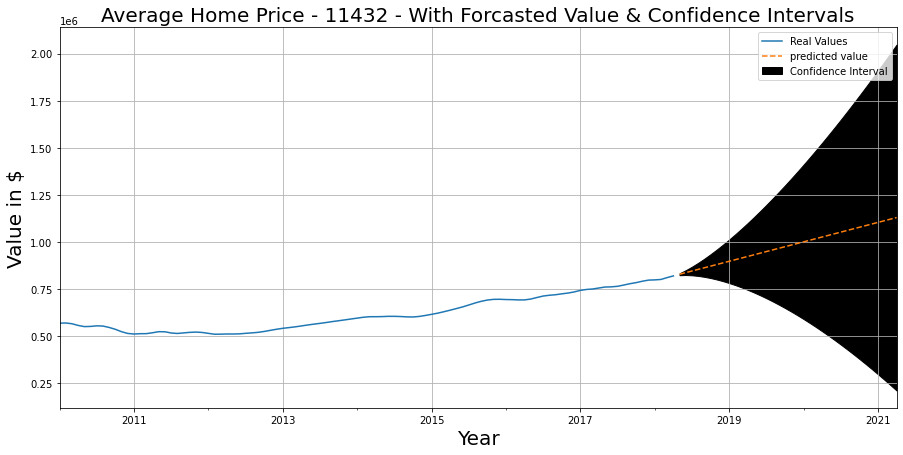

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11432   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -900.377
Date:                Mon, 14 Mar 2022   AIC                           1804.754
Time:                        12:08:24   BIC                           1809.903
Sample:                    01-01-2010   HQIC                          1806.836
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3065      0.083      3.682      0.000       0.143       0.470
sigma2       6.76e+06   9.27e+05      7.290      0.000    4.94e+06    8.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.18   Prob(JB):                         0.43
Heteroskedasticity (H):               0.66   Skew:                             0.32
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.994681440725754
MAE:
	 2469.4788321362244
RMSE:
	 2863.9760275255057
r^2:
	 0.9946440537095268


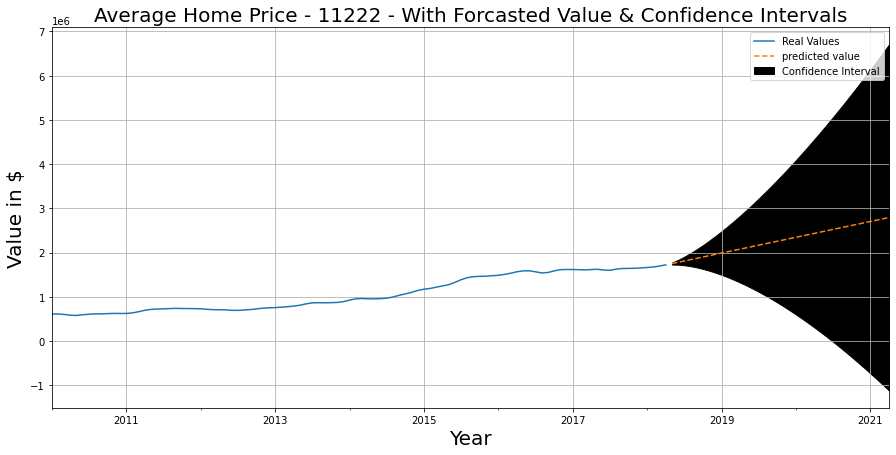

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11222   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1040.390
Date:                Mon, 14 Mar 2022   AIC                           2084.779
Time:                        12:08:25   BIC                           2089.929
Sample:                    01-01-2010   HQIC                          2086.861
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3105      0.087      3.569      0.000       0.140       0.481
sigma2      1.213e+08   7.18e-12   1.69e+19      0.000    1.21e+08    1.21e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.02   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.08   Prob(JB):                         0.35
Heteroskedasticity (H):               3.93   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Explained Variance:
	 0.9246797244574627
MAE:
	 11223.435276945995
RMSE:
	 14490.294621481318
r^2:
	 0.9246378669561581


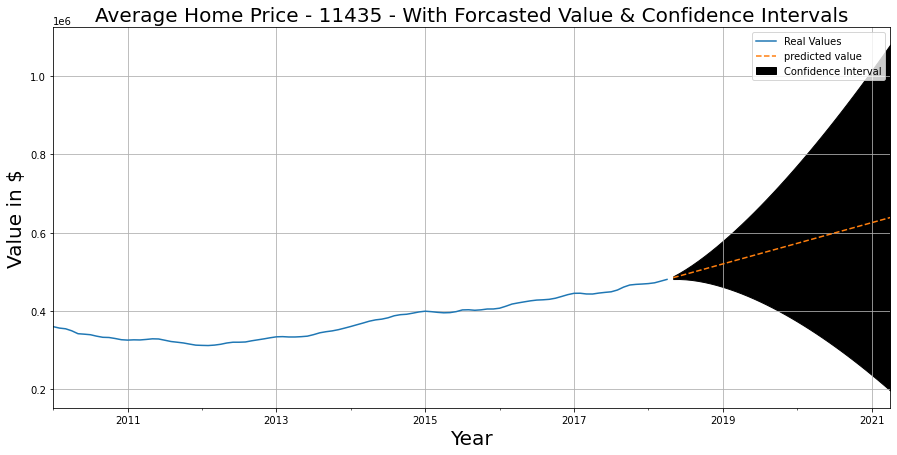

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11435   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -863.981
Date:                Mon, 14 Mar 2022   AIC                           1729.962
Time:                        12:08:25   BIC                           1732.537
Sample:                    01-01-2010   HQIC                          1731.004
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.15e+06   4.16e+05      7.576      0.000    2.33e+06    3.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.16   Prob(JB):                         0.78
Heteroskedasticity (H):               0.94   Skew:                             0.10
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9914172920432741
MAE:
	 1510.7142857142858
RMSE:
	 1863.8477865503319
r^2:
	 0.9913586265484368


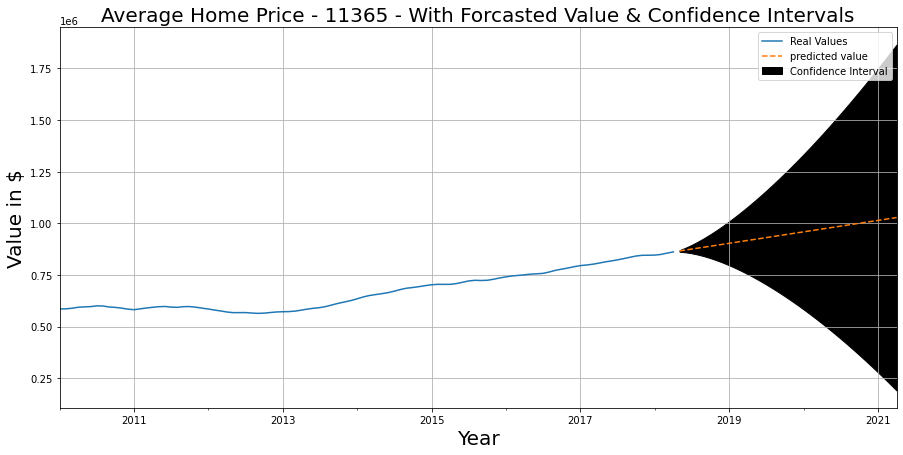

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               11365   No. Observations:                  100
Model:             SARIMAX(0, 2, 1)x(1, 0, [], 12)   Log Likelihood                -760.790
Date:                             Mon, 14 Mar 2022   AIC                           1527.580
Time:                                     12:08:26   BIC                           1534.943
Sample:                                 01-01-2010   HQIC                          1530.543
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6929      0.133      5.223      0.000       0.433       0.953
ar.S.L12      -0.0127      0.011     -1.154      0.248      -0.034       0.009
sigma2      4.119e+06   5.47e-11   7.53e+16      0.000    4.12e+06    4.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.89   Prob(JB):                         0.46
Heteroskedasticity (H):               0.78   Skew:                             0.30
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.66e+32. Standard errors may be unstable.
"""

Explained Variance:
	 0.9984125079160591
MAE:
	 1361.1564136265577
RMSE:
	 1523.9100839372004
r^2:
	 0.9984116950161572


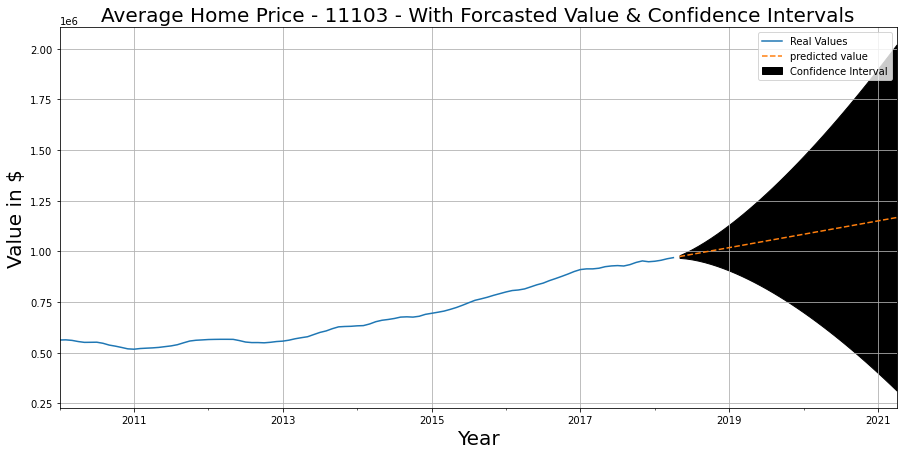

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11103   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -928.031
Date:                Mon, 14 Mar 2022   AIC                           1858.062
Time:                        12:08:27   BIC                           1860.637
Sample:                    01-01-2010   HQIC                          1859.103
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.171e+07   1.52e+06      7.718      0.000    8.74e+06    1.47e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.63   Prob(JB):                         0.53
Heteroskedasticity (H):               1.87   Skew:                            -0.21
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.993635665540728
MAE:
	 3364.285714285714
RMSE:
	 4203.824789063271
r^2:
	 0.9936320621645631


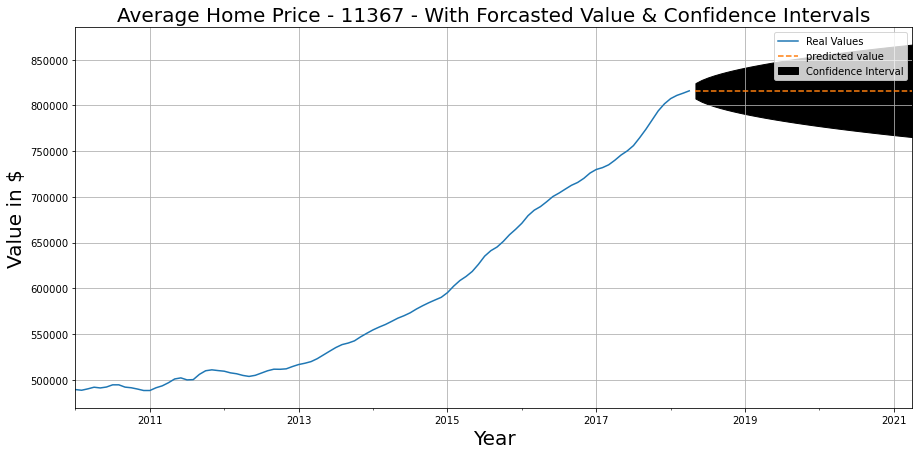

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11367   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -959.975
Date:                Mon, 14 Mar 2022   AIC                           1921.951
Time:                        12:08:27   BIC                           1924.536
Sample:                    01-01-2010   HQIC                          1922.996
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.85e+07   3.13e+06      5.907      0.000    1.24e+07    2.46e+07
===================================================================================
Ljung-Box (L1) (Q):                  69.85   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.00   Prob(JB):                         0.87
Heteroskedasticity (H):               7.62   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9973987332739498
MAE:
	 5407.142857142857
RMSE:
	 5848.320882343678
r^2:
	 0.9820828055653349


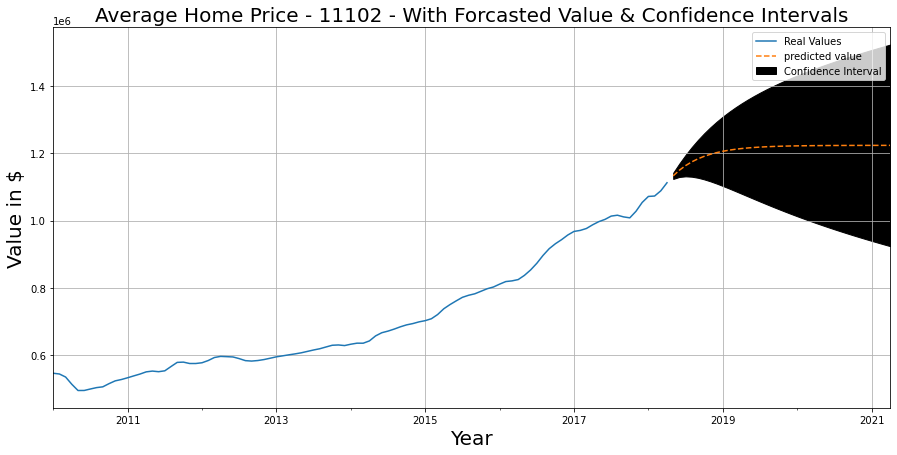

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11102   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -972.063
Date:                Mon, 14 Mar 2022   AIC                           1950.125
Time:                        12:08:29   BIC                           1957.849
Sample:                    01-01-2010   HQIC                          1953.248
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8151      0.046     17.856      0.000       0.726       0.905
ma.L1          0.1089      0.031      3.496      0.000       0.048       0.170
sigma2      2.227e+07    2.9e-10   7.69e+16      0.000    2.23e+07    2.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):                42.63
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Explained Variance:
	 0.9937816967313775
MAE:
	 5465.704901826177
RMSE:
	 7288.7604953758255
r^2:
	 0.9930444531134288


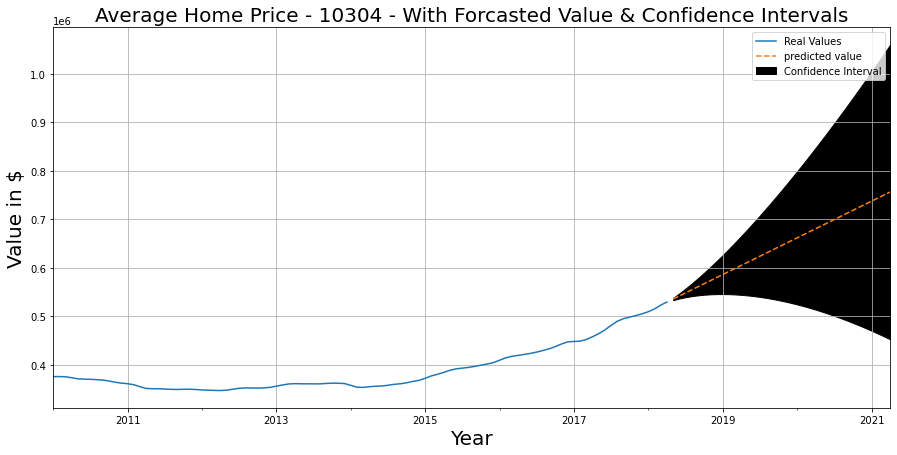

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10304   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -826.781
Date:                Mon, 14 Mar 2022   AIC                           1655.562
Time:                        12:08:30   BIC                           1658.137
Sample:                    01-01-2010   HQIC                          1656.603
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.481e+06   1.84e+05      8.069      0.000    1.12e+06    1.84e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.77   Jarque-Bera (JB):                 2.47
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               2.38   Skew:                            -0.15
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9982121614900662
MAE:
	 1239.2857142857142
RMSE:
	 1545.615919764212
r^2:
	 0.9982017053957105


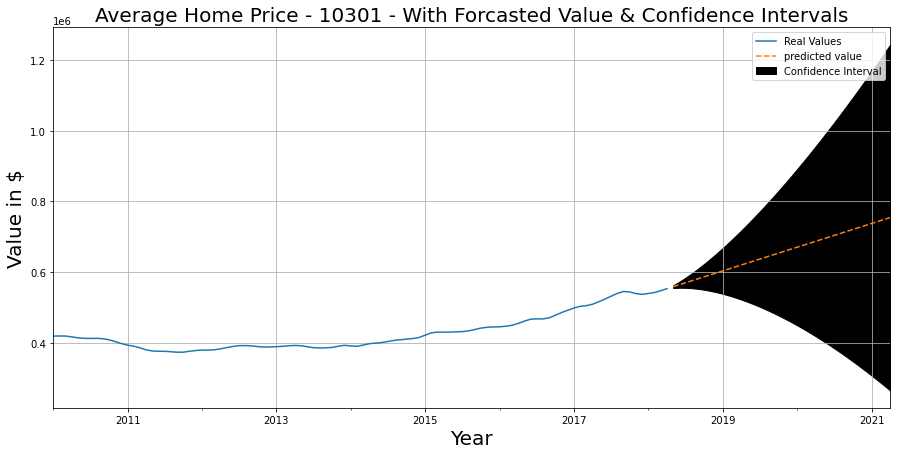

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10301   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -873.256
Date:                Mon, 14 Mar 2022   AIC                           1748.512
Time:                        12:08:30   BIC                           1751.087
Sample:                    01-01-2010   HQIC                          1749.554
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.861e+06   4.66e+05      8.287      0.000    2.95e+06    4.77e+06
===================================================================================
Ljung-Box (L1) (Q):                  13.55   Jarque-Bera (JB):                 5.44
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               3.07   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9947237679864385
MAE:
	 2014.2857142857142
RMSE:
	 2594.9126051895137
r^2:
	 0.9947025344530136


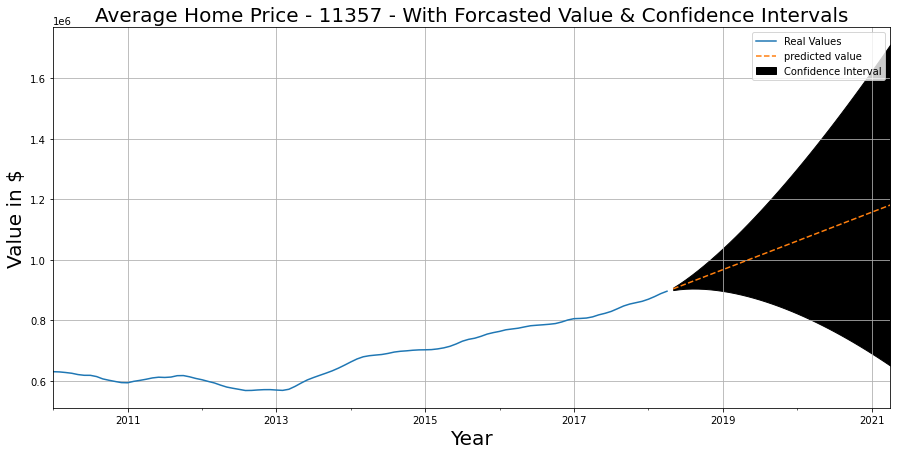

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11357   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -880.780
Date:                Mon, 14 Mar 2022   AIC                           1763.560
Time:                        12:08:31   BIC                           1766.135
Sample:                    01-01-2010   HQIC                          1764.601
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.51e+06   6.71e+05      6.724      0.000     3.2e+06    5.82e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.06   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.01   Prob(JB):                         0.87
Heteroskedasticity (H):               0.60   Skew:                             0.10
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9976791247130736
MAE:
	 1564.2857142857142
RMSE:
	 1854.3385420605991
r^2:
	 0.9976713505703698


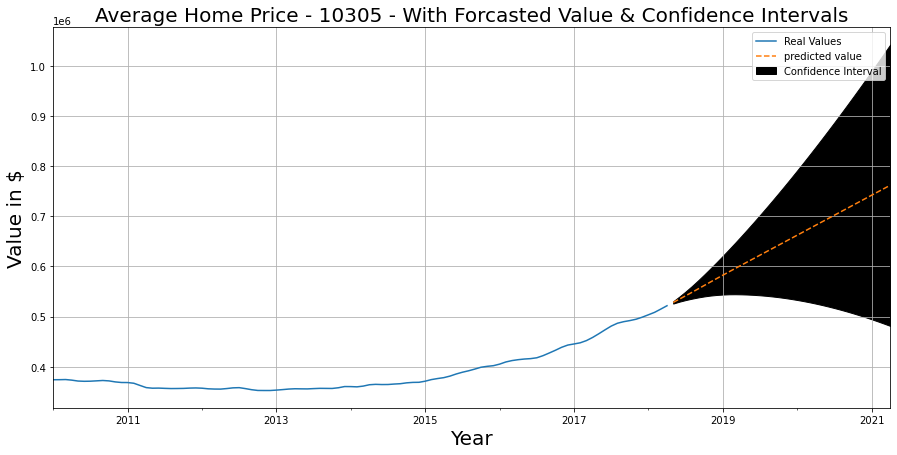

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                10305   No. Observations:                  100
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -719.711
Date:                              Mon, 14 Mar 2022   AIC                           1443.423
Time:                                      12:08:31   BIC                           1448.308
Sample:                                  01-01-2010   HQIC                          1445.388
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0670      0.056     -1.194      0.232      -0.177       0.043
sigma2      1.363e+06   2.26e+05      6.037      0.000    9.21e+05    1.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.84   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.01   Prob(JB):                         0.86
Heteroskedasticity (H):               1.72   Skew:                            -0.14
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9987323448755125
MAE:
	 1087.8737427935496
RMSE:
	 1310.1888768029921
r^2:
	 0.9986997685793068


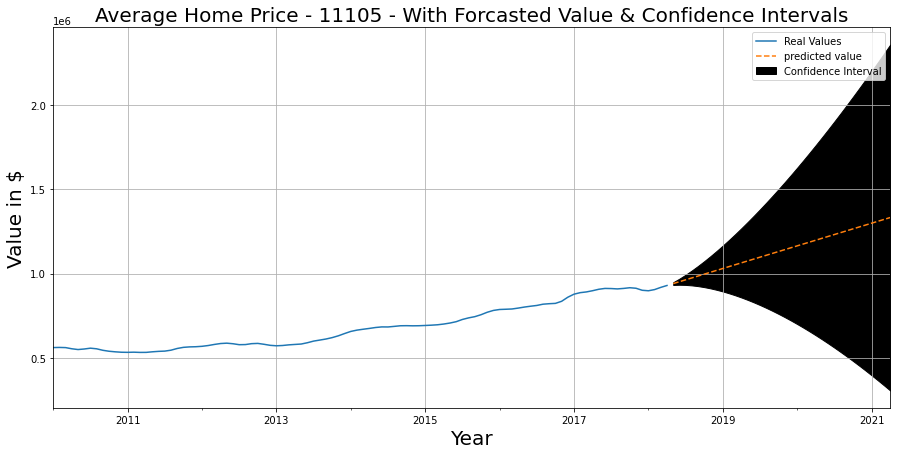

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11105   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -946.279
Date:                Mon, 14 Mar 2022   AIC                           1894.558
Time:                        12:08:32   BIC                           1897.133
Sample:                    01-01-2010   HQIC                          1895.599
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.692e+07   2.27e+06      7.468      0.000    1.25e+07    2.14e+07
===================================================================================
Ljung-Box (L1) (Q):                   7.65   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.01   Prob(JB):                         0.71
Heteroskedasticity (H):               1.97   Skew:                             0.19
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9864896198753385
MAE:
	 4667.857142857143
RMSE:
	 5734.8869711118605
r^2:
	 0.9864895727183779


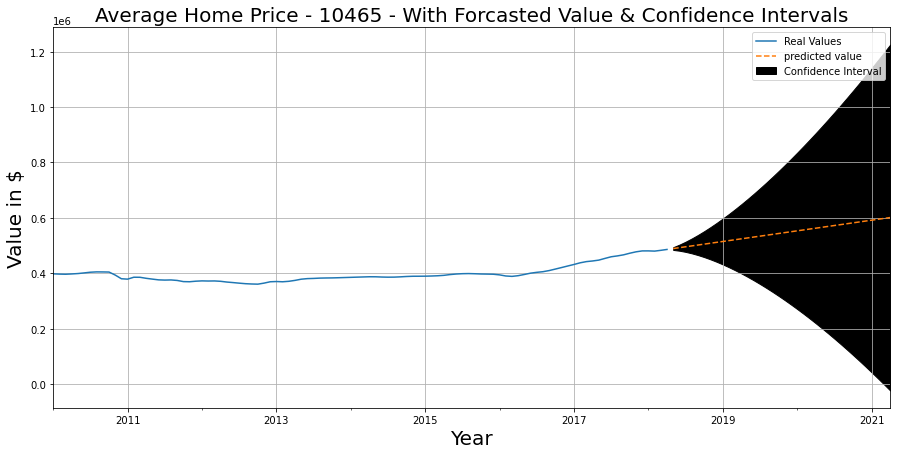

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10465   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -896.718
Date:                Mon, 14 Mar 2022   AIC                           1795.436
Time:                        12:08:32   BIC                           1798.011
Sample:                    01-01-2010   HQIC                          1796.477
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.263e+06   4.03e+05     15.551      0.000    5.47e+06    7.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.27   Jarque-Bera (JB):               258.59
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9968515679476788
MAE:
	 1517.857142857143
RMSE:
	 1865.1886155101236
r^2:
	 0.9968356853499847


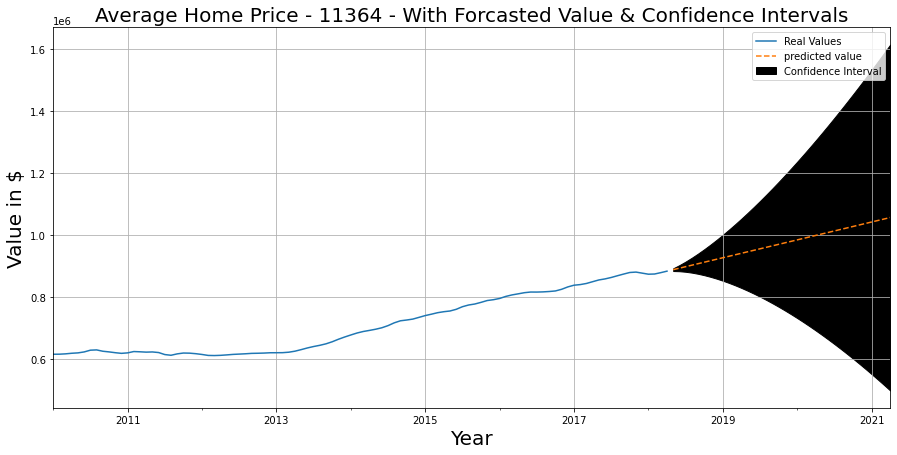

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11364   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -885.706
Date:                Mon, 14 Mar 2022   AIC                           1773.412
Time:                        12:08:33   BIC                           1775.987
Sample:                    01-01-2010   HQIC                          1774.453
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.992e+06   6.78e+05      7.366      0.000    3.66e+06    6.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.08   Prob(JB):                         0.77
Heteroskedasticity (H):               0.68   Skew:                            -0.13
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9937257968770606
MAE:
	 1782.142857142857
RMSE:
	 2225.260819384037
r^2:
	 0.993718661566543


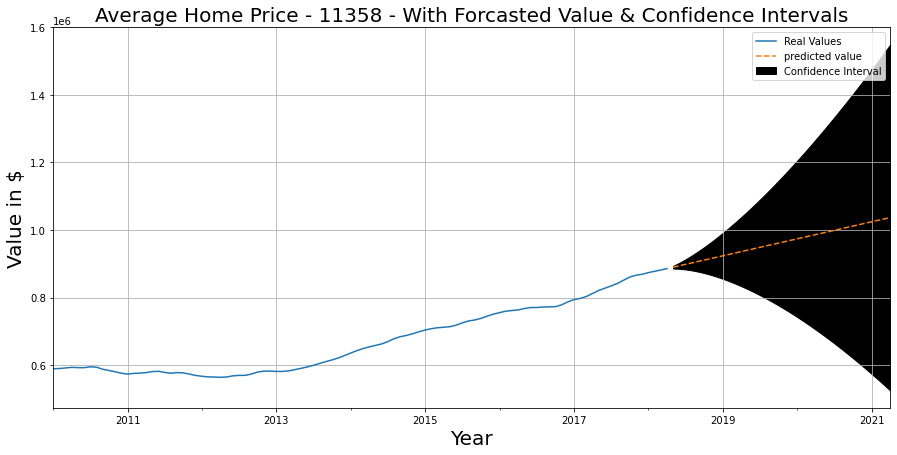

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11358   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -877.479
Date:                Mon, 14 Mar 2022   AIC                           1756.957
Time:                        12:08:33   BIC                           1759.532
Sample:                    01-01-2010   HQIC                          1757.998
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.213e+06    6.6e+05      6.380      0.000    2.92e+06    5.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.25   Prob(JB):                         0.81
Heteroskedasticity (H):               0.72   Skew:                            -0.03
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9976347011656163
MAE:
	 1664.2857142857142
RMSE:
	 2128.21185841206
r^2:
	 0.9976329947162261


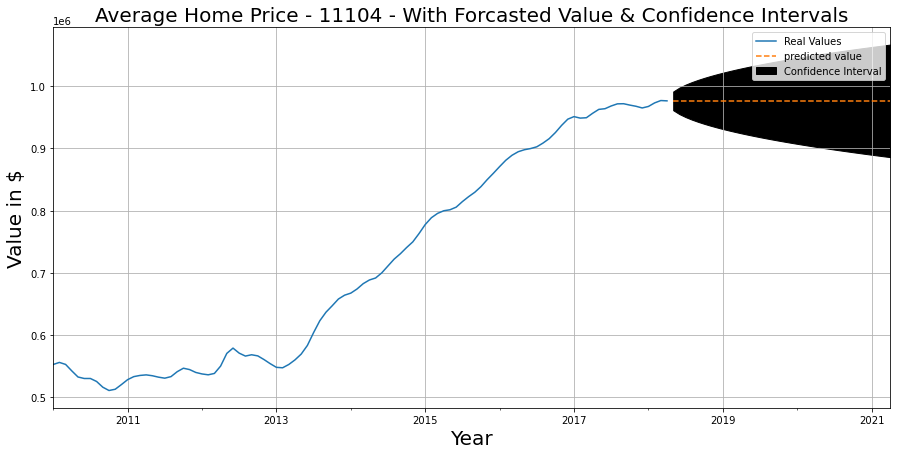

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11104   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1016.793
Date:                Mon, 14 Mar 2022   AIC                           2035.587
Time:                        12:08:34   BIC                           2038.172
Sample:                    01-01-2010   HQIC                          2036.632
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.908e+07   9.03e+06      6.540      0.000    4.14e+07    7.68e+07
===================================================================================
Ljung-Box (L1) (Q):                  60.78   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.00   Prob(JB):                         0.92
Heteroskedasticity (H):               0.98   Skew:                            -0.03
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9843396652986676
MAE:
	 4846.428571428572
RMSE:
	 5871.511122116934
r^2:
	 0.9686523532765748


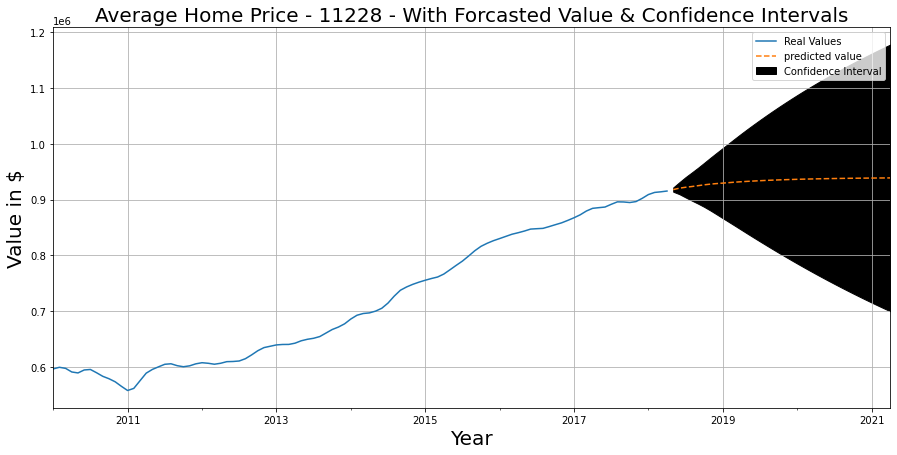

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               11228   No. Observations:                  100
Model:             SARIMAX(3, 1, 1)x(1, 0, [], 12)   Log Likelihood                -738.018
Date:                             Mon, 14 Mar 2022   AIC                           1488.036
Time:                                     12:08:44   BIC                           1502.621
Sample:                                 01-01-2010   HQIC                          1493.899
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1752      0.211      5.579      0.000       0.762       1.588
ar.L2         -0.7024      0.305     -2.300      0.021      -1.301      -0.104
ar.L3          0.4216      0.171      2.462      0.014       0.086       0.757
ma.L1          0.4688      0.245      1.917      0.055      -0.011       0.948
ar.S.L12      -0.0285      0.063     -0.450      0.652      -0.152       0.095
sigma2      3.752e+06   9.27e+05      4.046      0.000    1.93e+06    5.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.96   Prob(JB):                         0.70
Heteroskedasticity (H):               0.75   Skew:                             0.14
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9975899869950295
MAE:
	 1078.7822890105474
RMSE:
	 1310.0132057948072
r^2:
	 0.9975547102964595


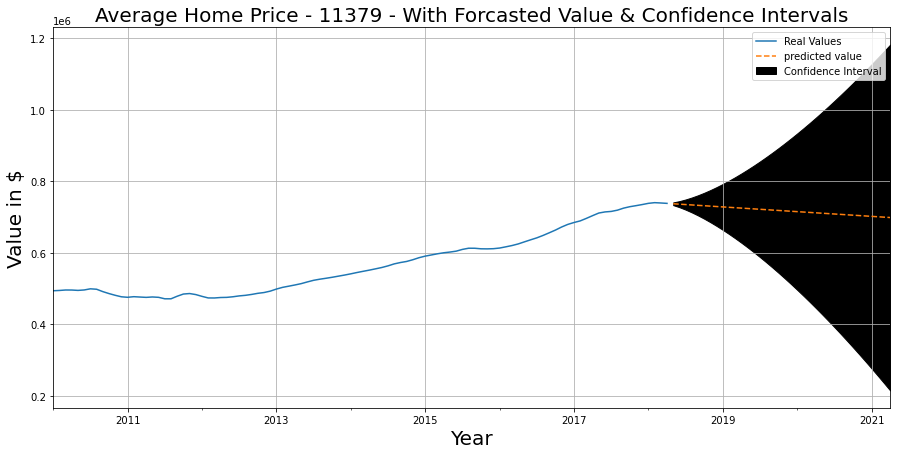

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11379   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -871.926
Date:                Mon, 14 Mar 2022   AIC                           1745.853
Time:                        12:08:44   BIC                           1748.427
Sample:                    01-01-2010   HQIC                          1746.894
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.757e+06   3.93e+05      9.565      0.000    2.99e+06    4.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.82   Jarque-Bera (JB):                12.70
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9986968753365744
MAE:
	 1221.4285714285713
RMSE:
	 1551.2667634641605
r^2:
	 0.9986951047115805


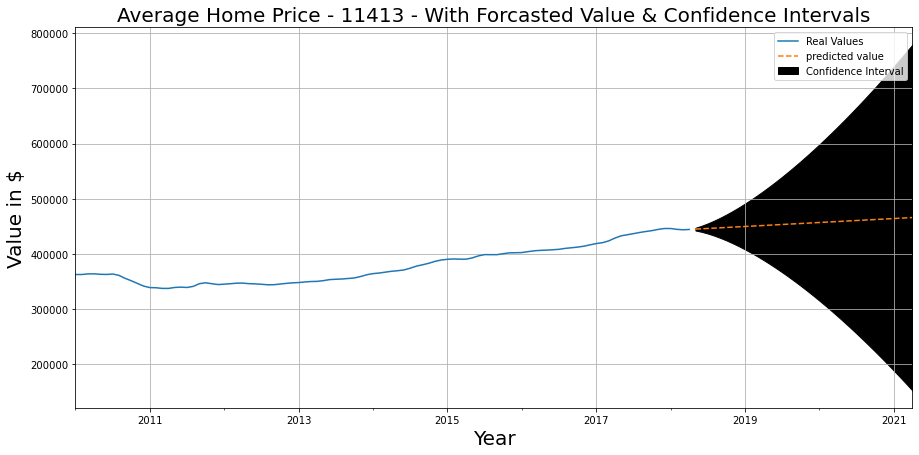

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11413   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -829.890
Date:                Mon, 14 Mar 2022   AIC                           1661.780
Time:                        12:08:45   BIC                           1664.355
Sample:                    01-01-2010   HQIC                          1662.822
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.58e+06   2.09e+05      7.569      0.000    1.17e+06    1.99e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.94   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.09   Prob(JB):                         0.48
Heteroskedasticity (H):               0.34   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9963132190135765
MAE:
	 735.7142857142857
RMSE:
	 947.5532401174843
r^2:
	 0.9963123808230602


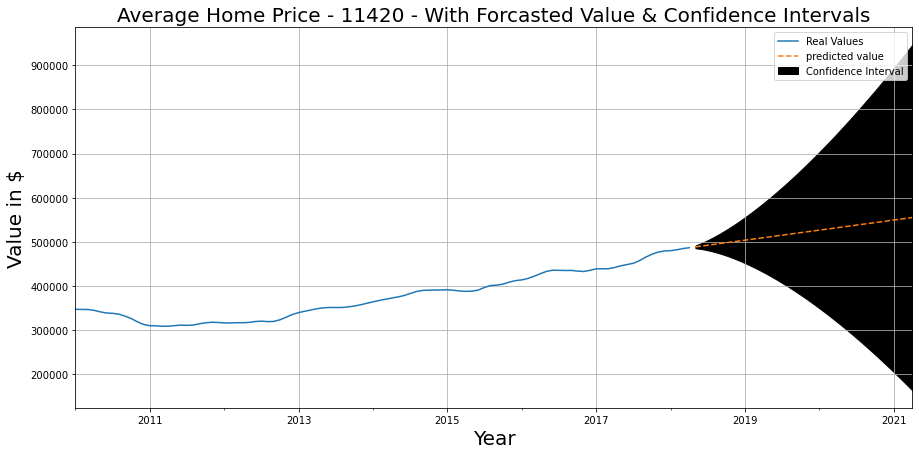

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11420   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -851.576
Date:                Mon, 14 Mar 2022   AIC                           1705.153
Time:                        12:08:45   BIC                           1707.727
Sample:                    01-01-2010   HQIC                          1706.194
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.469e+06   4.13e+05      5.977      0.000    1.66e+06    3.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.26   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               1.29   Skew:                             0.15
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.992963178688981
MAE:
	 1482.1428571428655
RMSE:
	 1791.9462683271192
r^2:
	 0.9929584516537294


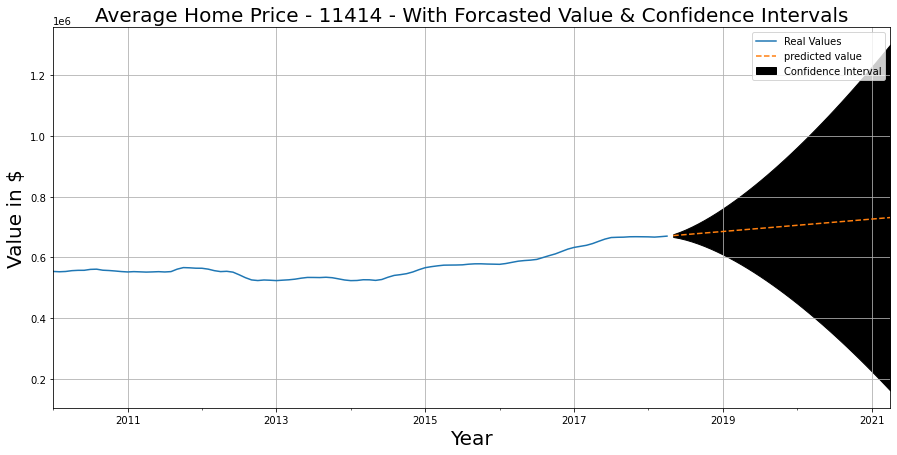

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11414   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -888.663
Date:                Mon, 14 Mar 2022   AIC                           1779.326
Time:                        12:08:46   BIC                           1781.901
Sample:                    01-01-2010   HQIC                          1780.367
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.208e+06   6.71e+05      7.761      0.000    3.89e+06    6.52e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.36   Jarque-Bera (JB):                 1.06
Prob(Q):                              0.07   Prob(JB):                         0.59
Heteroskedasticity (H):               0.30   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9973662169340313
MAE:
	 1260.7142857142858
RMSE:
	 1721.6063927125072
r^2:
	 0.9973612089862706


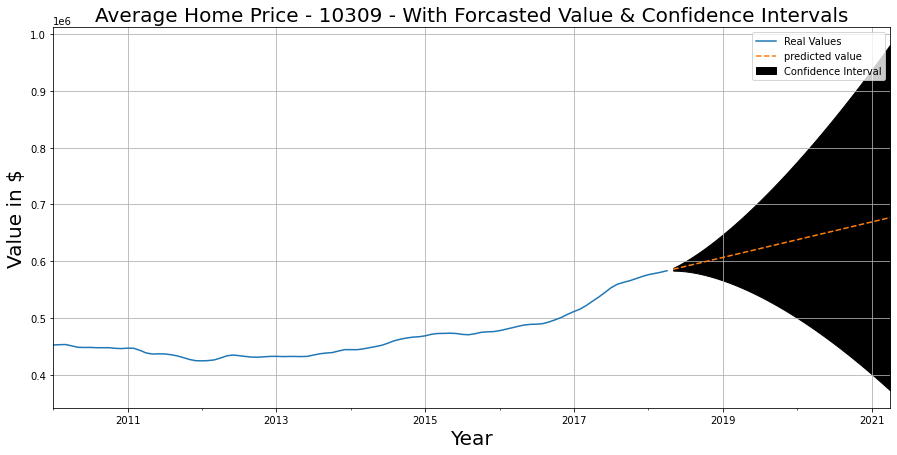

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10309   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -826.983
Date:                Mon, 14 Mar 2022   AIC                           1655.966
Time:                        12:08:46   BIC                           1658.541
Sample:                    01-01-2010   HQIC                          1657.007
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.487e+06   2.05e+05      7.269      0.000    1.09e+06    1.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.07   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               0.61   Skew:                            -0.30
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9991073991227813
MAE:
	 857.1428571428571
RMSE:
	 1096.7484410096706
r^2:
	 0.9991027943602085


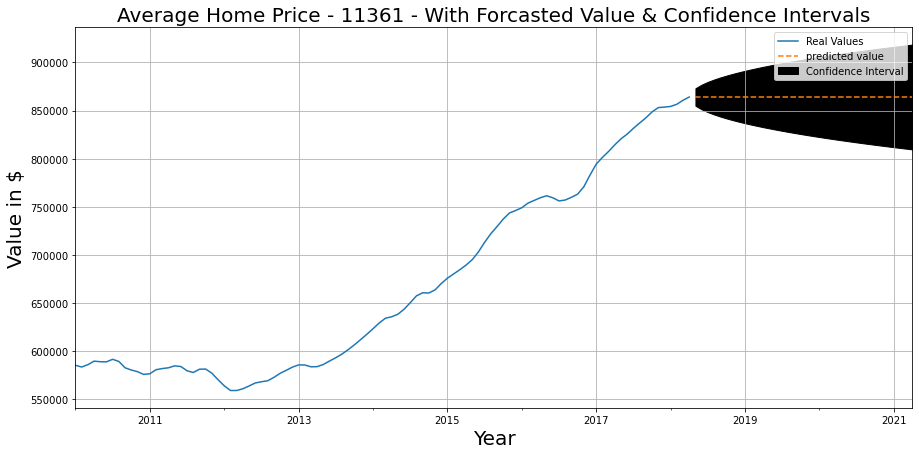

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11361   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -967.151
Date:                Mon, 14 Mar 2022   AIC                           1936.302
Time:                        12:08:47   BIC                           1938.887
Sample:                    01-01-2010   HQIC                          1937.348
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.145e+07   3.62e+06      5.924      0.000    1.44e+07    2.85e+07
===================================================================================
Ljung-Box (L1) (Q):                  65.22   Jarque-Bera (JB):                 2.96
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               3.06   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9933158042679334
MAE:
	 4596.428571428572
RMSE:
	 5368.2598936447075
r^2:
	 0.9826276283765653


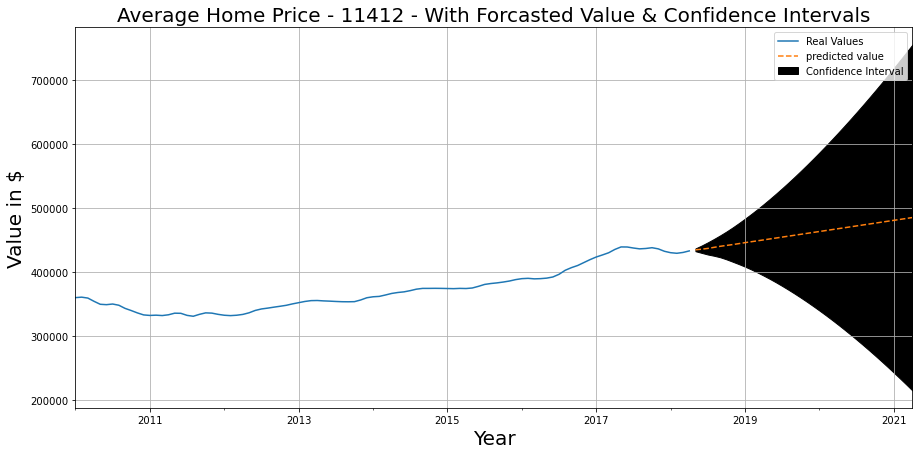

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11412   No. Observations:                  100
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -799.807
Date:                Mon, 14 Mar 2022   AIC                           1609.613
Time:                        12:08:49   BIC                           1622.383
Sample:                    01-01-2010   HQIC                          1614.773
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1931      0.116      1.671      0.095      -0.033       0.420
ar.L2         -0.5678      0.088     -6.421      0.000      -0.741      -0.394
ma.L1          0.2817      0.147      1.918      0.055      -0.006       0.569
ma.L2          0.0533      0.095      0.559      0.576      -0.134       0.240
sigma2      1.202e+06   1.77e+05      6.790      0.000    8.55e+05    1.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.96   Prob(JB):                         0.57
Heteroskedasticity (H):               1.07   Skew:                             0.27
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9949091178195644
MAE:
	 1109.1146968248443
RMSE:
	 1320.7332816324383
r^2:
	 0.9949075194217984


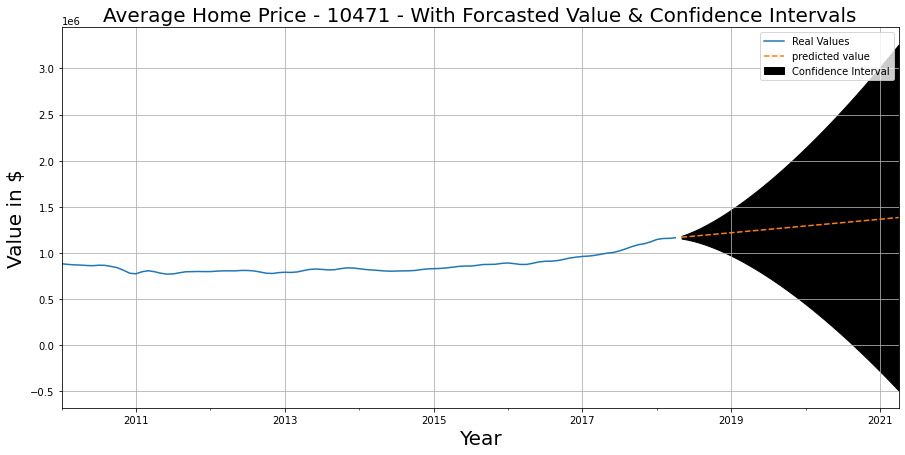

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10471   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1004.773
Date:                Mon, 14 Mar 2022   AIC                           2011.546
Time:                        12:08:50   BIC                           2014.120
Sample:                    01-01-2010   HQIC                          2012.587
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.647e+07   5.48e+06     10.302      0.000    4.57e+07    6.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   7.64   Jarque-Bera (JB):                23.91
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.62
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9948078799080577
MAE:
	 5853.571428571428
RMSE:
	 6826.393107428173
r^2:
	 0.9948063317923024


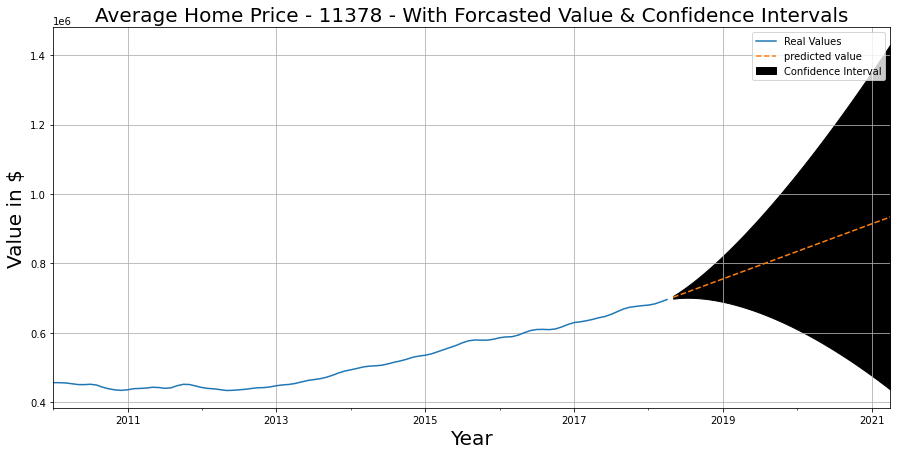

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11378   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -874.469
Date:                Mon, 14 Mar 2022   AIC                           1750.937
Time:                        12:08:50   BIC                           1753.512
Sample:                    01-01-2010   HQIC                          1751.979
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.959e+06    6.7e+05      5.905      0.000    2.65e+06    5.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.42   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               0.88   Skew:                            -0.15
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9960630529802408
MAE:
	 1850.0
RMSE:
	 2119.1305494740727
r^2:
	 0.9960450797463402


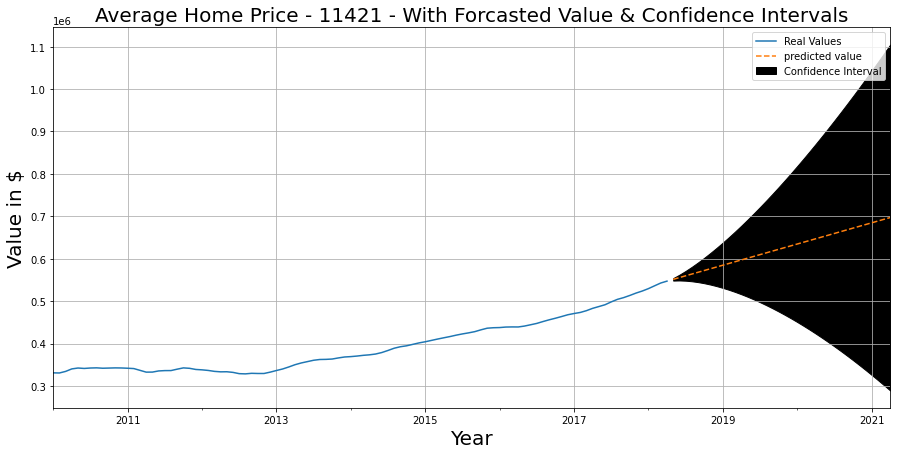

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11421   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -845.928
Date:                Mon, 14 Mar 2022   AIC                           1695.855
Time:                        12:08:51   BIC                           1701.005
Sample:                    01-01-2010   HQIC                          1697.938
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0967      0.092      1.054      0.292      -0.083       0.276
sigma2        2.2e+06   2.81e+05      7.828      0.000    1.65e+06    2.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.76   Prob(JB):                         0.54
Heteroskedasticity (H):               0.35   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9989155209117714
MAE:
	 932.1428571428488
RMSE:
	 1142.709038263748
r^2:
	 0.9989057114843608


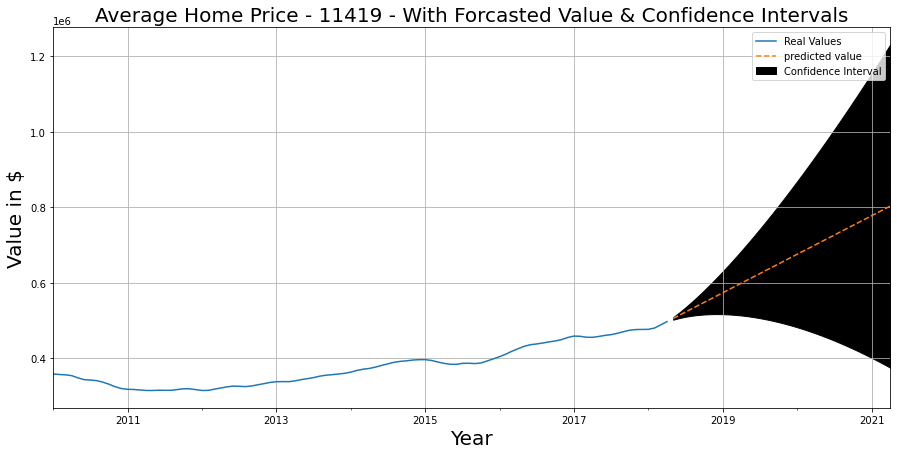

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11419   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -860.067
Date:                Mon, 14 Mar 2022   AIC                           1722.134
Time:                        12:08:51   BIC                           1724.709
Sample:                    01-01-2010   HQIC                          1723.175
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.942e+06   4.33e+05      6.790      0.000    2.09e+06    3.79e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.98   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.00   Prob(JB):                         0.70
Heteroskedasticity (H):               1.21   Skew:                             0.20
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9927892455153482
MAE:
	 1496.4285714285713
RMSE:
	 1908.1591727556242
r^2:
	 0.9927679389809229


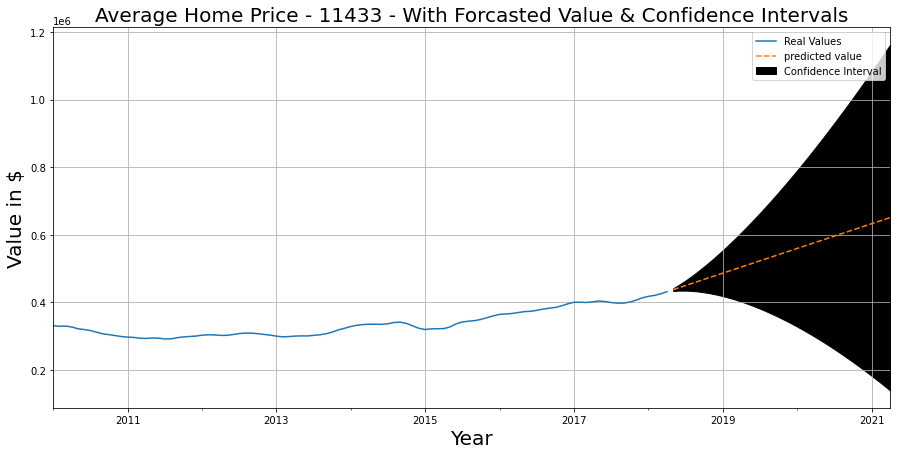

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11433   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -878.146
Date:                Mon, 14 Mar 2022   AIC                           1758.291
Time:                        12:08:52   BIC                           1760.866
Sample:                    01-01-2010   HQIC                          1759.332
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.214e+06   6.56e+05      6.419      0.000    2.93e+06     5.5e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.47   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.01   Prob(JB):                         0.75
Heteroskedasticity (H):               1.21   Skew:                             0.06
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9877883537438373
MAE:
	 1735.7142857142858
RMSE:
	 2006.9522024346127
r^2:
	 0.9877858783055996


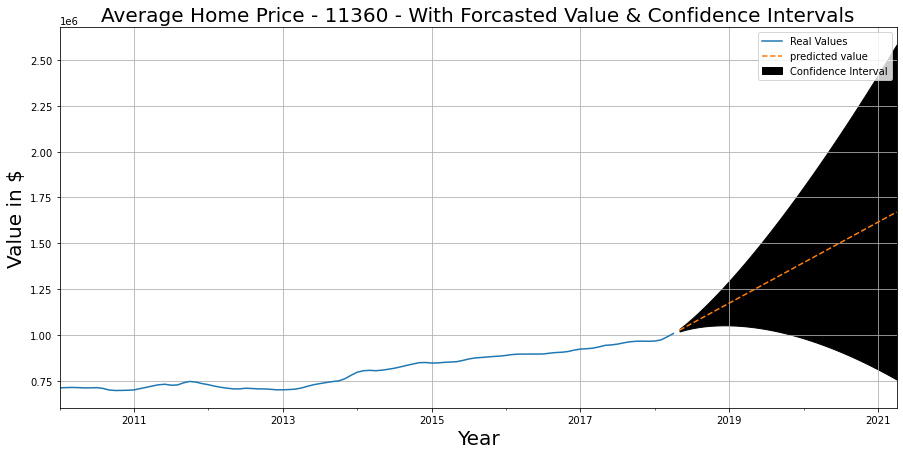

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11360   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -935.039
Date:                Mon, 14 Mar 2022   AIC                           1872.077
Time:                        12:08:52   BIC                           1874.652
Sample:                    01-01-2010   HQIC                          1873.118
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.339e+07   1.56e+06      8.597      0.000    1.03e+07    1.64e+07
===================================================================================
Ljung-Box (L1) (Q):                   7.17   Jarque-Bera (JB):                 3.07
Prob(Q):                              0.01   Prob(JB):                         0.21
Heteroskedasticity (H):               0.49   Skew:                            -0.01
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9910638140618409
MAE:
	 2471.4285714285716
RMSE:
	 3193.8557083428623
r^2:
	 0.9907528212858552


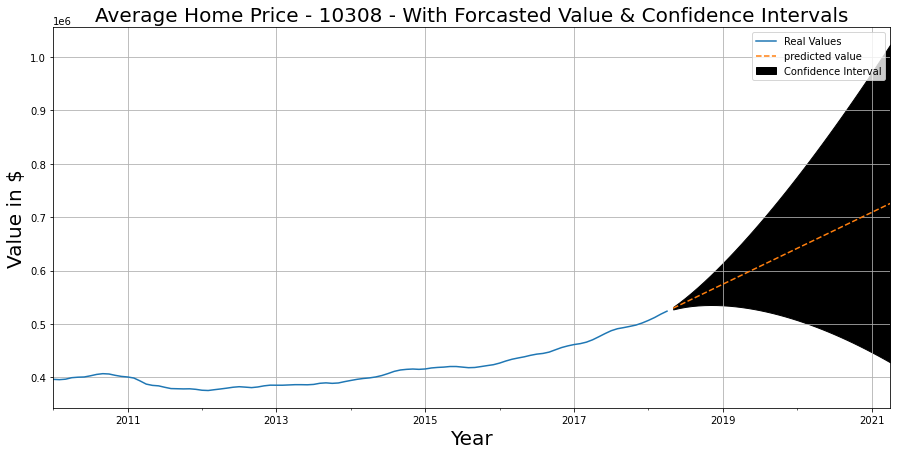

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10308   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -824.728
Date:                Mon, 14 Mar 2022   AIC                           1651.456
Time:                        12:08:53   BIC                           1654.030
Sample:                    01-01-2010   HQIC                          1652.497
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.421e+06   2.03e+05      7.001      0.000    1.02e+06    1.82e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.36   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.02   Prob(JB):                         0.99
Heteroskedasticity (H):               0.43   Skew:                             0.02
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.998789789839651
MAE:
	 875.0
RMSE:
	 997.317831557652
r^2:
	 0.9987657151113144


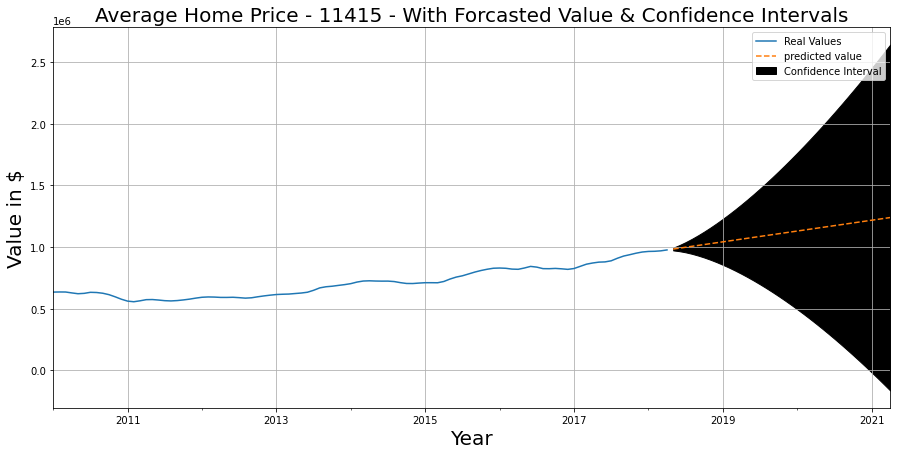

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11415   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -976.658
Date:                Mon, 14 Mar 2022   AIC                           1955.316
Time:                        12:08:53   BIC                           1957.891
Sample:                    01-01-2010   HQIC                          1956.357
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.161e+07      4e+06      7.896      0.000    2.38e+07    3.95e+07
===================================================================================
Ljung-Box (L1) (Q):                   9.17   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               1.61   Skew:                             0.12
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9832936786005974
MAE:
	 5878.571428571428
RMSE:
	 7235.92229287818
r^2:
	 0.9832934181269892


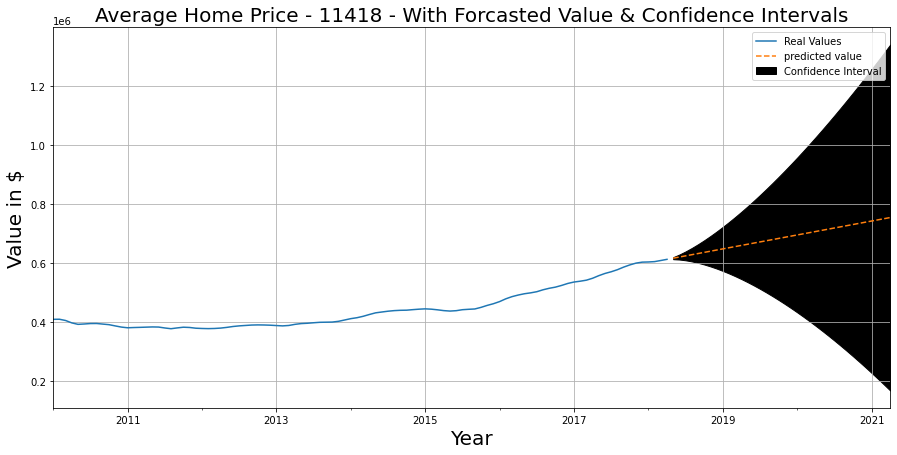

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11418   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -862.505
Date:                Mon, 14 Mar 2022   AIC                           1729.010
Time:                        12:08:54   BIC                           1734.159
Sample:                    01-01-2010   HQIC                          1731.092
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2619      0.088      2.968      0.003       0.089       0.435
sigma2      3.096e+06   4.24e+05      7.297      0.000    2.26e+06    3.93e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 6.04
Prob(Q):                              0.24   Prob(JB):                         0.05
Heteroskedasticity (H):               0.80   Skew:                             0.61
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9984486351367052
MAE:
	 1626.6160773780139
RMSE:
	 1741.9051365801674
r^2:
	 0.9984479287824506


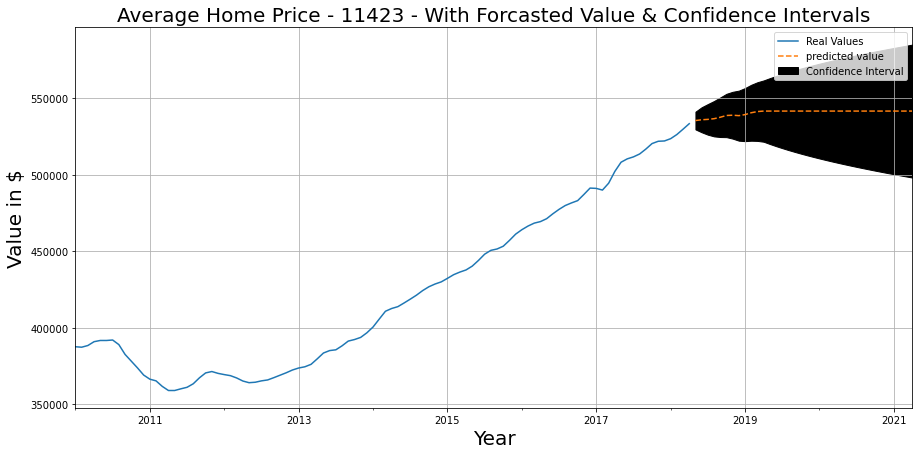

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11423   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -795.463
Date:                              Mon, 14 Mar 2022   AIC                           1594.927
Time:                                      12:08:55   BIC                           1599.835
Sample:                                  01-01-2010   HQIC                          1596.902
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.3612      0.170      2.119      0.034       0.027       0.695
sigma2      8.708e+06   1.85e+06      4.710      0.000    5.08e+06    1.23e+07
===================================================================================
Ljung-Box (L1) (Q):                  28.48   Jarque-Bera (JB):                 5.72
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.42   Skew:                             0.14
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9927277516023868
MAE:
	 2169.5145069954992
RMSE:
	 2644.9403352170007
r^2:
	 0.9850005853811927


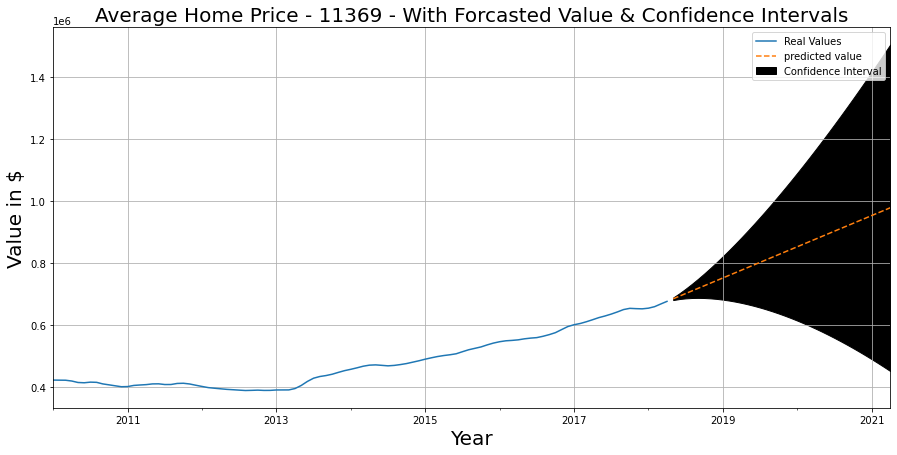

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11369   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -880.338
Date:                Mon, 14 Mar 2022   AIC                           1762.677
Time:                        12:08:56   BIC                           1765.251
Sample:                    01-01-2010   HQIC                          1763.718
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.468e+06   6.67e+05      6.701      0.000    3.16e+06    5.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.53   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               0.90   Skew:                            -0.04
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.997473256577398
MAE:
	 1707.142857142857
RMSE:
	 2133.5751351060635
r^2:
	 0.9974684614594523


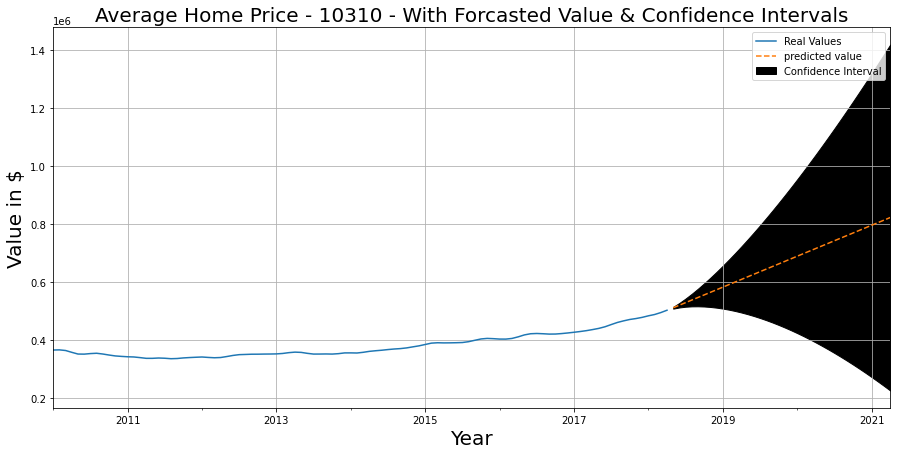

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10310   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -850.611
Date:                Mon, 14 Mar 2022   AIC                           1705.221
Time:                        12:08:56   BIC                           1710.371
Sample:                    01-01-2010   HQIC                          1707.303
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3651      0.117      3.128      0.002       0.136       0.594
sigma2      2.423e+06   3.08e+05      7.856      0.000    1.82e+06    3.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.17   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.08   Prob(JB):                         0.49
Heteroskedasticity (H):               0.61   Skew:                             0.03
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9979515632057051
MAE:
	 1064.3908017555784
RMSE:
	 1346.0050735168672
r^2:
	 0.9978729028805704


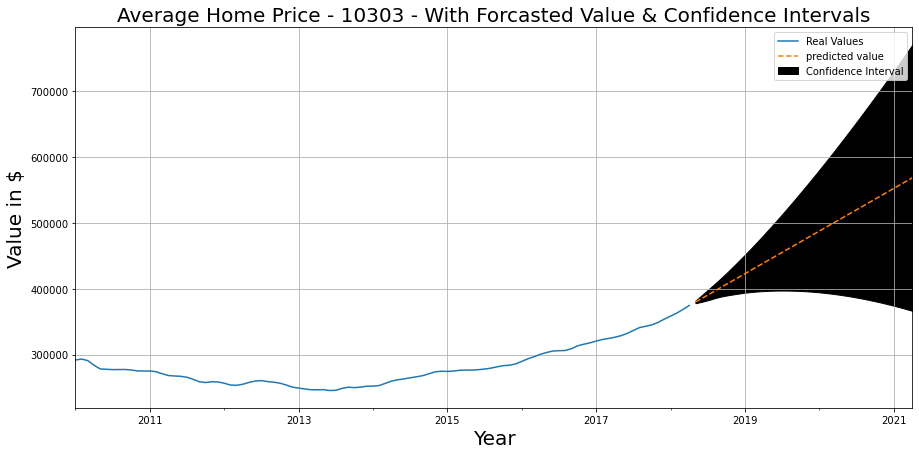

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10303   No. Observations:                  100
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -801.903
Date:                Mon, 14 Mar 2022   AIC                           1609.805
Time:                        12:08:57   BIC                           1617.498
Sample:                    01-01-2010   HQIC                          1612.915
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2710      0.086      3.146      0.002       0.102       0.440
ar.L2         -0.5747      0.053    -10.812      0.000      -0.679      -0.471
sigma2      1.054e+06   1.62e+05      6.512      0.000    7.37e+05    1.37e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.93   Prob(JB):                         0.49
Heteroskedasticity (H):               0.55   Skew:                             0.20
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9985314332687131
MAE:
	 718.6253588166063
RMSE:
	 904.8019070486323
r^2:
	 0.9984908553080778


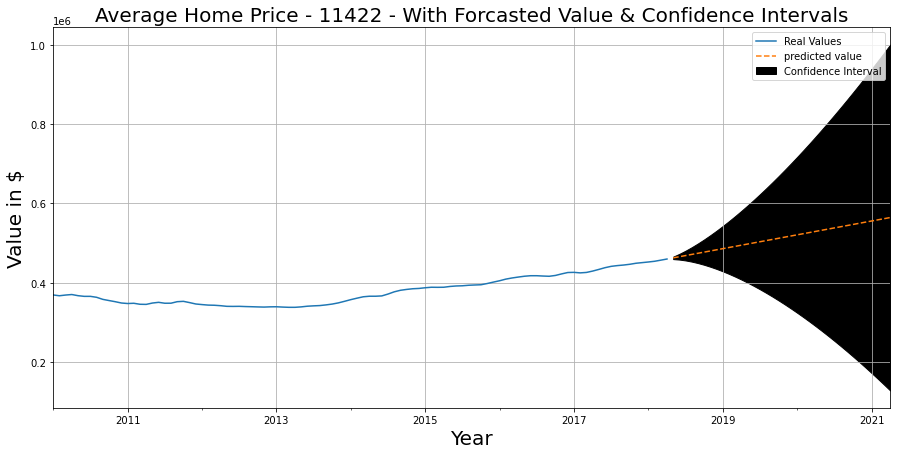

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11422   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -852.955
Date:                Mon, 14 Mar 2022   AIC                           1709.911
Time:                        12:08:57   BIC                           1715.060
Sample:                    01-01-2010   HQIC                          1711.993
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0931      0.080      1.164      0.244      -0.064       0.250
sigma2      2.543e+06   3.39e+05      7.509      0.000    1.88e+06    3.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.46   Prob(JB):                         0.58
Heteroskedasticity (H):               0.33   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9938641276702969
MAE:
	 956.180776281958
RMSE:
	 1247.8890620312507
r^2:
	 0.9938618568420349


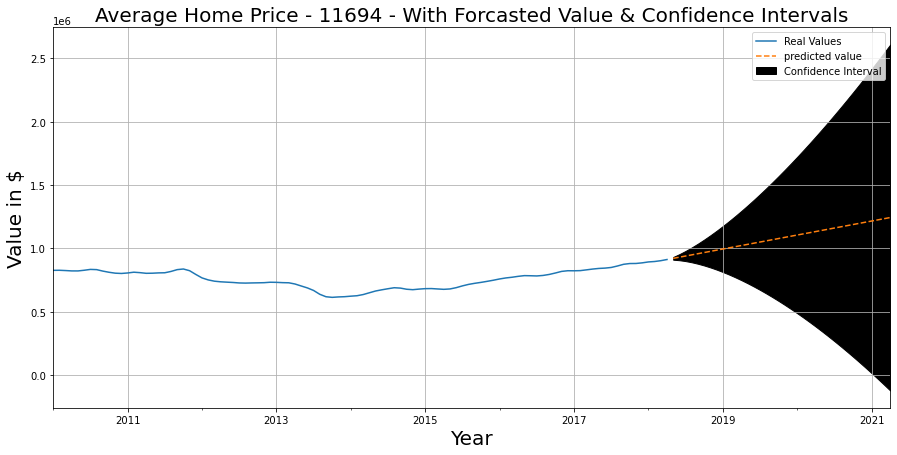

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11694   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -973.886
Date:                Mon, 14 Mar 2022   AIC                           1949.773
Time:                        12:08:58   BIC                           1952.348
Sample:                    01-01-2010   HQIC                          1950.814
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.991e+07   3.43e+06      8.725      0.000    2.32e+07    3.66e+07
===================================================================================
Ljung-Box (L1) (Q):                  16.12   Jarque-Bera (JB):                 9.04
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.32   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9925007647759763
MAE:
	 3342.8571428571427
RMSE:
	 3930.2853404228626
r^2:
	 0.9925006656976935


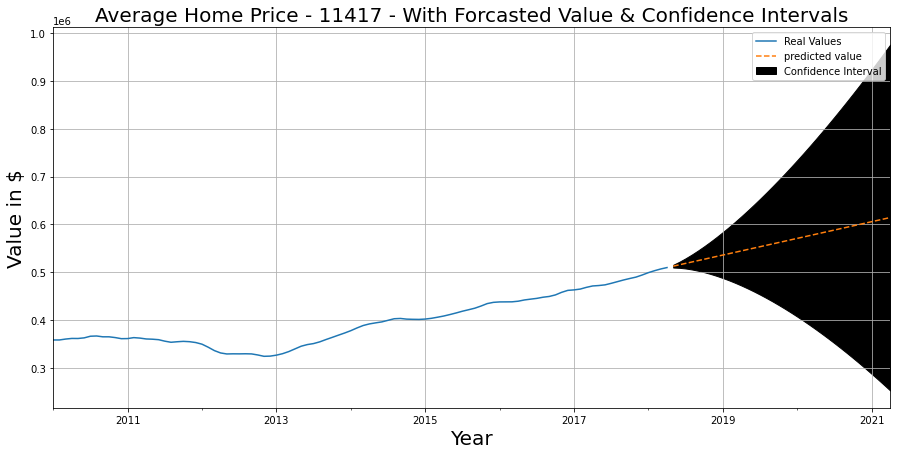

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11417   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -844.147
Date:                Mon, 14 Mar 2022   AIC                           1690.293
Time:                        12:08:58   BIC                           1692.868
Sample:                    01-01-2010   HQIC                          1691.334
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.093e+06   3.38e+05      6.185      0.000    1.43e+06    2.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.99   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.03   Prob(JB):                         0.63
Heteroskedasticity (H):               0.50   Skew:                            -0.07
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9968621120030555
MAE:
	 1010.7142857142836
RMSE:
	 1249.4284407565829
r^2:
	 0.9968618812364046


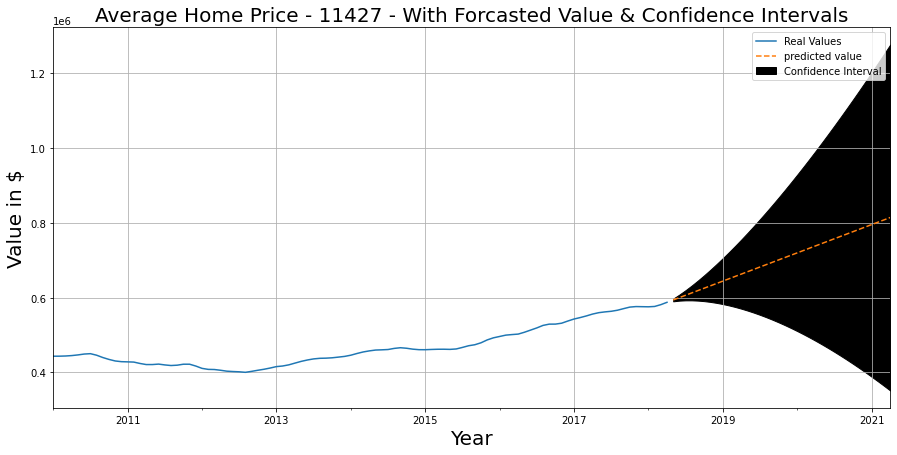

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11427   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -867.645
Date:                Mon, 14 Mar 2022   AIC                           1737.289
Time:                        12:08:59   BIC                           1739.864
Sample:                    01-01-2010   HQIC                          1738.330
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.439e+06   4.92e+05      6.985      0.000    2.47e+06     4.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.06   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.01   Prob(JB):                         0.55
Heteroskedasticity (H):               0.79   Skew:                            -0.27
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9954346247678182
MAE:
	 1510.7142857142858
RMSE:
	 1908.5334683992314
r^2:
	 0.9954338412814218


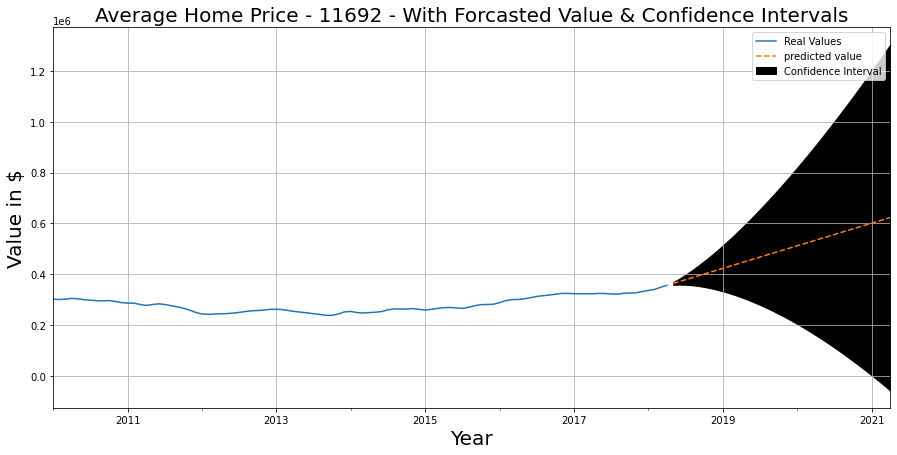

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11692   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -906.170
Date:                Mon, 14 Mar 2022   AIC                           1814.341
Time:                        12:08:59   BIC                           1816.916
Sample:                    01-01-2010   HQIC                          1815.382
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.423e+06   1.05e+06      7.051      0.000    5.36e+06    9.49e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.17   Prob(JB):                         0.99
Heteroskedasticity (H):               0.74   Skew:                             0.03
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9739451509828428
MAE:
	 1850.0
RMSE:
	 2378.7751950471124
r^2:
	 0.9736867828445455


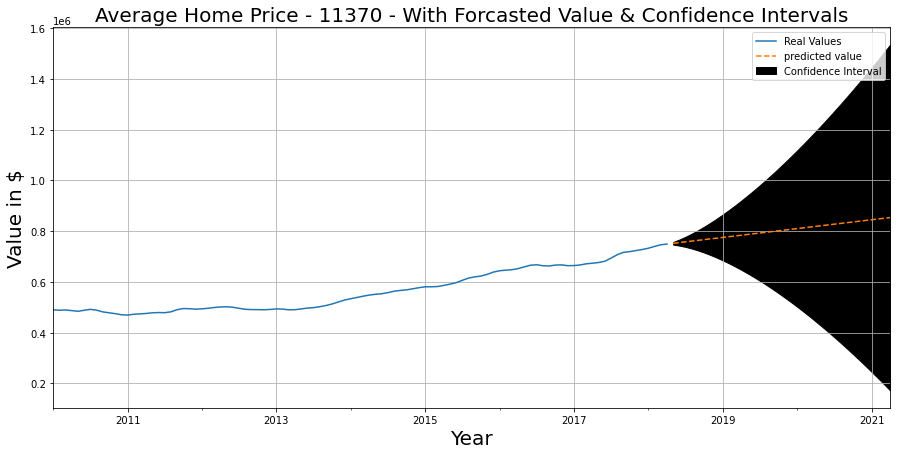

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11370   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -906.106
Date:                Mon, 14 Mar 2022   AIC                           1814.212
Time:                        12:09:00   BIC                           1816.787
Sample:                    01-01-2010   HQIC                          1815.253
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.463e+06   1.08e+06      6.919      0.000    5.35e+06    9.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.74   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.05   Prob(JB):                         0.92
Heteroskedasticity (H):               1.20   Skew:                            -0.09
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9895937046460317
MAE:
	 2760.714285714286
RMSE:
	 3311.937283740224
r^2:
	 0.9895484817069687


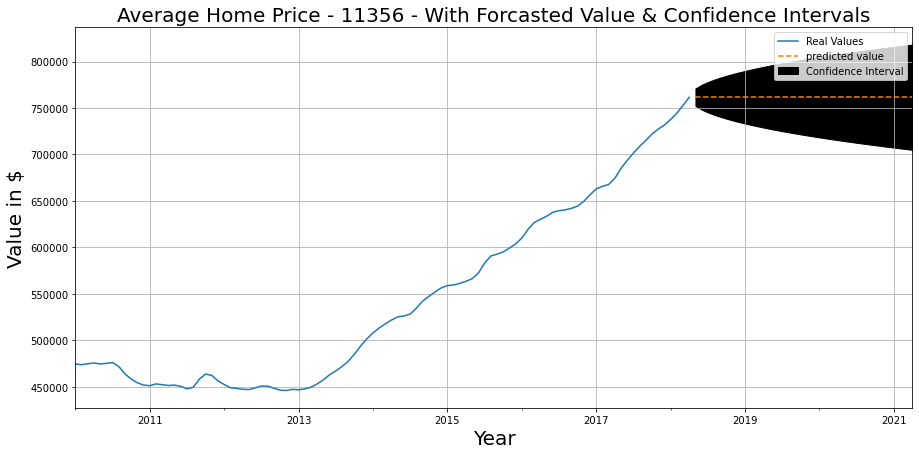

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11356   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -971.073
Date:                Mon, 14 Mar 2022   AIC                           1944.145
Time:                        12:09:00   BIC                           1946.730
Sample:                    01-01-2010   HQIC                          1945.191
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.32e+07   4.12e+06      5.630      0.000    1.51e+07    3.13e+07
===================================================================================
Ljung-Box (L1) (Q):                  66.25   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               3.39   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9966450913016984
MAE:
	 5639.285714285715
RMSE:
	 6192.3628077541725
r^2:
	 0.9803409484696068


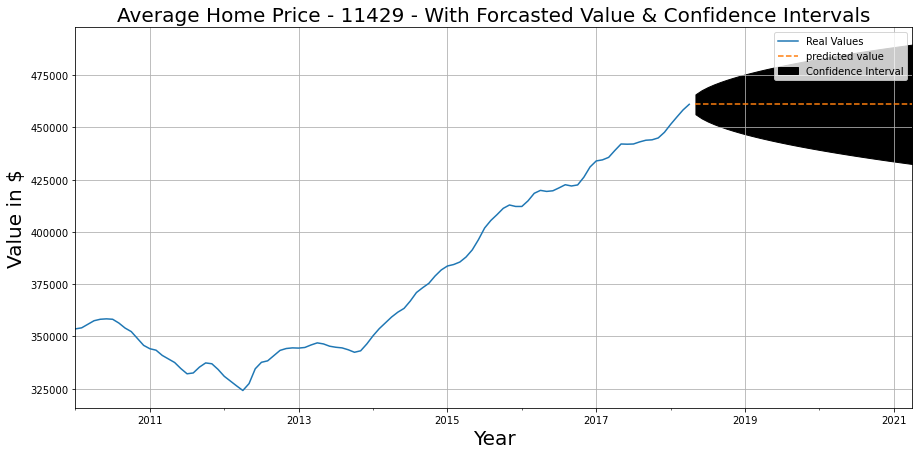

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11429   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -904.053
Date:                Mon, 14 Mar 2022   AIC                           1810.106
Time:                        12:09:01   BIC                           1812.691
Sample:                    01-01-2010   HQIC                          1811.152
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.91e+06   9.53e+05      6.201      0.000    4.04e+06    7.78e+06
===================================================================================
Ljung-Box (L1) (Q):                  57.56   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.00   Prob(JB):                         0.58
Heteroskedasticity (H):               0.92   Skew:                            -0.07
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9874307202155512
MAE:
	 1832.142857142857
RMSE:
	 2322.329495509689
r^2:
	 0.9710700004207846


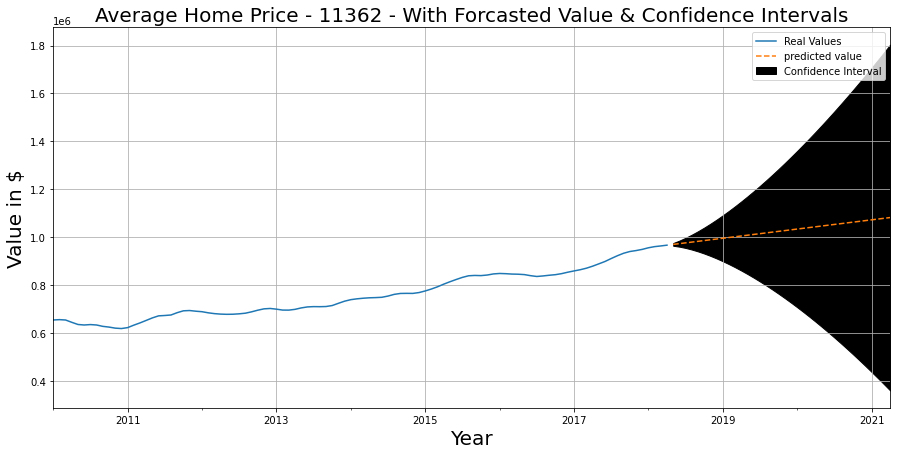

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11362   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -911.634
Date:                Mon, 14 Mar 2022   AIC                           1825.268
Time:                        12:09:02   BIC                           1827.843
Sample:                    01-01-2010   HQIC                          1826.309
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.353e+06   1.09e+06      7.653      0.000    6.21e+06    1.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   9.95   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.00   Prob(JB):                         0.81
Heteroskedasticity (H):               0.35   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9981268623437347
MAE:
	 1642.857142857143
RMSE:
	 2004.63748058631
r^2:
	 0.9981256963176259


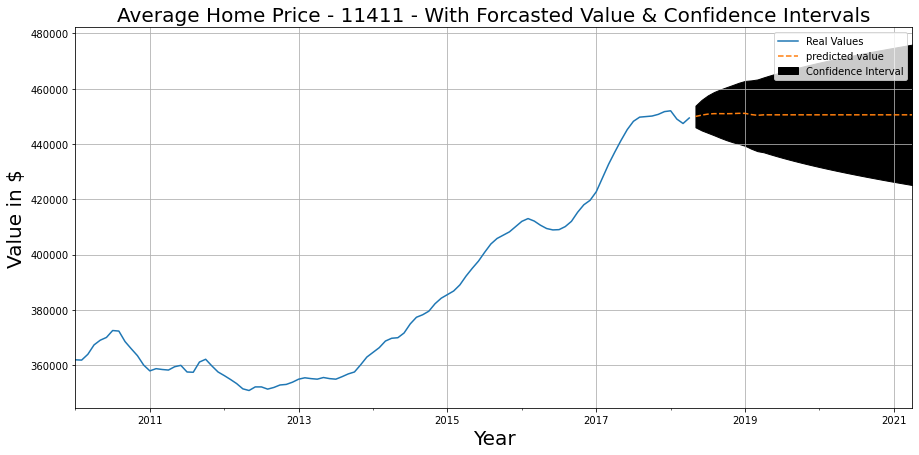

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11411   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -775.579
Date:                              Mon, 14 Mar 2022   AIC                           1555.158
Time:                                      12:09:03   BIC                           1560.067
Sample:                                  01-01-2010   HQIC                          1557.134
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.1223      0.114      1.069      0.285      -0.102       0.347
sigma2      3.982e+06   6.64e+05      5.995      0.000    2.68e+06    5.28e+06
===================================================================================
Ljung-Box (L1) (Q):                  45.72   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               3.58   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9828386413234489
MAE:
	 2028.059959345626
RMSE:
	 2542.970406682981
r^2:
	 0.977968663836583


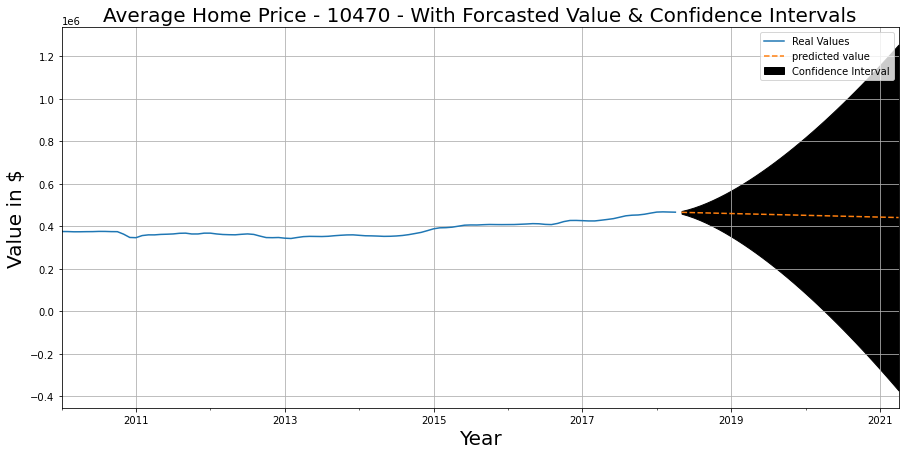

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10470   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -923.905
Date:                Mon, 14 Mar 2022   AIC                           1849.810
Time:                        12:09:04   BIC                           1852.385
Sample:                    01-01-2010   HQIC                          1850.851
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.065e+07   8.13e+05     13.100      0.000    9.06e+06    1.22e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):                96.28
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9861240544363727
MAE:
	 1846.4285714285713
RMSE:
	 2467.575443918295
r^2:
	 0.9861233277142207


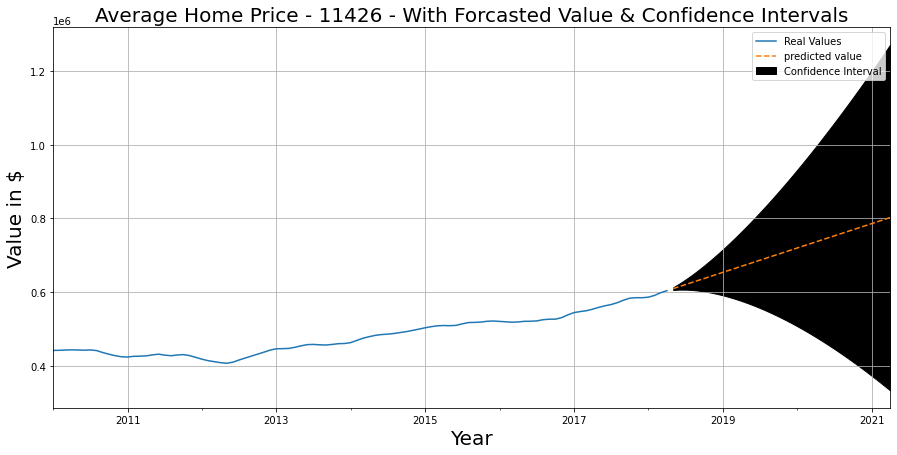

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11426   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -868.848
Date:                Mon, 14 Mar 2022   AIC                           1739.696
Time:                        12:09:04   BIC                           1742.271
Sample:                    01-01-2010   HQIC                          1740.737
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.526e+06   5.35e+05      6.596      0.000    2.48e+06    4.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.86   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.01   Prob(JB):                         0.92
Heteroskedasticity (H):               1.01   Skew:                            -0.01
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9946500056313674
MAE:
	 1750.0
RMSE:
	 2054.7853554916283
r^2:
	 0.9946125065834917


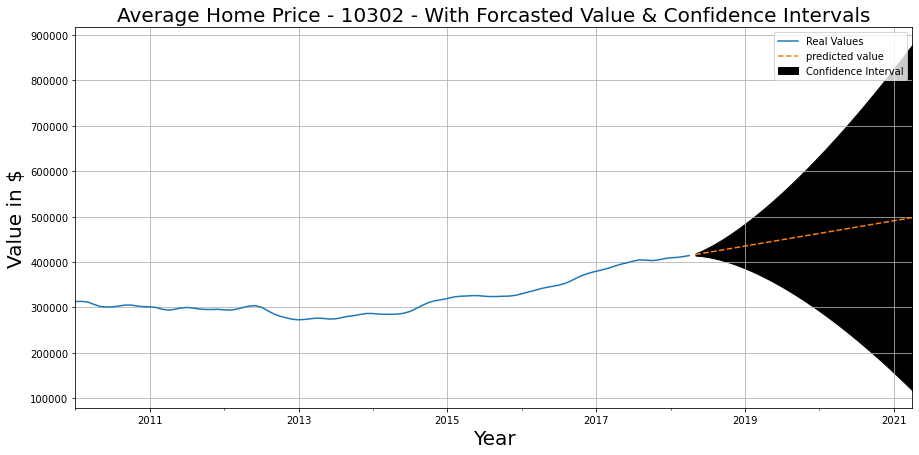

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10302   No. Observations:                  100
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -832.836
Date:                Mon, 14 Mar 2022   AIC                           1669.672
Time:                        12:09:05   BIC                           1674.801
Sample:                    01-01-2010   HQIC                          1671.745
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3034      0.013     22.795      0.000       0.277       0.329
sigma2      1.399e+06   1.65e+05      8.499      0.000    1.08e+06    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                  15.57   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.00   Prob(JB):                         0.93
Heteroskedasticity (H):               0.35   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9984120119200094
MAE:
	 902.1203359152506
RMSE:
	 1091.807526245556
r^2:
	 0.9984119699269


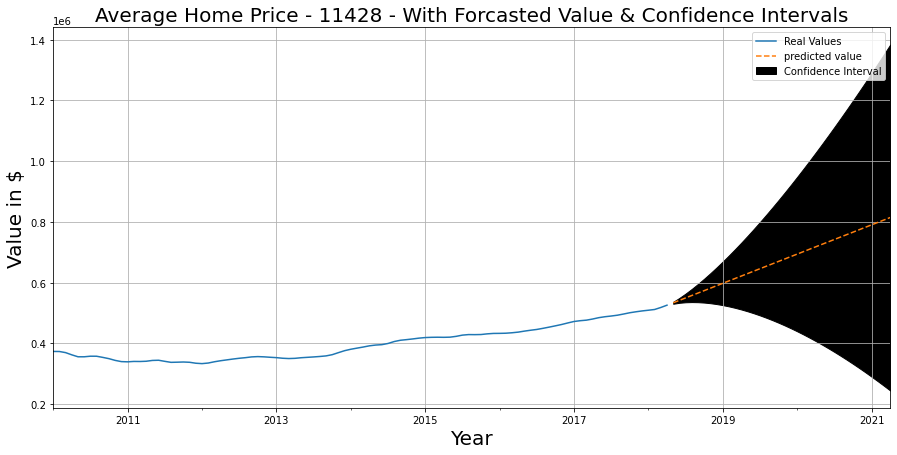

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11428   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -855.391
Date:                Mon, 14 Mar 2022   AIC                           1714.781
Time:                        12:09:06   BIC                           1719.931
Sample:                    01-01-2010   HQIC                          1716.864
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2959      0.102      2.899      0.004       0.096       0.496
sigma2      2.674e+06    3.1e+05      8.620      0.000    2.07e+06    3.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.27   Jarque-Bera (JB):                 8.90
Prob(Q):                              0.13   Prob(JB):                         0.01
Heteroskedasticity (H):               0.30   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9982927854292396
MAE:
	 788.335597237067
RMSE:
	 1171.1480552923676
r^2:
	 0.998253825905907


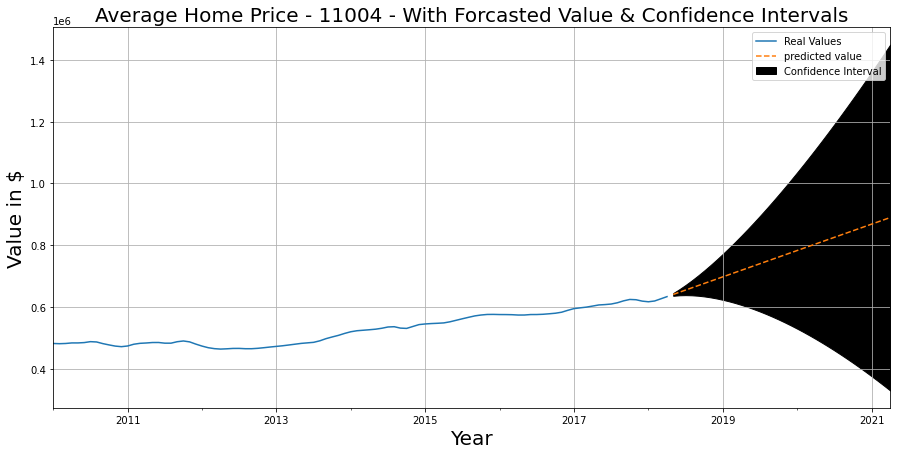

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11004   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -887.009
Date:                Mon, 14 Mar 2022   AIC                           1776.017
Time:                        12:09:06   BIC                           1778.592
Sample:                    01-01-2010   HQIC                          1777.058
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.019e+06   6.11e+05      8.215      0.000    3.82e+06    6.22e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.48   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.00   Prob(JB):                         0.40
Heteroskedasticity (H):               0.74   Skew:                            -0.05
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9875413676086959
MAE:
	 1682.142857142857
RMSE:
	 2216.093731901119
r^2:
	 0.9873853836584321


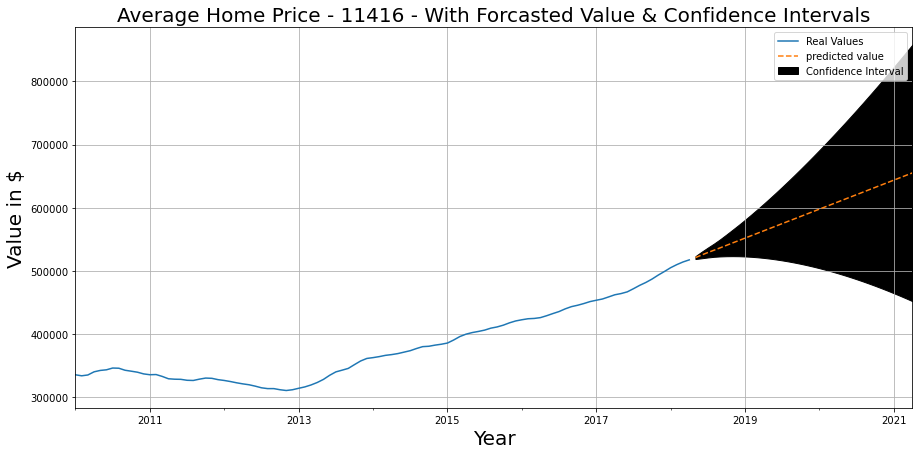

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11416   No. Observations:                  100
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -813.752
Date:                Mon, 14 Mar 2022   AIC                           1633.505
Time:                        12:09:07   BIC                           1641.198
Sample:                    01-01-2010   HQIC                          1636.614
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0427      0.083      0.513      0.608      -0.120       0.206
ar.L2         -0.5076      0.085     -5.979      0.000      -0.674      -0.341
sigma2       1.35e+06    1.9e+05      7.109      0.000    9.77e+05    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.41   Jarque-Bera (JB):                 4.16
Prob(Q):                              0.06   Prob(JB):                         0.12
Heteroskedasticity (H):               0.45   Skew:                            -0.50
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9991044955206263
MAE:
	 762.1098103236062
RMSE:
	 869.3092809586024
r^2:
	 0.9991017545398916


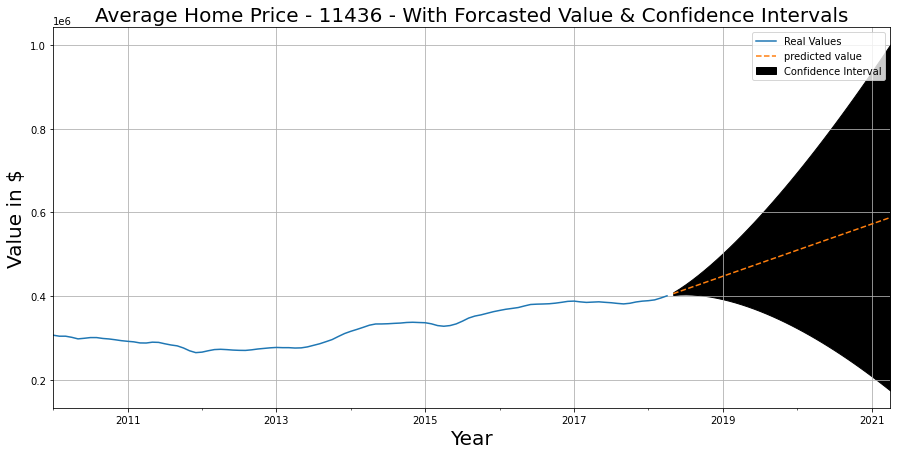

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11436   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -857.151
Date:                Mon, 14 Mar 2022   AIC                           1716.301
Time:                        12:09:07   BIC                           1718.876
Sample:                    01-01-2010   HQIC                          1717.342
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.747e+06   3.35e+05      8.190      0.000    2.09e+06     3.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):                 6.15
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.45   Skew:                             0.52
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9673392712489733
MAE:
	 1035.7142857142858
RMSE:
	 1332.5592991361718
r^2:
	 0.9672932238972599


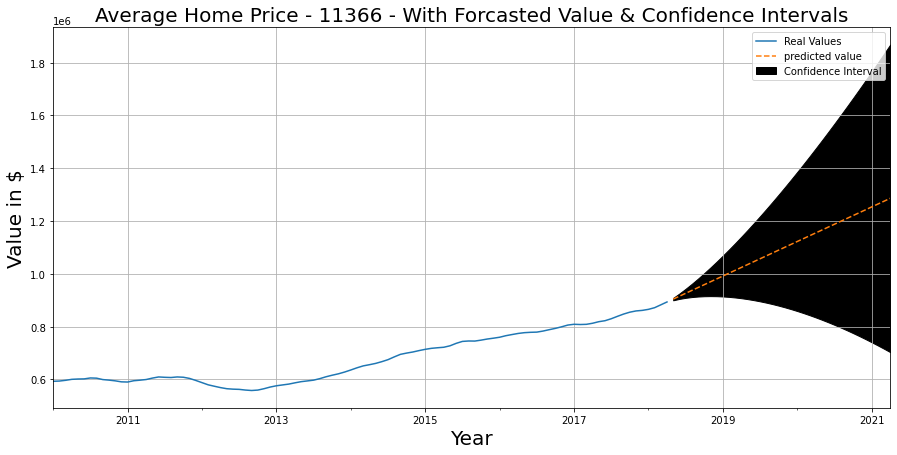

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11366   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -890.856
Date:                Mon, 14 Mar 2022   AIC                           1783.711
Time:                        12:09:08   BIC                           1786.286
Sample:                    01-01-2010   HQIC                          1784.752
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.447e+06   8.45e+05      6.448      0.000    3.79e+06     7.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.28   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.07   Prob(JB):                         0.62
Heteroskedasticity (H):               0.65   Skew:                            -0.18
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9966313924217566
MAE:
	 1846.4285714285713
RMSE:
	 2208.3445642122324
r^2:
	 0.9965783321383658


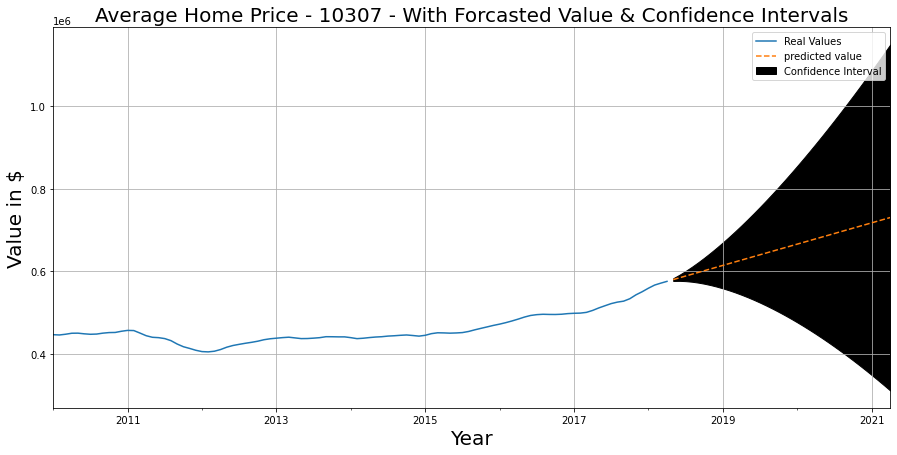

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10307   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -858.475
Date:                Mon, 14 Mar 2022   AIC                           1718.951
Time:                        12:09:08   BIC                           1721.525
Sample:                    01-01-2010   HQIC                          1719.992
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.826e+06   3.68e+05      7.672      0.000     2.1e+06    3.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.72   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.01   Prob(JB):                         0.65
Heteroskedasticity (H):               0.53   Skew:                            -0.12
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9971543455661575
MAE:
	 1232.142857142857
RMSE:
	 1560.1053078009097
r^2:
	 0.9971536146528254


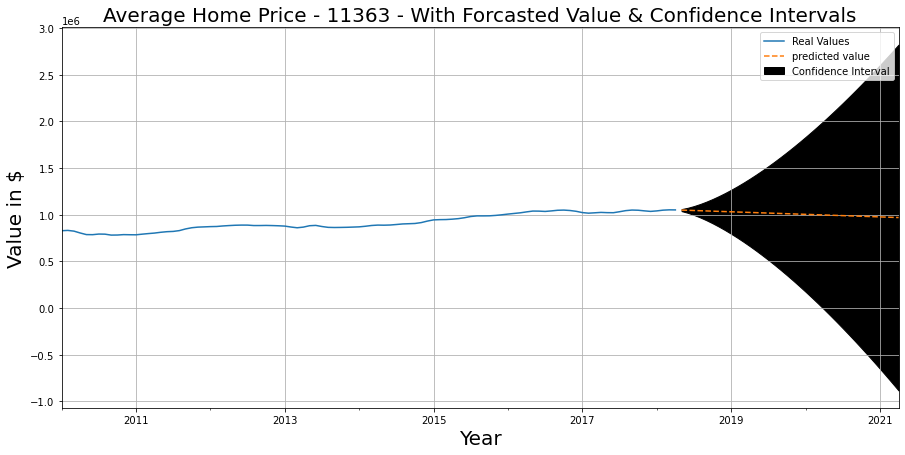

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11363   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -974.825
Date:                Mon, 14 Mar 2022   AIC                           1953.649
Time:                        12:09:09   BIC                           1958.799
Sample:                    01-01-2010   HQIC                          1955.731
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2566      0.092      2.804      0.005       0.077       0.436
sigma2      3.138e+07   4.22e-11   7.44e+17      0.000    3.14e+07    3.14e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):                 1.58
Prob(Q):                              0.12   Prob(JB):                         0.45
Heteroskedasticity (H):               0.82   Skew:                             0.30
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.8120003378605369
MAE:
	 4407.952122274961
RMSE:
	 5492.024519581163
r^2:
	 0.8115908411439289


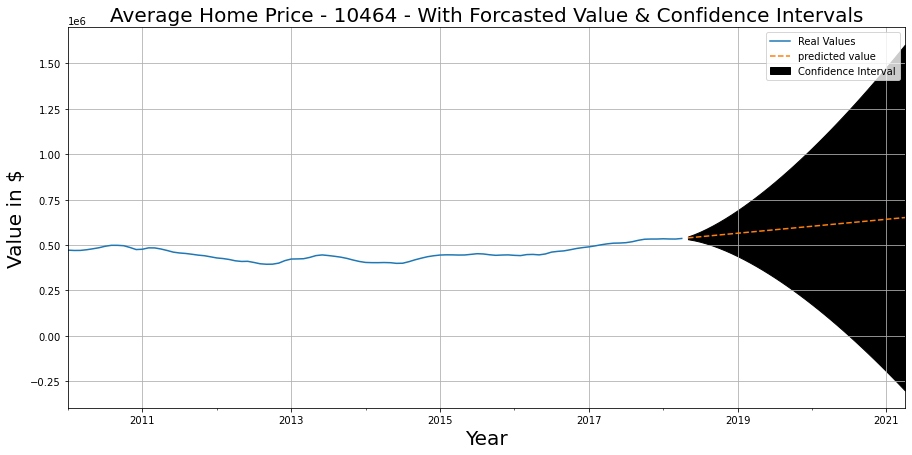

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10464   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -938.944
Date:                Mon, 14 Mar 2022   AIC                           1879.889
Time:                        12:09:09   BIC                           1882.463
Sample:                    01-01-2010   HQIC                          1880.930
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.456e+07   1.85e+06      7.885      0.000    1.09e+07    1.82e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.51   Jarque-Bera (JB):                 2.25
Prob(Q):                              0.03   Prob(JB):                         0.32
Heteroskedasticity (H):               0.56   Skew:                             0.31
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9897280613920866
MAE:
	 2764.285714285714
RMSE:
	 3355.8052046310095
r^2:
	 0.9897213556202145


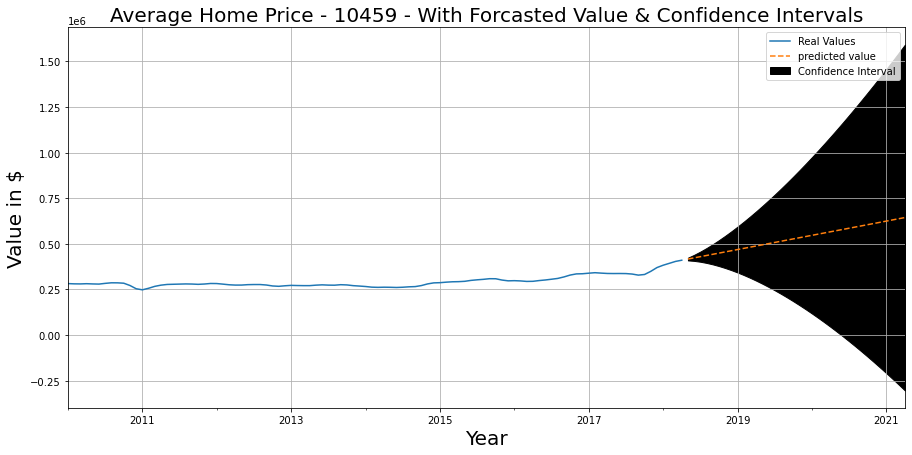

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10459   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -938.660
Date:                Mon, 14 Mar 2022   AIC                           1879.320
Time:                        12:09:10   BIC                           1881.895
Sample:                    01-01-2010   HQIC                          1880.361
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.444e+07   1.26e+06     11.453      0.000     1.2e+07    1.69e+07
===================================================================================
Ljung-Box (L1) (Q):                   8.36   Jarque-Bera (JB):                52.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.97
Prob(H) (two-sided):                  0.90   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9807379831323572
MAE:
	 3214.285714285714
RMSE:
	 4399.837659342834
r^2:
	 0.9805888031827512


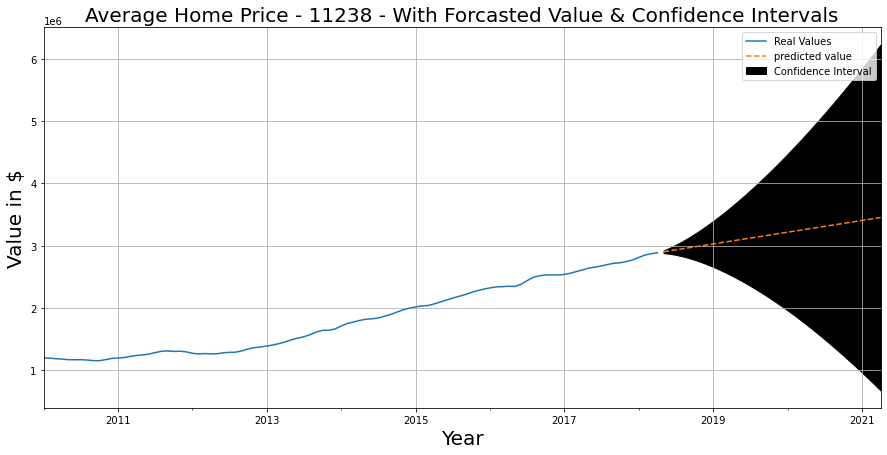

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11238   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1042.735
Date:                Mon, 14 Mar 2022   AIC                           2087.470
Time:                        12:09:10   BIC                           2090.045
Sample:                    01-01-2010   HQIC                          2088.511
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.239e+08   1.57e+07      7.885      0.000    9.31e+07    1.55e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.25   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.13   Prob(JB):                         0.30
Heteroskedasticity (H):               1.46   Skew:                             0.33
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9938963854673357
MAE:
	 10396.42857142857
RMSE:
	 13316.75904372274
r^2:
	 0.9938929060905172


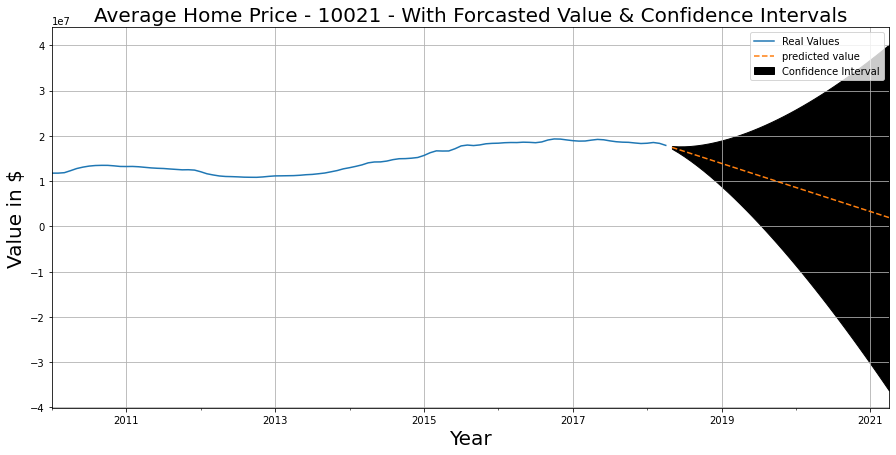

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10021   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1297.018
Date:                Mon, 14 Mar 2022   AIC                           2596.037
Time:                        12:09:11   BIC                           2598.611
Sample:                    01-01-2010   HQIC                          2597.078
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.345e+10   2.67e+09      8.773      0.000    1.82e+10    2.87e+10
===================================================================================
Ljung-Box (L1) (Q):                   4.73   Jarque-Bera (JB):                 4.75
Prob(Q):                              0.03   Prob(JB):                         0.09
Heteroskedasticity (H):               2.27   Skew:                            -0.23
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.7872663259300878
MAE:
	 130107.14285714286
RMSE:
	 157175.33430626357
r^2:
	 0.7840413434118618


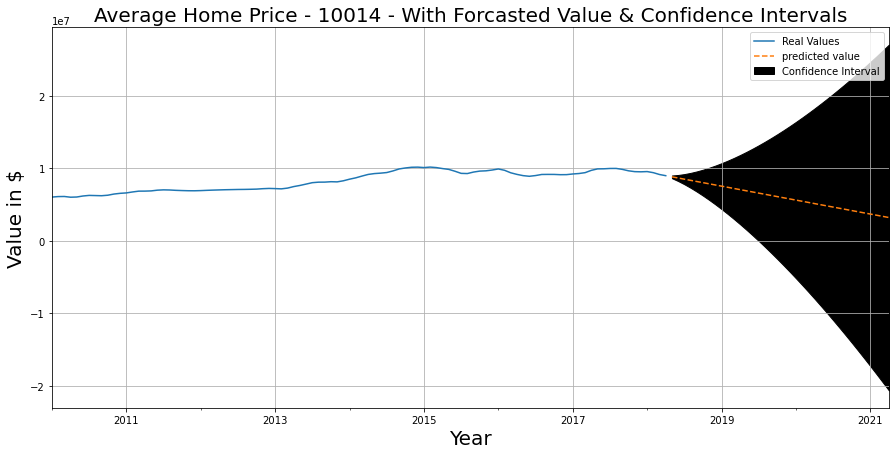

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10014   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1251.340
Date:                Mon, 14 Mar 2022   AIC                           2504.679
Time:                        12:09:11   BIC                           2507.254
Sample:                    01-01-2010   HQIC                          2505.720
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.133e+09   1.09e+09      8.405      0.000       7e+09    1.13e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.81   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.18   Prob(JB):                         0.31
Heteroskedasticity (H):               4.34   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.872907381247498
MAE:
	 100196.42857142857
RMSE:
	 121998.58459366299
r^2:
	 0.8721125498978416


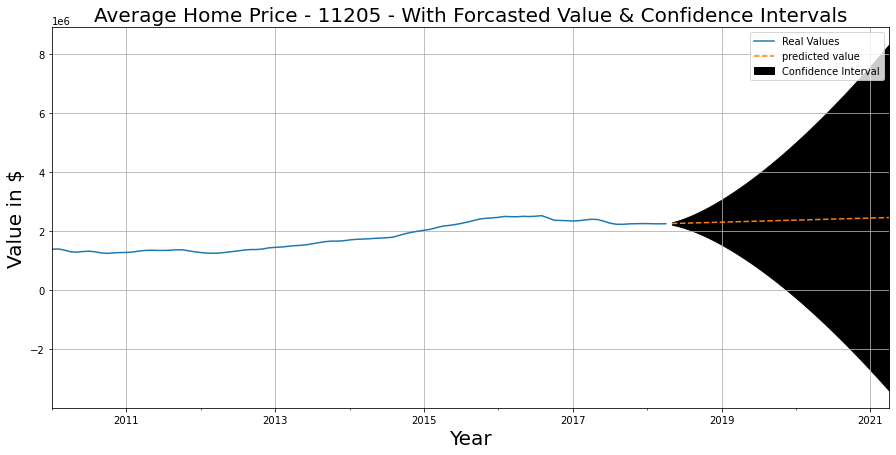

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11205   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1098.865
Date:                Mon, 14 Mar 2022   AIC                           2201.730
Time:                        12:09:12   BIC                           2206.880
Sample:                    01-01-2010   HQIC                          2203.813
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1476      0.130      1.138      0.255      -0.107       0.402
sigma2      4.049e+08   1.28e-10   3.16e+18      0.000    4.05e+08    4.05e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               100.39
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Explained Variance:
	 0.9186185908825193
MAE:
	 19444.764582703854
RMSE:
	 28772.776046894
r^2:
	 0.9186171655540358


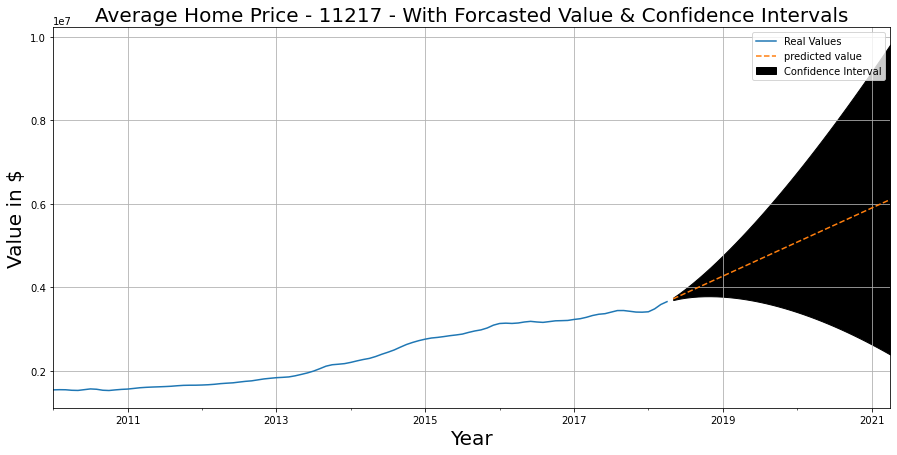

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11217   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1070.935
Date:                Mon, 14 Mar 2022   AIC                           2143.871
Time:                        12:09:12   BIC                           2146.445
Sample:                    01-01-2010   HQIC                          2144.912
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.211e+08   2.21e+07     10.005      0.000    1.78e+08    2.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):                14.89
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               5.37   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9749343849717378
MAE:
	 18321.428571428572
RMSE:
	 22737.335564472556
r^2:
	 0.9749343750770223


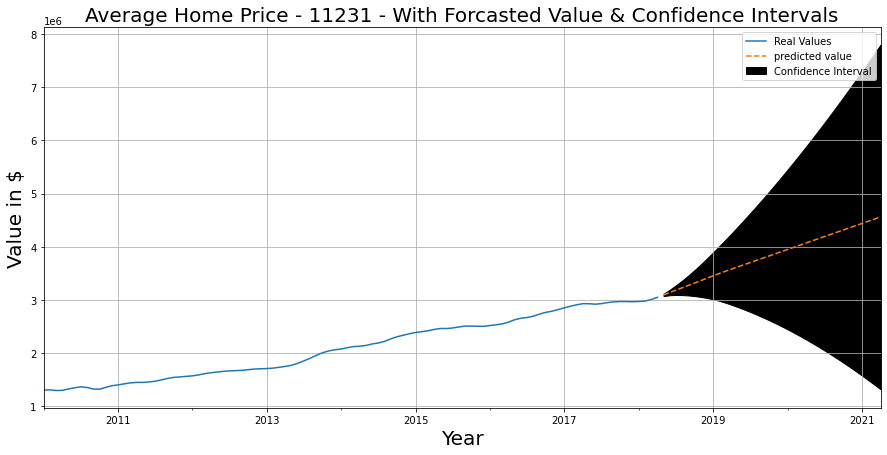

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11231   No. Observations:                  100
Model:             SARIMAX(1, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -898.987
Date:                              Mon, 14 Mar 2022   AIC                           1803.973
Time:                                      12:09:13   BIC                           1811.301
Sample:                                  01-01-2010   HQIC                          1806.921
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2156      0.151      1.432      0.152      -0.079       0.511
ma.S.L12      -0.1124      0.142     -0.792      0.428      -0.391       0.166
sigma2      1.202e+08    1.2e-10      1e+18      0.000     1.2e+08     1.2e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.37   Prob(JB):                         0.57
Heteroskedasticity (H):               3.80   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.9e+33. Standard errors may be unstable.
"""

Explained Variance:
	 0.9951555073044381
MAE:
	 9286.711642245396
RMSE:
	 11192.57782473966
r^2:
	 0.9950949663878085


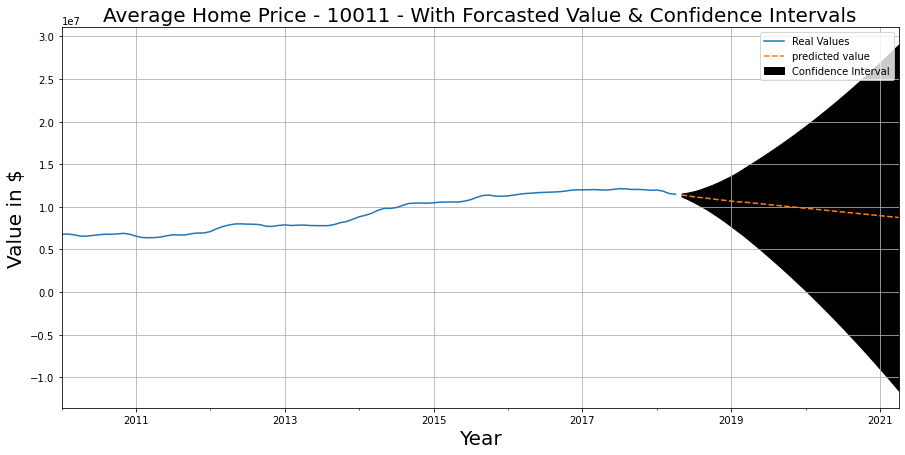

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                10011   No. Observations:                  100
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood               -1090.967
Date:                              Mon, 14 Mar 2022   AIC                           2185.934
Time:                                      12:09:14   BIC                           2190.820
Sample:                                  01-01-2010   HQIC                          2187.899
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1764      0.089     -1.976      0.048      -0.351      -0.001
sigma2      8.032e+09   1.12e-12   7.15e+21      0.000    8.03e+09    8.03e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.71   Prob(JB):                         0.66
Heteroskedasticity (H):               0.73   Skew:                            -0.13
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Explained Variance:
	 0.8999007211366852
MAE:
	 54492.62665822463
RMSE:
	 73900.50159955602
r^2:
	 0.8997261799768279


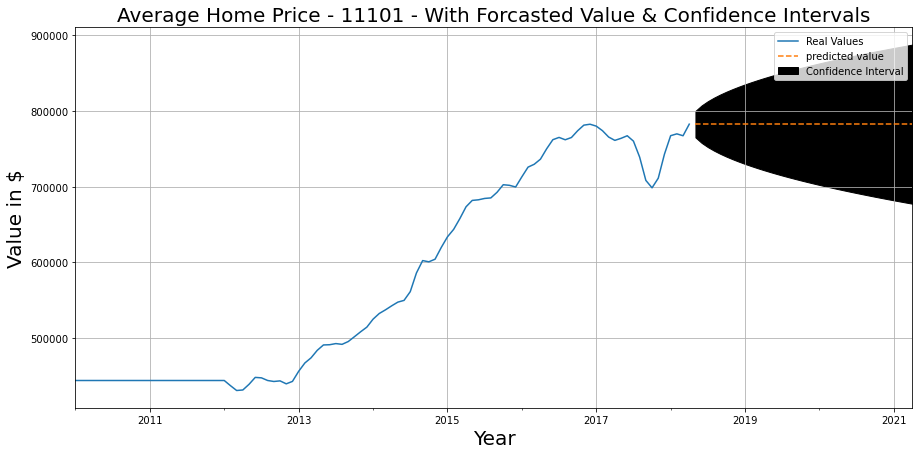

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11101   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1031.557
Date:                Mon, 14 Mar 2022   AIC                           2065.113
Time:                        12:09:15   BIC                           2067.698
Sample:                    01-01-2010   HQIC                          2066.159
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.971e+07   7.58e+06     10.515      0.000    6.49e+07    9.46e+07
===================================================================================
Ljung-Box (L1) (Q):                  38.67   Jarque-Bera (JB):                49.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.49   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.7287698696164691
MAE:
	 9789.285714285714
RMSE:
	 12803.808027301877
r^2:
	 0.7134477624904734


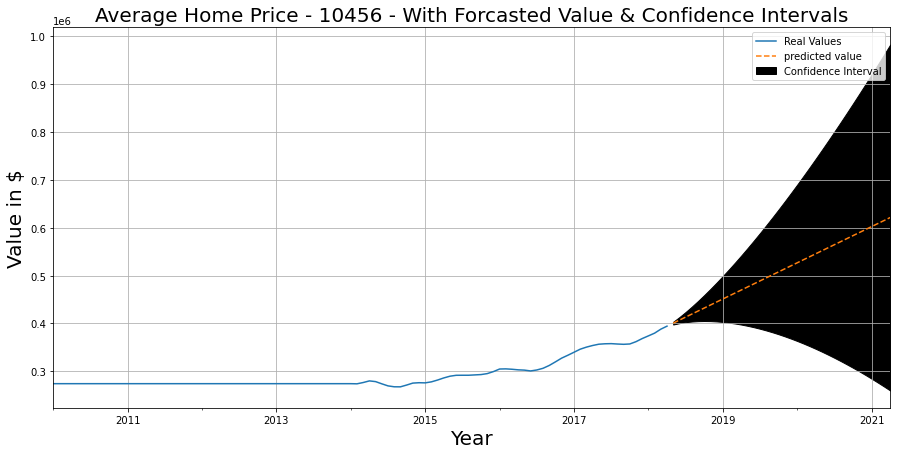

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  10456   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -843.604
Date:                Mon, 14 Mar 2022   AIC                           1689.208
Time:                        12:09:15   BIC                           1691.783
Sample:                    01-01-2010   HQIC                          1690.249
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.095e+06   1.92e+05     10.926      0.000    1.72e+06    2.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.07   Jarque-Bera (JB):                38.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explained Variance:
	 0.9956459288406944
MAE:
	 1475.0
RMSE:
	 1904.9746904955382
r^2:
	 0.9956391693600745


In [52]:
SPLIT = '2016-01-01'

zip_future = {}

# Train-test-split all zip codes
for zipcode in ts_final.columns:
    train = ts_final[zipcode][:SPLIT]
    test = ts_final[zipcode][SPLIT:]
    
    # get the best p,d,q using auto arima
    auto_all = pm.auto_arima(train, start_p=0, start_q=0,
                             test='adf',
                             max_p=5, max_q=5,
                             m=12,
                             max_d=2,
                             seasonal = True,
                             start_P=0,start_Q=0,
                             start_D=0,
                             error_action= 'ignore',
                             suppress_warnings=True,
                             stepwise=True,with_intercept=False,
                             enforce_stationarity=False, 
                             enforce_invertibility=False)
#     display(auto.plot_diagnostics(figsize=(18,18)))
    
    # Use p,d,q from auto arima and apply it to model   
    sarimax_all = SARIMAX(
    ts_final[zipcode],
    order = auto_all.order,
    seasonal_order= auto_all.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
    
    # get predictions
    forecast = sarimax_all.get_forecast(36)
    future_prediction = forecast.conf_int()
    
    # plot forecast
    fig, ax = plt.subplots(figsize=(15, 7))
    ts_final[zipcode].plot(ax=ax,label='Real Values')
    
    
    future_prediction['value'] = forecast.predicted_mean
    future_prediction.columns = ['lower','upper','prediction'] 


    future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

    ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='k',
                label='Confidence Interval')
    ax.legend() 
    plt.ylabel("Value in $", fontsize=20)
    plt.xlabel('Year', fontsize=20)
    plt.title(f'Average Home Price - {zipcode} - With Forcasted Value & Confidence Intervals', fontsize=20)
    plt.grid()
    plt.show()
    
    # Display Results
    display(sarimax_all.summary())
    pred = sarimax_all.predict(start=pd.to_datetime('2016-01-01'), 
          end=pd.to_datetime('2018-04-01'), dynamic = False)
    metric_report(test, pred)

In [53]:
zip_future = {}

SPLIT = '2016-01-01'

# Train-test-split all zip codes
for zipcode in ts_final.columns:
    train = ts_final[zipcode][:SPLIT]
    test = ts_final[zipcode][SPLIT:]
    
    # get the best p,d,q using auto arima
    auto_all = pm.auto_arima(train, start_p=0, start_q=0,
                             test='adf',
                             max_p=5, max_q=5,
                             m=12,
                             max_d=2,
                             seasonal = True,
                             start_P=0,start_Q=0,
                             start_D=0,
                             error_action= 'ignore',
                             suppress_warnings=True,
                             stepwise=True,with_intercept=False,
                             enforce_stationarity=False, 
                             enforce_invertibility=False)
#     display(auto.plot_diagnostics(figsize=(18,18)))
    
    # Use p,d,q from auto arima and apply it to model   
    sarimax_all = SARIMAX(
    ts_final[zipcode],
    order = auto_all.order,
    seasonal_order= auto_all.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
    
    # get predictions
    forecast = sarimax_all.get_forecast(36)
    future_prediction = forecast.conf_int()
    
    future_prediction['value'] = forecast.predicted_mean
    future_prediction.columns = ['lower','upper','prediction']
    
    future_forecast = forecast.summary_frame()
    
    # expected average ROI 5 years into the future
    zip_future[zipcode] = ((future_forecast['mean'][-5] - ts_final[zipcode][-5])/ts_final[zipcode][-5])

In [54]:
# Get the top zip codes with the highest ROI over 5 years
top_zipcodes = []

for (key,value) in zip_future.items():
    if value > .5:
        top_zipcodes.append((key,value))
top_zipcodes        

[(11226, 1.2839304622321632),
 (11211, 1.023990157883945),
 (11219, 0.7885316303932818),
 (11203, 0.6989972785757332),
 (10306, 0.5068332682545881),
 (11691, 0.6505124904629408),
 (11222, 0.6183012335278898),
 (11419, 0.6145286584085661),
 (11433, 0.5173249333656409),
 (11360, 0.6534479188237731),
 (10310, 0.6465164540311961),
 (10303, 0.544913266365225),
 (11692, 0.7860367138128197),
 (11428, 0.5429214853095481),
 (10459, 0.6708997568224804),
 (11217, 0.7122881231456185),
 (10456, 0.6173677069199457)]

In [55]:
top_zipcodes = pd.DataFrame(top_zipcodes)
top_zipcodes = top_zipcodes.rename({0: 'Zipcode'}, axis = 'columns')
top_zipcodes = top_zipcodes.rename({1: 'ROI_in_5_years'}, axis = 'columns')
top_zipcodes = top_zipcodes.sort_values(by = 'ROI_in_5_years', ascending=False).set_index('Zipcode')
top_zipcodes

ROI_in_5_years
Zipcode                
11226          1.283930
11211          1.023990
11219          0.788532
11692          0.786037
11217          0.712288
11203          0.698997
10459          0.670900
11360          0.653448
11691          0.650512
10310          0.646516
11222          0.618301
10456          0.617368
11419          0.614529
10303          0.544913
11428          0.542921
11433          0.517325
10306          0.506833

# Recommendations 

When getting our model results for next 5 years for our models for our top Zip Codes forecasted that zip codes 11226, 11211, 11219, 11692, 11217, 11203 are forecasted to increase. Our chosen model  metrics explained variance is used reflect the variance of the whole data. We use this metric to measure the variability of the predictions in our SARIMA models which finds the difference between expected value and predicted value. Our model must have at least have a 60% of explained variance. The average explained variance for these zipcodes are ~95%-99% meaning we are confident models predicted well for these zip codes. 

When choosing our zip codes we chose the zip codes with the highest return on investment for the next 5 years with the percentages given below.

- 11226: Flatbush, Brooklyn (ROI 128%)
- 11211: Williamsburg, Brooklyn (ROI 102%)
- 11219: Borough Park, Brooklyn (ROI 78%)
- 11692: Arverne: Queens (ROI 78%)
- 11217: Downtown Brooklyn, Brooklyn (ROI 71%)
- 11203: East Flatbush, Brooklyn (ROI 70%)

We recommend investing in boroughs such as Brooklyn and Queens since they are known residential boroughs.

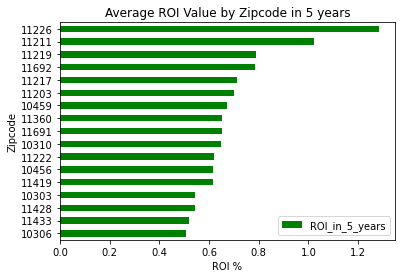

In [56]:
top_zipcodes.sort_values(by = 'ROI_in_5_years').plot.barh(color = 'g')
plt.title(f'Average ROI Value by Zipcode in 5 years')
plt.ylabel(f'Zipcode')
plt.xlabel(f'ROI %')
plt.show()

## Future Work

Although our models performed well in based on the test metrics we want to be able to fine tune our models with exogenous variables to get a more accurate result based on the environment of New York City.

Many variables that weren't accounted for are factors such as:

- COVID Pandemic
- Crime & Neighborhood Rating
- Train Lines
- Commute Times

Since our dataset dates only reaches to April 2018, it is important to factor in the effects of how the COVID-19 pandemic potentially lowered home value rates in New York City since people were trying to leave the city for health reasons. A very important factor that should be taken account is commute times and train locations. Many people that live in NYC rely on public transportation as their main source of travel. The amount of train lines that are available weighs in on the value of the zip code. From our analysis on the mean average value, Manhattan is tremendously higher than the rest of the boroughs because of the amount of easy access it has to train lines thus leading to a shorter to commute time. 